## This notebook contains the script to read the data, integrate the orbits, and produce the plots and tables for the paper "The Milky Way's Plane of Satellites: consistent with $\Lambda$CDM", Sawala et al. (2022).

### Note that you can choose the source of proper motions by setting the variable `PMDATA`, defined in the *Parameters and Definitions* section, which allows the selection of three different sources of proper motions (McConnachie & Venn 2020, Battaglia et al. 2022, Riley et al. 2019) for the outer 8 satellites (DR2 proper motions are always used for the inner satellites, for which there are no new proper motions in the EDR3 catalogues). The file name of the output files are appended to reflect the proper motions used when generating the figure. You need to rerun the notebook (or at least rerun it until the generation of the Monte Carlo samples and integration of the orbits) in order to produce plots using different data sets.

### Another important variable is `Parameters`, which can be either set to `Test` (for faster computation) or to `Paper`, which increases e.g. the Monte Carlo sample size, time resolution, ect., and takes significantly longer to run.

### By Till Sawala and Marius Cautun, 2021 - 2022
### If you encounter any errors please feel free to contact us.


### If you use this code for your publications, please cite the paper "The Milky Way's Plane of Satellites: consistent with $\Lambda$CDM", Sawala et al. (2022). If you use the observational data, be sure to cite the original sources, as listed in the respective files in the "data" directory. If you use the simulation data, please also cite "The SIBELIUS Project: E Pluribus Unum", Sawala et al. (2022).

## Import required modules

In [1]:
import numpy as np
import pickle

import copy

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
import matplotlib.patheffects as path_effects

from astropy import coordinates as coord
import astropy.units as u
from astropy.cosmology import Planck13 as cosmo
from astropy import constants as const
from astropy.io import fits
from astropy.table import Table

from scipy import stats
import scipy.linalg as la
from scipy.interpolate import interp1d 

import sys

import random

import warnings

import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic

import statsmodels.api as sm
import statsmodels.formula.api as smf

import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution() 

2022-05-04 11:06:43.783377: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-04 11:06:43.783395: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Parameters and definitions

### The `Parameters` variable can be set to either `"Test"` or `"Paper"`. The former uses fewer sampling points and runs much faster, the latter uses the same values used to produce the figures in the paper, but takes sinificantly more time to run. If `Parameters` is set to `"Test"`, resulting image files carry a `"_test"` suffix.

### The `PMDATA` variable can be set to either "EDR3-McConnachie", "EDR3-Battaglia" or "DR2-Riley" depending on the source of proper motions used. The image file names carry a suffix identifying the choice of proper motions.

### If `Verbatim` is `True`, extra output is printed.

In [2]:
Parameters = "Test"    # choice of parameters for a quick computation (around 5 minutes on my laptop)
Parameters = "Paper"   # many more iterations, more MC samples, and higher time resolution (around 45 minutes on my laptop)

Verbatim = True # print extra outputs

# Choose the source of the proper motions. We use the McConnachie et al. data as the default.

PMDATA = "EDR3-McConnachie" # default
#PMDATA = "EDR3-Battaglia"
#PMDATA = "DR2-Riley"

hide_warnings = "True" # There are some warnings, e.g. about the formats of the imported tables, and depreciated syntax. To show them, set this to false
if hide_warnings:
    warnings.filterwarnings("ignore")

# some definitions
max_N = 11            # number of satellites
projection = 'hammer' # for the orbital pole projection. 'aitoff' is common but nor equal area, so we choose 'hammer'

# MW potential:
default_halo_mass = 1.0e12*u.Msun
default_disk_mass = 5.17e10*u.Msun
default_bulge_mass = 5.0e9*u.Msun
default_nucleus_mass = 1.7e9*u.Msun
concentration = 11.                   # NFW concentration parameter

# Halo masses used when studying the evolution
halo_masses = np.linspace(0.8, 1.2, 31)*1e12

# Disk masses used when studying the evolution
disk_masses = np.linspace(default_disk_mass.value*.8, default_disk_mass.value*1.2, 21)

# Bulge masses used when studying the evolution
bulge_masses = np.linspace(default_bulge_mass.value*.6, default_bulge_mass.value*1.4, 21)

# Nucleus masses used when studying the evolution
nucleus_masses = np.linspace(default_nucleus_mass.value*.7, default_nucleus_mass.value*1.3, 21)

M200 = halo_masses*u.Msun                                   # we calculate with a constant concentration, and need to supply the scale radius to the potential
r200 = ( (M200 * const.G  / (cosmo.H(0)**2 * 100.) )**(1/3.) ).to(u.kpc)

r_s = r200 / concentration

default_r_s = ( (default_halo_mass * const.G  / (cosmo.H(0)**2 * 100.) )**(1/3.) ).to(u.kpc) / concentration
potential_default = gp.MilkyWayPotential(disk=dict(m=default_disk_mass), nucleus=dict(m=default_nucleus_mass), halo=dict(m=default_halo_mass, r_s = default_r_s), bulge=dict(m=default_bulge_mass) )

print ("Default potential:", potential_default.parameters)

if Parameters == "Test":
    print ("Parameters is set to Test for a quick computation")
    suffix = "_test"
    N_interpolation_points = 1000   # for interpolating the orbits in the simulation
    N_random_samples_Gini = 2000    # For the synthetic isotropic random samples.
    N_random_sky_coordinates = 2000 # For the randomised sky positions
    N_MC_samples = 200               # Number of MC samples (on the plots, there are different upper limits)
    dotsize = 15                    # dot size for the point cloud
    dt=2.*u.Myr                     # length of the integration time step
    dt_MC = 2.*u.Myr
    
if Parameters == "Paper":
    print ("Parameters is set to Paper - this will take a while")
    suffix = ""
    N_interpolation_points = 2000
    N_random_samples_Gini = 100000
    N_random_sky_coordinates = 100000
    N_MC_samples = 200
    dotsize = 2
    dt=0.1*u.Myr
    dt_MC = 1.*u.Myr
    
    
if PMDATA == "EDR3-McConnachie": # default
    suffix = suffix + '_EDR3-McConnachie'
    darkcolor = 'navy'
    lightcolor = 'cornflowerblue'
if PMDATA == "EDR3-Battaglia" :
    suffix = suffix + '_EDR3-Battaglia'
    darkcolor = 'black'
    lightcolor = 'grey'
if PMDATA == "DR2-Riley" :
    suffix = suffix + '_DR2-Riley'
    darkcolor = 'crimson'
    lightcolor = 'lightcoral'

    
    
# Parameters of the time integration
interval = 1000*u.Myr                        # 1 Gyr time interval
N_timesteps = int(interval / dt )            # Number of timesteps for 1 Gyr
N_timesteps_MC = int(interval / dt_MC )            # Number of timesteps for 1 Gyr
times = np.linspace(-1,1,N_timesteps*2)      # times of the combined future and past integrated orbits
times_MC = np.linspace(-1,1,N_timesteps_MC*2)      # times of the combined future and past integrated orbits


# Number of Epochs for the NN for fitting the data
N_epochs_data = 100

# custom colors identifying the 11 brightest satellites
colors_11 = ["#eb0c00", "#eb7900", "#ebbb88", "#ffcc00", "#88eb8b", "#44e2eb", "#88c2eb", "#4465eb", "#a800eb", "#e8cceb", "#eb88e6"]

# shades of blue, mapping values from minval to maxval
minval = 0.1
maxval = 0.55

new_Blues = LinearSegmentedColormap.from_list(
    'trunc({n},{a:.2f},{b:.2f})'.format(n=cm.Blues.name, a=minval, b=maxval),
    cm.Blues(np.linspace(minval, maxval, 100)))

new_Reds = LinearSegmentedColormap.from_list(
    'trunc({n},{a:.2f},{b:.2f})'.format(n=cm.Reds.name, a=minval, b=maxval),
    cm.Reds(np.linspace(minval, maxval, 100)))

colors_blues=new_Blues(np.linspace(0,1.,len(halo_masses)+1))

hex_list = ["#b40426", "#e7755b",  "#f49a7b",  "#8db0fe" , "#7092f3", "#3b4cc0", "#3b4cc0"]



Default potential: {'disk': {'m': <Quantity 5.17e+10 solMass>, 'a': <Quantity 3. kpc>, 'b': <Quantity 0.28 kpc>}, 'bulge': {'m': <Quantity 5.e+09 solMass>, 'c': <Quantity 1. kpc>}, 'nucleus': {'m': <Quantity 1.7e+09 solMass>, 'c': <Quantity 0.07 kpc>}, 'halo': {'m': <Quantity 1.e+12 solMass>, 'r_s': <Quantity 19.16178755 kpc>, 'a': <Quantity 1.>, 'b': <Quantity 1.>, 'c': <Quantity 1.>}}
Parameters is set to Paper - this will take a while


## Functions used in this notebook

In [3]:
# transform to Galactocentric coordinates
def satellite_phase_space_wrt_GC( ra, dec, dist, rad_vel, pmra, pmdec, Sun_R, Sun_z, Sun_vel ):
    gc_frame = coord.Galactocentric( galcen_distance=Sun_R*u.kpc, galcen_v_sun=Sun_vel*u.km/u.s, z_sun=Sun_z*u.kpc)
    
    coord_Sun = coord.SkyCoord( ra=ra, dec=dec, unit=(u.hourangle, u.deg), frame='icrs',
                        distance=dist*u.kpc, 
                        pm_ra_cosdec=pmra*u.mas/u.yr,
                        pm_dec=pmdec*u.mas/u.yr,
                        radial_velocity=rad_vel*u.km/u.s )
    coord_GC = coord_Sun.transform_to(gc_frame)
    return coord_GC


# Display names for the satellite galaxies, ordered by M_v, as they apppear in the figures and tables
def names(num):
    satellite_names = np.array(["LMC", "SMC", "Sagittarius", "Fornax", "Leo I", "Sculptor", "Leo II",
                             "Sextans", "Carina", "Draco", "Ursa Minor", "Canes Ven.", "Antlia 2", "Crater II", "Boötes-1"])
    return satellite_names[0:num]

# Uniform sample. Returns Nx3 cartesian coordinates on the surface of a unit sphere
def sample_reject(num):
    
    # First, create a vector of N points, and reject those with norms < 1.
    vec = np.zeros((3,num))
    coords = 2*np.random.rand(3,num)-1     # Nx3 random points in a cube of side length 2, centered on zero.
    norms = np.linalg.norm(coords,axis=0)
    mask = norms<=1                 # exclude points with norms > 1 - this removes points outside the
                                    # unit sphere to make the angular distribution uniform.

    coords = coords[:,mask]/norms[mask]     # project from the sphere onto the surface of the sphere
    N_accepted = coords.shape[1]
    vec[:,0:N_accepted] = coords
    
    # if there are not N points in the vector after masking, repeat adding more points until there are N.
    while N_accepted<num:
        coords = 2*np.random.rand(3)-1
        norm = np.linalg.norm(coords)
        if 1e-3 <= norm <= 1:
            vec[:,N_accepted] = coords/norm
            N_accepted += 1
    return vec

# square roots of the eigenvalues and the eigenvectors of the reduced inertia tensor
def inertiatensor_reduced (coords):
    r2 = np.sum(np.abs(coords)**2,axis=1)  # compute the radius
    r2 = r2[:,np.newaxis]

    coords = coords / np.sqrt(r2)
    
    n, ndim = np.shape(coords)
    weights = np.ones((n,1))
    
    I = np.einsum('...ij,...ik->...jk', coords, coords*weights)
    m = np.sum(weights)
    
    I = I/(np.ones((ndim,ndim))*m)

    eigenvalues, eigenvectors = la.eigh(I)
    idx_sorted = eigenvalues.argsort()[::-1] #sort in decreasing order
    eigenvalues = eigenvalues[idx_sorted]
    eigenvectors = eigenvectors[:,idx_sorted]

    return np.sqrt(eigenvalues), eigenvectors

# square roots of the eigenvalues and the eigenvectors of the full inertia tensor, using the numpy covariance function.
def inertiatensor (coords):
    x = coords[:,0] - np.mean(coords[:,0])
    y = coords[:,1] - np.mean(coords[:,1])
    z = coords[:,2] - np.mean(coords[:,2])
    
    covariance_matrix = np.cov([x,y,z])
    eigenvalues, eigenvectors = la.eigh(covariance_matrix)
    idx_sorted = eigenvalues.argsort()[::-1] #sort in decreasing order                          
    eigenvalues = eigenvalues[idx_sorted]
    eigenvectors = eigenvectors[:,idx_sorted]

    return np.sqrt(eigenvalues), eigenvectors


# returns the modified Gini coefficient, valid for small N (also called "sample Gini coefficient").
def gini_coefficient(array):
    array = array.flatten()
    if np.amin(array) < 0:
        array -= np.amin(array)
    # sort arguments
    array = np.sort(array)

    indices = np.arange(1,array.shape[0]+1)
    
    N = array.shape[0]
    
    return ((np.sum((2 * indices - N  - 1) * array)) / (np.sum(array))) / (N - 1.)


# functions for making a nice sky plot
radToDeg = 180./np.pi
degToRad = np.pi/180.

def ra_dec( pos, dir_x, dir_y, dir_z ):
    """Computes the ra and dec sky coordinates for the given set of input points."""
    dec = np.pi/2. - np.arccos( (pos*dir_z).sum() / np.sqrt( (pos*pos).sum() ) )
    ra = np.arctan2( (pos*dir_y).sum(), (pos*dir_x).sum() )
    return ra, dec

def skyPlotAxes( ax ):
    for deg in np.linspace(-60,60,5):
        ax.plot( np.linspace(-np.pi,np.pi,360), np.repeat(degToRad*deg,360), 'k:' , lw=.75, label=r"" )
    for deg in np.linspace(-135,135,7):
        ax.plot( np.repeat(degToRad*deg,180), np.linspace(-np.pi/2.,np.pi/2.,180), 'k:' , lw=.75, label=r"" )
        
    plt.xticks( np.linspace(-180*degToRad, 180*degToRad,9)[1:], np.linspace(-180,180,9).astype(int)[1:] )
    plt.yticks( np.linspace( -60*degToRad,  60*degToRad,5), np.linspace(-60,60,5).astype(int) )

def wrap_angle( angle, period, v_min, v_max ):
    while angle <= v_min: 
        angle = angle+period
    while angle >  v_max: 
        angle = angle-period
    return angle


#color map helper function, following: https://towardsdatascience.com/beautiful-custom-colormaps-with-matplotlib-5bab3d1f0e72

def rgb_to_dec(value):
    return [v/256 for v in value]

def hex_to_rgb(value):
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

def get_continuous_cmap(hex_list, float_list=None):

    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mpl.colors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

cmap=get_continuous_cmap(hex_list, float_list=[0.0, 0.18, 0.21, 0.3, 0.5, 0.7, 1.0])

print ("functions defined")

functions defined


# Read the most likely and Monte-Carlo sampled observations, numerically integrate the orbits of the satellites, and save the outputs

## Default Gaia EDR3 data as described in McConnachie & Venn 2020: https://ui.adsabs.harvard.edu/abs/2020AJ....160..124M/abstract
## Alternative Gaia EDR3 data as described in Battaglia et al. 2022: https://ui.adsabs.harvard.edu/abs/2022A%26A...657A..54B/abstract
## Gaia DR2 as described in Table A1 of Riley et al (2019): https://ui.adsabs.harvard.edu/abs/2019MNRAS.486.2679R/abstract 

In [4]:
fits_data_filename = "data/NearbyGalaxies_Jan2021_PUBLIC.fits"

data = Table.read(fits_data_filename) # This is the EDR3 data.

classical_sats = [ 'SagittariusdSph', 'LMC', 'SMC', 'Fornax', 'Leo1', 'Leo2', 'Carina', 'Draco',
                   'Sculptor', 'Sextans(1)', 'UrsaMinor']
numSats_total = len(data['GalaxyName'])
numSats = len(classical_sats)

sel_classical = np.array( [ data['GalaxyName'][i].strip() in classical_sats for i in range(numSats_total) ] )
sat_names = sat_names2 = np.array( [name.strip() for name in data['GalaxyName'][sel_classical]] )
if Verbatim: print( "Found {0} satellites out of {1} looked for.\n\t Found all: {2}".format( sel_classical.sum(), numSats, sel_classical.sum()==numSats) )
if Verbatim: print( np.array(sel_classical).sum(), np.arange(numSats_total)[sel_classical])
if Verbatim: print( sat_names )

reorder = np.array([ 7,  3,  6,  1, 10,  8,  9,  0,  2,  5,  4]) # ordered by distance
if Verbatim: print( sat_names[reorder] )

data2_pm = np.loadtxt( "data/MW_sats_McConnachie_2020_Gaia_DR2.txt", usecols=[8,9,10,11] )[:11] 
data2_satName = np.loadtxt( "data/MW_sats_McConnachie_2020_Gaia_DR2.txt", usecols=[2] )[:11]

print ("data_2pm:", data2_pm)

# The Battaglia data from this table:

# name     pmra epmra+ epmra- pmdec epmdec+ epmdec-
# Carina   0.53, 0.01  0.01   0.13  0.0     0.0
# Draco    0.04  0.01  0.01   -0.19 0.01    0.01
# Fornax   0.381 0.001 0.001  -0.358 0.002 0.002
# Leo I    -0.06 0.01  0.01   -0.12 0.01   0.01
# Leo II   -0.11 0.03  0.03   -0.14 0.03 0.03
# Sextans  -0.40 0.01 0.01     0.02 0.01 0.01
# Sculptor  0.099 0.002 0.002   -0.159 0.002 0.002
# Ursa Minor -0.124 0.004 0.004 0.071 0.005 0.005

# satellites ordered by distance:

pmra_battaglia = [0.04, -0.124, 0.099, -0.40, 0.53, 0.381, -0.11, -0.06]
pmra_plus_battaglia = [0.01, 0.004, 0.002, 0.01, 0.01, 0.001, 0.03, 0.01]
pmra_minus_battaglia = [0.01, 0.004, 0.002, 0.01, 0.01, 0.001, 0.03, 0.01]

pmdec_battaglia = [-0.19, 0.071, -0.195, 0.02, 0.13, -0.358, -0.14, -0.12]  
pmdec_plus_battaglia = [0.01, 0.005, 0.002, 0.01, 0.0, 0.002, 0.03, 0.01]
pmdec_minus_battaglia = [0.01, 0.005, 0.002, 0.01, 0.0, 0.002, 0.03, 0.01]


#pmra = [0.53, 0.04, 0.381, 0.099 , -0.124 , -0.40,  -0.06, -0.11]
#pmra_plus = [0.01, 0.01, 0.001, 0.002 , 0.004, 0.01, 0.01, 0.03]
#pmra_minus = [0.01, 0.01, 0.001, 0.002 , 0.004, 0.01, 0.01, 0.03]
#pmdec = [0.13, -0.19, -0.358, -0.159, 0.071, 0.02, -0.12, -0.14]
#pmdec_plus = [0.0, 0.01, 0.002, 0.002 , 0.005, 0.01, 0.01, 0.03]
#pmdec_minus = [0.0, 0.01, 0.002, 0.002 , 0.005, 0.01, 0.01, 0.03] 

print ('Data Read')

Found 11 satellites out of 11 looked for.
	 Found all: True
11 [ 64  77  81 100 101 102 121 123 124 127 140]
['Carina' 'Draco' 'Fornax' 'LMC' 'Leo1' 'Leo2' 'SMC' 'SagittariusdSph'
 'Sculptor' 'Sextans(1)' 'UrsaMinor']
['SagittariusdSph' 'LMC' 'SMC' 'Draco' 'UrsaMinor' 'Sculptor' 'Sextans(1)'
 'Carina' 'Fornax' 'Leo2' 'Leo1']
data_2pm: [[-2.692e+00  1.000e-03 -1.359e+00  1.000e-03]
 [ 1.850e+00  3.000e-02  2.340e-01  3.000e-02]
 [ 7.970e-01  3.000e-02 -1.220e+00  3.000e-02]
 [-1.000e-02  1.000e-02 -1.400e-01  1.000e-02]
 [-1.600e-01  1.000e-02  6.000e-02  1.000e-02]
 [ 8.100e-02  5.000e-03 -1.360e-01  4.000e-03]
 [-4.400e-01  2.000e-02  9.000e-02  2.000e-02]
 [ 4.800e-01  1.000e-02  1.300e-01  1.000e-02]
 [ 3.800e-01  2.000e-03 -4.100e-01  4.000e-03]
 [-1.200e-01  6.000e-02 -1.700e-01  6.000e-02]
 [-6.000e-02  7.000e-02 -1.800e-01  8.000e-02]]
Data Read


## Merge EDR3 and DR2 data

### For the EDR3 data sets, we need to supplement proper motion data for the LMC, SMC and Sag with DR2 data.
### For the DR2 data set, we replace all proper motion data with DR2 data.

In [5]:
index = np.arange( numSats_total )[sel_classical][reorder]

print ("PMDATA:", PMDATA)

if PMDATA == "DR2-Riley":                      # we overwrite all with DR2
    data['pmra'][index] = data2_pm[:,0]
    data['epmra+'][index] = data2_pm[:,1]
    data['epmra-'][index] = data2_pm[:,1]
    data['pmdec'][index] = data2_pm[:,2]
    data['epmdec+'][index] = data2_pm[:,3]
    data['epmdec-'][index] = data2_pm[:,3]
    

if PMDATA == "EDR3-McConnachie" or PMDATA == "EDR3-Battaglia": # we overwrite the first three (missing from EDR3) with DR2
    print ("filling first 3 with dr2")
    data['pmra'][index[:3]] = data2_pm[:3,0]
    data['epmra+'][index[:3]] = data2_pm[:3,1]
    data['epmra-'][index[:3]] = data2_pm[:3,1]
    data['pmdec'][index[:3]] = data2_pm[:3,2]
    data['epmdec+'][index[:3]] = data2_pm[:3,3]
    data['epmdec-'][index[:3]] = data2_pm[:3,3]


if PMDATA == "EDR3-Battaglia": # we overwrite the last 8 with the data from Battaglia
    print ("replacing outer 8 with EDR3-Battaglia")    
    for i in range(3,11):
        data['pmra'][index[i]] = pmra_battaglia[i-3]
        data['epmra+'][index[i]] = pmra_plus_battaglia[i-3]
        data['epmra-'][index[i]] = pmra_minus_battaglia[i-3]
        data['pmdec'][index[i]] = pmdec_battaglia[i-3]
        data['epmdec+'][index[i]] = pmdec_plus_battaglia[i-3]
        data['epmdec-'][index[i]] = pmdec_minus_battaglia[i-3]
    
print ('Data merged')


    


PMDATA: EDR3-McConnachie
filling first 3 with dr2
Data merged


## Updated the Distance Modulus to the most precise measurements.

In [6]:
data3_dismod = np.loadtxt( "data/MW_sats_updated_distances_2021_08.txt", usecols=[1,2] )
data3_satName = np.loadtxt( "data/MW_sats_updated_distances_2021_08.txt", usecols=[0], dtype='str' )
print(data3_satName)

table_satellite_names = [ data['GalaxyName'][i].strip() for i in range(numSats_total) ]

for i in range( data3_satName.shape[0] ):
    if data3_satName[i] not in table_satellite_names:
        print( "Entry '%s' not found in the table of galaxies!" % (data3_satName[i]) )
        continue
    index = table_satellite_names.index( data3_satName[i] )
    data['dmod' ][index] = data3_dismod[i,0]
    data['dmod+'][index] = data3_dismod[i,1]
    data['dmod-'][index] = data3_dismod[i,1]
    data['dmod' ][index] = data3_dismod[i,0]
    data['dmod+'][index] = data3_dismod[i,1]
    data['dmod-'][index] = data3_dismod[i,1]

if Verbatim:  
    print ("\nData:")
    print (data[['GalaxyName','dmod','dmod+','dmod-', 'vh', 'pmra', 'epmra+', 'epmra-', 'pmdec', 'epmdec+', 'epmdec-']][sel_classical][reorder])
   

['SagittariusdSph' 'LMC' 'SMC' 'Carina' 'Draco' 'Fornax' 'Sculptor'
 'UrsaMinor' 'Sextans(1)' 'Leo1' 'Leo2']

Data:
   GalaxyName     dmod  dmod+ dmod-   vh    pmra  epmra+ epmra- pmdec  epmdec+ epmdec-
---------------- ------ ----- ----- ------ ------ ------ ------ ------ ------- -------
SagittariusdSph   17.25 0.008 0.008  140.0 -2.692  0.001  0.001 -1.359   0.001   0.001
LMC              18.477 0.026 0.026  262.2   1.85   0.03   0.03  0.234    0.03    0.03
SMC              18.977 0.028 0.028  145.6  0.797   0.03   0.03  -1.22    0.03    0.03
Draco             19.35  0.01  0.01 -291.0  0.042  0.005  0.005  -0.19    0.01    0.01
UrsaMinor         19.18  0.02  0.02 -246.9 -0.124  0.004  0.004  0.078   0.004   0.004
Sculptor          19.62  0.04  0.04  111.4  0.099  0.002  0.002  -0.16   0.002   0.002
Sextans(1)        19.55  0.01  0.01  224.2  -0.41   0.01   0.01   0.04    0.01    0.01
Carina            20.12  0.11  0.11  222.9   0.53   0.01   0.01   0.12    0.01    0.01
Fornax        

## solar measurements and errors

In [7]:
sun_vCirc = np.array( [234.7, 1.7] )   # Vcirc at Sun's position: value + error from Nitschai + 2021 -- https://ui.adsabs.harvard.edu/abs/2021ApJ...916..112N/abstract
sun_R = np.array( [8.178, 0.022] )  # in-plane distance of the Sun from GC: value + error from Gravity Collaboration + 2019 -- https://ui.adsabs.harvard.edu/abs/2019A%26A...625L..10G/abstract
sun_LSR   = np.array( [ [11.10, 0.72], [12.24,0.47], [7.25,0.37] ]  )  # (U,V,W) vel. of sun w.r.t. local standard of rest - Schonrich, Binney and Dehnen 2010 -- https://ui.adsabs.harvard.edu/abs/2010MNRAS.403.1829S/abstract
sun_z = np.array( [0.020,0.01])   # Sun's z displacement Joshi (2007) -- https://ui.adsabs.harvard.edu/abs/2007MNRAS.378..768J/exportcitation

## Transform the ML data:

In [8]:
sat_dist= coord.Distance( distmod=data['dmod'][sel_classical], unit=u.kpc).value
sun_vel = [sun_LSR[0,0], sun_vCirc[0]+sun_LSR[1,0], sun_LSR[2,0]]

coords = satellite_phase_space_wrt_GC( ra=data['RA'][sel_classical], dec=data['Dec'][sel_classical], \
                                          dist=sat_dist, rad_vel=data['vh'][sel_classical], \
                                          pmra=data['pmra'][sel_classical], pmdec =data['pmdec'][sel_classical], \
                                          Sun_R=sun_R[0], Sun_z=sun_z[0], Sun_vel=sun_vel )

# sort satellites in order of distance from GC
pos_GC_ML = np.column_stack( (coords.x.value, coords.y.value, coords.z.value) )   # most likely value
vel_GC_ML = np.column_stack( (coords.v_x.value, coords.v_y.value, coords.v_z.value) )   # most likely value
dis_GC_ML = np.sqrt( (pos_GC_ML**2).sum(axis=1) )
order = dis_GC_ML.argsort()

sat_names = sat_names2[order]
pos_GC_ML = pos_GC_ML[order]
vel_GC_ML = vel_GC_ML[order]
dis_GC_ML = dis_GC_ML[order]

if Verbatim: print( "Most likely distances of the satellites from the Galactic Centre [kpc]:\n", dis_GC_ML)

# Using the radii, print Kish's effective sample size:  Kish, (1965), "Survey sampling", Wiley.

sum_squared = (np.sum(dis_GC_ML**2.))**2.
sum_of_squares = np.sum(dis_GC_ML**4.)

print ("Kish effective sample size = ", sum_squared / sum_of_squares)

Most likely distances of the satellites from the Galactic Centre [kpc]:
 [ 20.40492009  49.01424549  59.73810431  70.50717495  74.15627217
  84.05074368  84.33730172 107.28601871 144.61188811 219.32809563
 263.23831277]
Kish effective sample size =  4.161628330066024


## Generate the MC samples

In [9]:
# loop over the number of MC realizations and for each one obtain a set of positions and velocities w.r.t. the Galactic Centre

# arrays for storing the final satellite positions and velocities in GC reference frame
pos_GC = np.empty( (N_MC_samples,numSats,3), np.float64 )
vel_GC = np.empty( (N_MC_samples,numSats,3), np.float64 )

# generate MC samples for the satellite observables
sat_dist = np.empty( (N_MC_samples,numSats), np.float64 )
sat_radV = np.empty( (N_MC_samples,numSats), np.float64 )
sat_pmra = np.empty( (N_MC_samples,numSats), np.float64 )
sat_pmdec= np.empty( (N_MC_samples,numSats), np.float64 )
sat_index= np.arange(numSats_total)[sel_classical]

for i in range(numSats):
    index = sat_index[i]
    
    edmod = 0.5 * (data['dmod+'][index] + data['dmod-'][index])
    dist_mod = np.random.normal( loc=data['dmod'][index], scale=edmod, size=N_MC_samples ) 
    sat_dist[:,i] = coord.Distance( distmod=dist_mod, unit=u.kpc).value
    
    evh = 0.5 * (data['vh+'][index] + data['vh-'][index])
    sat_radV[:,i] = np.random.normal( loc=data['vh'][index], scale=evh, size=N_MC_samples )
    
    epmra = 0.5 * (data['epmra+'][index] + data['epmra-'][index])
    sat_pmra[:,i] = np.random.normal( loc=data['pmra'][index], scale=epmra, size=N_MC_samples )
    
    epmdec = 0.5 * (data['epmdec+'][index] + data['epmdec-'][index])
    sat_pmdec[:,i] = np.random.normal( loc=data['pmdec'][index], scale=epmdec, size=N_MC_samples )

# generate MC samples for the Sun's position and velocity
Sun_R = np.random.normal( loc=sun_R[0], scale=sun_R[1], size=N_MC_samples )
Sun_z = np.random.normal( loc=sun_z[0], scale=sun_z[1], size=N_MC_samples )
Sun_U = np.random.normal( loc=sun_LSR[0,0], scale=sun_LSR[0,1], size=N_MC_samples )
Sun_V = np.random.normal( loc=sun_LSR[1,0], scale=sun_LSR[1,1], size=N_MC_samples ) + np.random.normal( loc=sun_vCirc[0], scale=sun_vCirc[1], size=N_MC_samples )
Sun_W = np.random.normal( loc=sun_LSR[2,0], scale=sun_LSR[2,1], size=N_MC_samples )
Sun_vel = np.column_stack( (Sun_U,Sun_V,Sun_W) )

# transform from solar to galactic coordinates
for i in range(N_MC_samples):
    coords = satellite_phase_space_wrt_GC( ra=data['RA'][sel_classical], dec=data['Dec'][sel_classical], \
                                          dist=sat_dist[i], rad_vel=sat_radV[i], \
                                          pmra=sat_pmra[i], pmdec =sat_pmdec[i], \
                                          Sun_R=Sun_R[i], Sun_z=Sun_z[i], Sun_vel=Sun_vel[i] )
    pos_GC[i,] = np.column_stack( (coords.x.value, coords.y.value, coords.z.value) )[order]
    vel_GC[i,] = np.column_stack( (coords.v_x.value, coords.v_y.value, coords.v_z.value) )[order]
    
# save the data
outfile = "data/MW_classical_sats_MC_samples"+suffix+".npz"
np.savez( outfile, satellite_names=sat_names, positions_GC=pos_GC, velocities_GC=vel_GC, \
         positions_GC_ML=pos_GC_ML, velocities_GC_ML=vel_GC_ML, distances_GC_ML=dis_GC_ML )

print ("saved MC file")

print ('done')

saved MC file
done


# Integrate the Most Likely orbits

In [10]:
# To get the satellites in the correct order (by luminosity)
indexes_by_luminosity = [1,  2,   0,   8,   10,  5,   9,  6, 7, 3, 4]  

coords_ML = pos_GC_ML[indexes_by_luminosity]
vels_ML = vel_GC_ML[indexes_by_luminosity]

eigenvalues_ML_z0, eigenvectors_ML_z0 = inertiatensor(coords_ML)
eigenvalues_ML_reduced_z0, eigenvectors_ML_reduced_z0 = inertiatensor_reduced(coords_ML)

satellites_names = names(max_N)

# transform to proper units
x_z0 = np.array (coords_ML[:,0])*u.kpc
y_z0 = np.array (coords_ML[:,1])*u.kpc
z_z0 = np.array (coords_ML[:,2])*u.kpc

vx_z0 = (vels_ML[:,0])*u.km/u.s
vy_z0 = (vels_ML[:,1])*u.km/u.s
vz_z0 = (vels_ML[:,2])*u.km/u.s

# Integrate for 20 Gyr, so we can get the full orbital period, finely sampled
# save the results 1/2 period in the past and 1/2 period in the future

coords_ML_integrated_half_period = []
coords_ML_integrated_half_period_future = []

periods_ML = np.zeros(max_N)

for i in range (0,max_N):
    coords = coord.SkyCoord(x=x_z0[i],
                            y=y_z0[i],
                            z=z_z0[i],
                            v_x=vx_z0[i],
                            v_y=vy_z0[i],
                            v_z=vz_z0[i],
                            frame=coord.Galactocentric)
    
    w0 = gd.PhaseSpacePosition(coords.data)
    orbit = potential_default.integrate_orbit(w0, dt=-dt/5, n_steps= N_timesteps*100) # the past evolution (dt is negative)
    orbit_future = potential_default.integrate_orbit(w0, dt=dt/5, n_steps=N_timesteps*100) # future evolution
        
    select_past = np.where(orbit.t > orbit.estimate_period() / 2. )[0]
    select_future = np.where(orbit_future.t < orbit_future.estimate_period() / 2. )[0]
    
    # galactocentric coordinates    
    x = np.array(orbit.x)[select_past]
    y = np.array(orbit.y)[select_past]
    z = np.array(orbit.z)[select_past]

    # and the future
    x_future = np.array(orbit_future.x)[select_future]
    y_future = np.array(orbit_future.y)[select_future]
    z_future = np.array(orbit_future.z)[select_future]
    
    coords_ML_integrated_half_period.append([x, y, z])
    coords_ML_integrated_half_period_future.append([x_future, y_future, z_future])
    
    periods_ML[i] = orbit.estimate_period().value
    
coords_ML_integrated_half_period = np.array(coords_ML_integrated_half_period)
coords_ML_integrated_half_period_future = np.array(coords_ML_integrated_half_period_future)

# Integrate 1 Gyr in the past, 1 Gyr in the future.
coords_ML_integrated_1Gyr = []
coords_ML_integrated_1Gyr_future = []

for i in range (0,max_N):
    coords = coord.SkyCoord(x=x_z0[i],
                            y=y_z0[i],
                            z=z_z0[i],
                            v_x=vx_z0[i],
                            v_y=vy_z0[i],
                            v_z=vz_z0[i],
                            frame=coord.Galactocentric)
    
    w0 = gd.PhaseSpacePosition(coords.data)
    orbit = potential_default.integrate_orbit(w0, dt=-dt, n_steps= N_timesteps) # the past evolution (dt is negative)
    orbit_future = potential_default.integrate_orbit(w0, dt=dt, n_steps= N_timesteps) # future evolution
        
    # galactocentric coordinates    
    x = np.array(orbit.x)
    y = np.array(orbit.y)
    z = np.array(orbit.z)

    # and the future
    x_future = np.array(orbit_future.x)
    y_future = np.array(orbit_future.y)
    z_future = np.array(orbit_future.z)
        
    coords_ML_integrated_1Gyr.append([x, y, z])
    coords_ML_integrated_1Gyr_future.append([x_future, y_future, z_future])
    
coords_ML_integrated_1Gyr = np.array(coords_ML_integrated_1Gyr)
coords_ML_integrated_1Gyr_future = np.array(coords_ML_integrated_1Gyr_future)


# Integrate 2 Gyr in the past, 2 Gyr in the future.
coords_ML_integrated_2Gyr = []
coords_ML_integrated_2Gyr_future = []

for i in range (0,max_N):
    coords = coord.SkyCoord(x=x_z0[i],
                            y=y_z0[i],
                            z=z_z0[i],
                            v_x=vx_z0[i],
                            v_y=vy_z0[i],
                            v_z=vz_z0[i],
                            frame=coord.Galactocentric)
    
    w0 = gd.PhaseSpacePosition(coords.data)
    orbit = potential_default.integrate_orbit(w0, dt=-dt, n_steps= N_timesteps*2) # the past evolution (dt is negative)
    orbit_future = potential_default.integrate_orbit(w0, dt=dt, n_steps= N_timesteps*2) # future evolution
        
    # galactocentric coordinates    
    x = np.array(orbit.x)
    y = np.array(orbit.y)
    z = np.array(orbit.z)

    # and the future
    x_future = np.array(orbit_future.x)
    y_future = np.array(orbit_future.y)
    z_future = np.array(orbit_future.z)
        
    coords_ML_integrated_2Gyr.append([x, y, z])
    coords_ML_integrated_2Gyr_future.append([x_future, y_future, z_future])
    
coords_ML_integrated_2Gyr = np.array(coords_ML_integrated_2Gyr)
coords_ML_integrated_2Gyr_future = np.array(coords_ML_integrated_2Gyr_future)


# Repeat the 1 Gyr integration for varying halo masses:

mass_index = 0

coords_ML_integrated_masses = []
coords_ML_integrated_masses_future = []

for index, this_halo_mass in enumerate(halo_masses):
    print('Halo mass: ', this_halo_mass, end='\r')
    
    this_r_s = r_s[index]
    
    # change the potential
    potential = gp.MilkyWayPotential(disk=dict(m=default_disk_mass), nucleus=dict(m=default_nucleus_mass), halo=dict(m=this_halo_mass*u.Msun, r_s = this_r_s), bulge=dict(m=default_bulge_mass) )
    
    coords_ML_integrated_mass = []
    coords_ML_integrated_mass_future = []
    
    # transform to proper units
    x_z0 = np.array (coords_ML[:,0])*u.kpc
    y_z0 = np.array (coords_ML[:,1])*u.kpc
    z_z0 = np.array (coords_ML[:,2])*u.kpc

    vx_z0 = (vels_ML[:,0])*u.km/u.s
    vy_z0 = (vels_ML[:,1])*u.km/u.s
    vz_z0 = (vels_ML[:,2])*u.km/u.s
    
    # integrate each satellite in turn
    for i in range (0,max_N):    
        coords = coord.SkyCoord(x=x_z0[i],
                            y=y_z0[i],
                            z=z_z0[i],
                            v_x=vx_z0[i],
                            v_y=vy_z0[i],
                            v_z=vz_z0[i],
                            frame=coord.Galactocentric)
    
        w0 = gd.PhaseSpacePosition(coords.data)
        orbit = potential.integrate_orbit(w0, dt=-dt, n_steps= N_timesteps) # the past evolution (dt is negative)
        orbit_future = potential.integrate_orbit(w0, dt=dt, n_steps=N_timesteps) # future evolution
    
        # galactocentric coordinates    
        x = np.array(orbit.x)
        y = np.array(orbit.y)
        z = np.array(orbit.z)

        # and the future
        x_future = np.array(orbit_future.x)
        y_future = np.array(orbit_future.y)
        z_future = np.array(orbit_future.z)
    
        coords_ML_integrated_mass.append([x, y, z])
        coords_ML_integrated_mass_future.append([x_future, y_future, z_future])

    coords_ML_integrated_mass = np.array(coords_ML_integrated_mass)
    coords_ML_integrated_mass_future = np.array(coords_ML_integrated_mass_future)

    coords_ML_integrated_masses.append(coords_ML_integrated_mass)
    coords_ML_integrated_masses_future.append(coords_ML_integrated_mass_future)
    
coords_ML_integrated_masses=np.array(coords_ML_integrated_masses)
coords_ML_integrated_masses_future=np.array(coords_ML_integrated_masses_future)


# vary the bulge mass
bulge_mass_index = 0

coords_ML_integrated_bulge_masses = []
coords_ML_integrated_bulge_masses_future = []

for bulge_mass in bulge_masses:
    print('Bulge mass: ', bulge_mass, end='\r')

    # change the potential
    potential = gp.MilkyWayPotential(disk=dict(m=default_disk_mass), nucleus=dict(m=default_nucleus_mass), halo=dict(m=default_halo_mass, r_s = default_r_s), bulge=dict(m=bulge_mass*u.Msun) )
    
    coords_ML_integrated_bulge_mass = []
    coords_ML_integrated_bulge_mass_future = []
    
    # transform to proper units
    x_z0 = np.array (coords_ML[:,0])*u.kpc
    y_z0 = np.array (coords_ML[:,1])*u.kpc
    z_z0 = np.array (coords_ML[:,2])*u.kpc

    vx_z0 = (vels_ML[:,0])*u.km/u.s
    vy_z0 = (vels_ML[:,1])*u.km/u.s
    vz_z0 = (vels_ML[:,2])*u.km/u.s
    
    # integrate each satellite in turn
    for i in range (0,max_N):    
        coords = coord.SkyCoord(x=x_z0[i],
                            y=y_z0[i],
                            z=z_z0[i],
                            v_x=vx_z0[i],
                            v_y=vy_z0[i],
                            v_z=vz_z0[i],
                            frame=coord.Galactocentric)
    
        w0 = gd.PhaseSpacePosition(coords.data)
        orbit = potential.integrate_orbit(w0, dt=-dt, n_steps= N_timesteps) # the past evolution (dt is negative)
        orbit_future = potential.integrate_orbit(w0, dt=dt, n_steps=N_timesteps) # future evolution
    
        # galactocentric coordinates    
        x = np.array(orbit.x)
        y = np.array(orbit.y)
        z = np.array(orbit.z)

        # and the future
        x_future = np.array(orbit_future.x)
        y_future = np.array(orbit_future.y)
        z_future = np.array(orbit_future.z)
    
        coords_ML_integrated_bulge_mass.append([x, y, z])
        coords_ML_integrated_bulge_mass_future.append([x_future, y_future, z_future])
    
    coords_ML_integrated_bulge_mass = np.array(coords_ML_integrated_bulge_mass)
    coords_ML_integrated_bulge_mass_future = np.array(coords_ML_integrated_bulge_mass_future)

    coords_ML_integrated_bulge_masses.append(coords_ML_integrated_bulge_mass)
    coords_ML_integrated_bulge_masses_future.append(coords_ML_integrated_bulge_mass_future)
    
coords_ML_integrated_bulge_masses=np.array(coords_ML_integrated_bulge_masses)
coords_ML_integrated_bulge_masses_future=np.array(coords_ML_integrated_bulge_masses_future)

# vary the disk mass
disk_mass_index = 0

coords_ML_integrated_disk_masses = []
coords_ML_integrated_disk_masses_future = []

for disk_mass in disk_masses:
    print('Disk mass: ', disk_mass, end='\r')

    # change the potential
    potential = gp.MilkyWayPotential(disk=dict(m=disk_mass*u.Msun), nucleus=dict(m=default_nucleus_mass), halo=dict(m=default_halo_mass, r_s = default_r_s), bulge=dict(m=default_bulge_mass) )

    coords_ML_integrated_disk_mass = []
    coords_ML_integrated_disk_mass_future = []
    
    # transform to proper units
    x_z0 = np.array (coords_ML[:,0])*u.kpc
    y_z0 = np.array (coords_ML[:,1])*u.kpc
    z_z0 = np.array (coords_ML[:,2])*u.kpc

    vx_z0 = (vels_ML[:,0])*u.km/u.s
    vy_z0 = (vels_ML[:,1])*u.km/u.s
    vz_z0 = (vels_ML[:,2])*u.km/u.s
    
    # integrate each satellite in turn
    for i in range (0,max_N):    
        coords = coord.SkyCoord(x=x_z0[i],
                            y=y_z0[i],
                            z=z_z0[i],
                            v_x=vx_z0[i],
                            v_y=vy_z0[i],
                            v_z=vz_z0[i],
                            frame=coord.Galactocentric)
    
        w0 = gd.PhaseSpacePosition(coords.data)
        orbit = potential.integrate_orbit(w0, dt=-dt, n_steps= N_timesteps) # the past evolution (dt is negative)
        orbit_future = potential.integrate_orbit(w0, dt=dt, n_steps=N_timesteps) # future evolution
    
        # galactocentric coordinates    
        x = np.array(orbit.x)
        y = np.array(orbit.y)
        z = np.array(orbit.z)

        # and the future
        x_future = np.array(orbit_future.x)
        y_future = np.array(orbit_future.y)
        z_future = np.array(orbit_future.z)
    
        coords_ML_integrated_disk_mass.append([x, y, z])
        coords_ML_integrated_disk_mass_future.append([x_future, y_future, z_future])

    coords_ML_integrated_disk_mass = np.array(coords_ML_integrated_disk_mass)
    coords_ML_integrated_disk_mass_future = np.array(coords_ML_integrated_disk_mass_future)

    coords_ML_integrated_disk_masses.append(coords_ML_integrated_disk_mass)
    coords_ML_integrated_disk_masses_future.append(coords_ML_integrated_disk_mass_future)
    
coords_ML_integrated_disk_masses=np.array(coords_ML_integrated_disk_masses)
coords_ML_integrated_disk_masses_future=np.array(coords_ML_integrated_disk_masses_future)

# vary the nucleus mass
nucleus_mass_index = 0

coords_ML_integrated_nucleus_masses = []
coords_ML_integrated_nucleus_masses_future = []

for nucleus_mass in nucleus_masses:
    print('Nucleus mass: ', nucleus_mass, end='\r')

    # change the potential
    potential = gp.MilkyWayPotential(disk=dict(m=default_disk_mass), nucleus=dict(m=nucleus_mass*u.Msun), halo=dict(m=default_halo_mass, r_s = default_r_s), bulge=dict(m=default_bulge_mass) )
    
    coords_ML_integrated_nucleus_mass = []
    coords_ML_integrated_nucleus_mass_future = []
    
    # transform to proper units
    x_z0 = np.array (coords_ML[:,0])*u.kpc
    y_z0 = np.array (coords_ML[:,1])*u.kpc
    z_z0 = np.array (coords_ML[:,2])*u.kpc

    vx_z0 = (vels_ML[:,0])*u.km/u.s
    vy_z0 = (vels_ML[:,1])*u.km/u.s
    vz_z0 = (vels_ML[:,2])*u.km/u.s
    
    # integrate each satellite in turn
    for i in range (0,max_N):    
        coords = coord.SkyCoord(x=x_z0[i],
                            y=y_z0[i],
                            z=z_z0[i],
                            v_x=vx_z0[i],
                            v_y=vy_z0[i],
                            v_z=vz_z0[i],
                            frame=coord.Galactocentric)
    
        w0 = gd.PhaseSpacePosition(coords.data)
        orbit = potential.integrate_orbit(w0, dt=-dt, n_steps= N_timesteps) # the past evolution (dt is negative)
        orbit_future = potential.integrate_orbit(w0, dt=dt, n_steps=N_timesteps) # future evolution
    
        # galactocentric coordinates    
        x = np.array(orbit.x)
        y = np.array(orbit.y)
        z = np.array(orbit.z)

        # and the future
        x_future = np.array(orbit_future.x)
        y_future = np.array(orbit_future.y)
        z_future = np.array(orbit_future.z)
    
        coords_ML_integrated_nucleus_mass.append([x, y, z])
        coords_ML_integrated_nucleus_mass_future.append([x_future, y_future, z_future])

    coords_ML_integrated_nucleus_mass = np.array(coords_ML_integrated_nucleus_mass)
    coords_ML_integrated_nucleus_mass_future = np.array(coords_ML_integrated_nucleus_mass_future)

    coords_ML_integrated_nucleus_masses.append(coords_ML_integrated_nucleus_mass)
    coords_ML_integrated_nucleus_masses_future.append(coords_ML_integrated_nucleus_mass_future)
    
coords_ML_integrated_nucleus_masses=np.array(coords_ML_integrated_nucleus_masses)
coords_ML_integrated_nucleus_masses_future=np.array(coords_ML_integrated_nucleus_masses_future)


print ("\n done")


Nucleus mass:  2210000000.0665
 done


## Integrate the MC data

In [11]:
MCData = np.load("data/MW_classical_sats_MC_samples"+suffix+".npz", allow_pickle=True)
coords_MC = MCData['positions_GC']
vels_MC = MCData['velocities_GC']

# To get the satellites in the correct order (by luminosity)
indexes = [1,  2,   0,   8,   10,  5,   9,  6, 7, 3, 4]  

coords_MC_integrated = []
coords_MC_integrated_future = []

for MC_sample in range (N_MC_samples):
    
    print('MC_sample', MC_sample, ' of ', N_MC_samples, end='\r')
    
    coords_MC_integrated_sample = []
    coords_MC_integrated_future_sample = []
    
    # transform to proper units
    x_z0 = np.array(coords_MC[MC_sample][:,0])*u.kpc  
    y_z0 = np.array(coords_MC[MC_sample][:,1])*u.kpc
    z_z0 = np.array(coords_MC[MC_sample][:,2])*u.kpc

    vx_z0 = np.array(vels_MC[MC_sample][:,0])*u.km/u.s
    vy_z0 = np.array(vels_MC[MC_sample][:,1])*u.km/u.s
    vz_z0 = np.array(vels_MC[MC_sample][:,2])*u.km/u.s
    
    # integrate each satellite in turn
    for i in range (0,max_N):
        coords = coord.SkyCoord(x=x_z0[indexes[i]],
                                y=y_z0[indexes[i]],
                                z=z_z0[indexes[i]],
                                v_x=vx_z0[indexes[i]],
                                v_y=vy_z0[indexes[i]],
                                v_z=vz_z0[indexes[i]],
                                frame=coord.Galactocentric)
        
        w0 = gd.PhaseSpacePosition(coords.data)
        orbit = potential_default.integrate_orbit(w0, dt=-dt_MC, n_steps= N_timesteps_MC) # the past evolution (dt is negative)
        orbit_future = potential_default.integrate_orbit(w0, dt=dt_MC, n_steps=N_timesteps_MC) # future evolution
        
        # galactocentric coordinates    
        x = np.array(orbit.x)
        y = np.array(orbit.y)
        z = np.array(orbit.z)

        # and the future
        x_future =  np.array(orbit_future.x)
        y_future =  np.array(orbit_future.y)
        z_future =  np.array(orbit_future.z)
        
        coords_MC_integrated_sample.append([x, y, z])
        coords_MC_integrated_future_sample.append([x_future, y_future, z_future])
    
    # holds the MC coordinates of all samples
    coords_MC_integrated.append(coords_MC_integrated_sample)
    coords_MC_integrated_future.append(coords_MC_integrated_future_sample)

# save the orbits into an npz file:
coords_MC_integrated = np.array(coords_MC_integrated)
coords_MC_integrated_future = np.array(coords_MC_integrated_future)

outfile = "data/MC_orbits"+suffix+".npz"
np.savez(outfile, coords_MC_integrated=coords_MC_integrated, coords_MC_integrated_future=coords_MC_integrated_future)
print ("\nsaved npz file")

MC_sample 199  of  200 of  200
saved npz file


## Read the simulation data.

In [12]:
# data to be read:                                                                                                                                                                                                          
simulation_data = np.load("data/simulation_data.npz", allow_pickle=True)

sim_num = simulation_data['sim_num']
MW_coordinates = simulation_data['MW_coordinates']
satellite_coordinates = simulation_data['satellite_coordinates']
satellite_coordinates_remnants = simulation_data['satellite_coordinates_remnants']
Redshifts = simulation_data['Redshifts']
print ("\nRed simulation data")


Red simulation data


## Plot the orbits in edge-on and face-on projections (_Figure 1_ of the paper)

galaxy 10  of  11
done


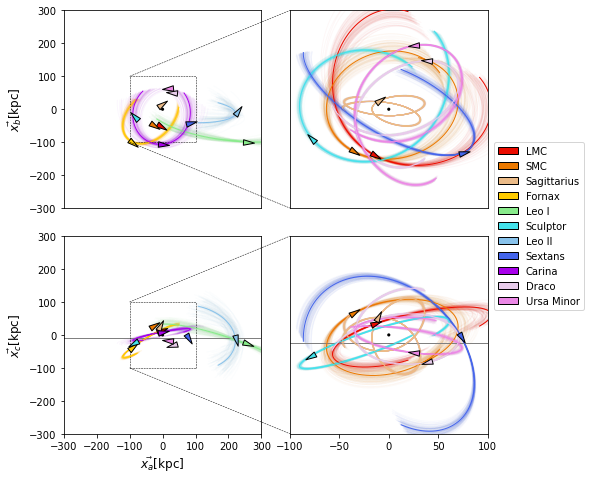

In [13]:
# load the data
orbit_data = np.load("data/MC_orbits"+suffix+".npz", allow_pickle=True)
coords_MC_integrated = orbit_data['coords_MC_integrated']
coords_MC_integrated_future = orbit_data['coords_MC_integrated_future']

# start the plot
fig, ax = plt.subplots(2,2, figsize=(8,8))

ax[0,0].set_rasterization_zorder(1)
ax[0,1].set_rasterization_zorder(1)
ax[1,0].set_rasterization_zorder(1)
ax[1,1].set_rasterization_zorder(1)

use_MC_samples = min ([100, N_MC_samples])

for i in range(0, 11):
    
    print('galaxy', i, ' of ', 11, end='\r')

    for sample in range (use_MC_samples):
        
        # combine the past and future without duplicating the t=0 entry
        x = np.concatenate([np.flip(coords_MC_integrated[sample,i,0,0:-1:10]), coords_MC_integrated_future[sample,i,0,1:-1:10] ])
        y = np.concatenate([np.flip(coords_MC_integrated[sample,i,1,0:-1:10]), coords_MC_integrated_future[sample,i,1,1:-1:10] ])
        z = np.concatenate([np.flip(coords_MC_integrated[sample,i,2,0:-1:10]), coords_MC_integrated_future[sample,i,2,1:-1:10] ])

        # rotate into the eigenvector frame:
        coords_prime =  np.dot(np.array([x,y,z]).T, eigenvectors_ML_z0).T
        xprime = coords_prime[0][:]
        yprime = coords_prime[1][:]
        zprime = coords_prime[2][:]
        
        # outer: Fornax, Leo I, Leo II, Carina
        if i in [3, 4,  6, 8]:
            ax[0,0].plot(xprime, yprime, color = colors_11[i], lw=1., alpha = .03, rasterized=True, zorder=0)
            ax[1,0].plot(xprime, zprime, color = colors_11[i], lw=1., alpha = .03, rasterized=True, zorder=0)
        # inner: LMC, SMC, Sag, Draco, Umi
        if i in [0, 1, 2, 5, 7, 9, 10]: # inner
            ax[0,1].plot(xprime, yprime, color = colors_11[i], lw=1., alpha = .03, rasterized=True, zorder=0)
            ax[1,1].plot(xprime, zprime, color = colors_11[i], lw=1., alpha = .03, rasterized=True, zorder=0)
        
# overplot the default
for i in range(0, 11):
    
    # combine the past and future without duplicating the t=0 entry
    x = np.concatenate([np.flip(coords_ML_integrated_1Gyr[i,0,0:-1:10]), coords_ML_integrated_1Gyr_future[i,0,1:-1:10] ])
    y = np.concatenate([np.flip(coords_ML_integrated_1Gyr[i,1,0:-1:10]), coords_ML_integrated_1Gyr_future[i,1,1:-1:10] ])
    z = np.concatenate([np.flip(coords_ML_integrated_1Gyr[i,2,0:-1:10]), coords_ML_integrated_1Gyr_future[i,2,1:-1:10] ])
    
    # rotate into the eigenvector frame:
    coords_prime =  np.dot(np.array([x,y,z]).T, eigenvectors_ML_z0).T
    xprime = coords_prime[0][:]
    yprime = coords_prime[1][:]
    zprime = coords_prime[2][:]
    
    middle = int(np.floor(len(xprime)/2)) # this is the index for t=0
    
    # rotate into the eigenvector frame:
    vels_prime =  np.dot(np.array([vels_ML[i,0],vels_ML[i,1],vels_ML[i,2]]).T, eigenvectors_ML_z0).T
    vxprime = vels_prime[0] / 100000.
    vyprime = vels_prime[1] / 100000.
    vzprime = vels_prime[2] / 100000.
    
    if i in [3, 4, 6, 8]: # outer
        
        ax[0,0].plot(xprime, yprime, color = colors_11[i], zorder = 10, lw=1)
        ax[1,0].plot(xprime, zprime, color = colors_11[i], zorder = 10, lw=1)
      
        ax[0,0].quiver(xprime[middle], yprime[middle],vxprime,vyprime, edgecolor='black', facecolor=colors_11[i],zorder=15, lw=1., headaxislength=8, headwidth=4, headlength=8, label = satellites_names[i])
        ax[1,0].quiver(xprime[middle], zprime[middle],vxprime,vzprime, edgecolor='black', facecolor=colors_11[i],zorder=15, lw=1., headaxislength=8, headwidth=4, headlength=8, label = satellites_names[i])

    if i in [0, 1, 2, 5, 7, 9, 10]: # inner
        ax[0,1].plot(xprime, yprime, color = colors_11[i], zorder = 10, lw=1)
        ax[1,1].plot(xprime, zprime, color = colors_11[i], zorder = 10, lw=1)
        
        ax[0,1].quiver(xprime[middle], yprime[middle],vxprime,vyprime, edgecolor='black', facecolor=colors_11[i],zorder=15, lw=1., headaxislength=8, headwidth=4, headlength=8, label = satellites_names[i])
        ax[1,1].quiver(xprime[middle], zprime[middle],vxprime,vzprime, edgecolor='black', facecolor=colors_11[i],zorder=15, lw=1., headaxislength=8, headwidth=4, headlength=8, label = satellites_names[i])
        ax[0,0].quiver(xprime[middle], yprime[middle],vxprime,vyprime, edgecolor='black', facecolor=colors_11[i],zorder=15, lw=1., headaxislength=8, headwidth=4, headlength=8, label = satellites_names[i])
        ax[1,0].quiver(xprime[middle], zprime[middle],vxprime,vzprime, edgecolor='black', facecolor=colors_11[i],zorder=15, lw=1., headaxislength=8, headwidth=4, headlength=8, label = satellites_names[i])   
                
# legend and limits to the plot
ax[1,0].legend(loc='lower left', fontsize=10, ncol=1, bbox_to_anchor=(2.15, .6), facecolor='white')

ax[0,0].set_ylabel(r'$\vec{x_b}$[kpc]', fontsize=12)
ax[1,0].set_xlabel(r'$\vec{x_a}$[kpc]', fontsize=12)
ax[1,0].set_ylabel(r'$\vec{x_c}$[kpc]', fontsize=12)

ax[0,0].set_xticks([])
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
ax[1,1].set_yticks([])

ax[0,0].set_xlim(-300, 300)
ax[0,0].set_ylim(-300, 300)
ax[1,0].set_xlim(-300, 300)
ax[1,0].set_ylim(-300, 300)

ax[0,1].set_xlim(-100, 100)
ax[0,1].set_ylim(-100, 100)
ax[1,1].set_xlim(-100, 100)
ax[1,1].set_ylim(-100, 100)

ax[0,0].set_aspect('equal', adjustable='box')
ax[1,0].set_aspect('equal', adjustable='box')
ax[0,1].set_aspect('equal', adjustable='box')
ax[1,1].set_aspect('equal', adjustable='box')

ax[1,0].plot([-300,300],[-8,-8], lw =1, zorder=1, color='grey', ls = 'solid') # overplot the plane
ax[1,1].plot([-100,100],[-8,-8], lw =1, zorder=1, color='grey', ls = 'solid')

ax[0,0].plot([-100,-100],[-100,100], lw =.5, zorder=1, color='black', ls = 'dashed')
ax[0,0].plot([100,100],[-100,100], lw =.5, zorder=1, color='black', ls = 'dashed')
ax[0,0].plot([-100,100],[-100,-100], lw =.5, zorder=1, color='black', ls = 'dashed')
ax[0,0].plot([-100,100],[100,100], lw =.5, zorder=1, color='black', ls = 'dashed')

ax[1,0].plot([-100,-100],[-100,100], lw =.5, zorder=1, color='black', ls = 'dashed')
ax[1,0].plot([100,100],[-100,100], lw =.5, zorder=1, color='black', ls = 'dashed')
ax[1,0].plot([-100,100],[-100,-100], lw =.5, zorder=1, color='black', ls = 'dashed')
ax[1,0].plot([-100,100],[100,100], lw =.5, zorder=1, color='black', ls = 'dashed')

ax[0,0].scatter([0],[0], zorder=1, facecolor='black', edgecolor='none', s=10) # plot the 0,0 marker
ax[0,1].scatter([0],[0], zorder=1, facecolor='black', edgecolor='none', s=10) # plot the 0,0 marker
ax[1,0].scatter([0],[0], zorder=1, facecolor='black', edgecolor='none', s=10) # plot the 0,0 marker
ax[1,1].scatter([0],[0], zorder=1, facecolor='black', edgecolor='none', s=10) # plot the 0,0 marker

#reduce space between panels
xoffset= - 0.03
bbox=ax[1,1].get_position()
ax[1,1].set_position([bbox.x0 + xoffset, bbox.y0, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])
bbox=ax[0,1].get_position()
ax[0,1].set_position([bbox.x0 + xoffset, bbox.y0, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])

#reduce space between panels
yoffset= + 0.02
bbox=ax[1,0].get_position()
ax[1,0].set_position([bbox.x0 , bbox.y0 + yoffset, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])
bbox=ax[1,1].get_position()
ax[1,1].set_position([bbox.x0 , bbox.y0 + yoffset, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])

# overplot the lines for the "magnifying effect" 
transFigure = fig.transFigure.inverted()

coord1 = transFigure.transform(ax[0,0].transData.transform([-97,100]))   # this is a MPL bug - may be -100, 100 in future versions.
coord2 = transFigure.transform(ax[0,1].transData.transform([-100,100]))
line = mpl.lines.Line2D((coord1[0],coord2[0]),(coord1[1],coord2[1]),  transform=fig.transFigure, lw =.5, zorder=1, color='black', ls = 'dashed')
fig.lines.append(line)

coord1 = transFigure.transform(ax[0,0].transData.transform([-97,-100]))
coord2 = transFigure.transform(ax[0,1].transData.transform([-100,-100]))
line = mpl.lines.Line2D((coord1[0],coord2[0]),(coord1[1],coord2[1]),  transform=fig.transFigure, lw =.5, zorder=1, color='black', ls = 'dashed')
fig.lines.append(line)

coord1 = transFigure.transform(ax[1,0].transData.transform([-100,100]))
coord2 = transFigure.transform(ax[1,1].transData.transform([-100,100]))
line = mpl.lines.Line2D((coord1[0],coord2[0]),(coord1[1],coord2[1]),  transform=fig.transFigure, lw =.5, zorder=1, color='black', ls = 'dashed')
fig.lines.append(line)

coord1 = transFigure.transform(ax[1,0].transData.transform([-100,-100]))
coord2 = transFigure.transform(ax[1,1].transData.transform([-100,-100]))
line = mpl.lines.Line2D((coord1[0],coord2[0]),(coord1[1],coord2[1]),  transform=fig.transFigure, lw =.5, zorder=0, color='black', ls = 'dashed')
fig.lines.append(line)


if PMDATA == "DR2-Riley":
    ax[0,0].text(0.1, 0.9, r'DR2 (Riley et al. 2019)', transform=ax[0,0].transAxes  )

if PMDATA == "EDR3-Battaglia":
    ax[0,0].text(0.1, 0.9, r'EDR3 (Battaglia et al. 2022)', transform=ax[0,0].transAxes  )

plt.savefig('plots/orbits_gala_MC_N'+str(max_N)+suffix+'.png', bbox_inches='tight', dpi=200)

print ("\ndone")

## Mollweide Plots of the poles

## Preparation

In [14]:
# Most likely:

pos_ML = np.array(coords_ML)
vel_ML = np.array(vels_ML)

L_ML = np.cross( pos_ML, vel_ML )
L_mag_ML = (L_ML**2).sum(axis=1)**0.5
L_dir_ML = L_ML / L_mag_ML[:,None]

# MC
indexes = [1,  2,   0,   8,   10,  5,   9,  6, 7, 3, 4]  

pos = coords_MC[:,indexes,:]
vel = vels_MC[:,indexes,:]

L = np.cross( pos, vel )
L_mag = (L**2).sum(axis=2)**0.5
L_dir = L / L_mag[:,:,None]

# the uncertainty in orbital pole angle
percentiles = np.array( [68, 95] )
cosAng_uncertainty = np.zeros( (numSats,2), np.float64 )

for i in range( numSats ):
    cosAng_uncertainty[i] = np.percentile( (L_dir_ML[i] * L_dir[:,i]).sum(axis=1), 100-percentiles )

Ang_uncertainty = np.rad2deg( np.arccos(cosAng_uncertainty) )

# print the uncertainties
print( "Orbital poles uncertainties: \t 68\%   \t 95\%" )
for i in range( numSats ):
    print( "%15s \t\t %6.3f \t %6.3f    deg" % (sat_names[indexes[i]], Ang_uncertainty[i,0], Ang_uncertainty[i,1]) )


Orbital poles uncertainties: 	 68\%   	 95\%
            LMC 		  1.315 	  2.627    deg
            SMC 		  1.948 	  3.912    deg
SagittariusdSph 		  0.374 	  0.791    deg
         Fornax 		  0.581 	  1.072    deg
           Leo1 		 10.537 	 19.657    deg
       Sculptor 		  0.395 	  0.762    deg
           Leo2 		 11.064 	 21.819    deg
     Sextans(1) 		  1.076 	  2.310    deg
         Carina 		  1.782 	  3.297    deg
      UrsaMinor 		  0.595 	  1.230    deg
          Draco 		  1.204 	  2.584    deg


## Plot

mean ra: 0.10260846876044395
mean dec: -0.13910349582736808


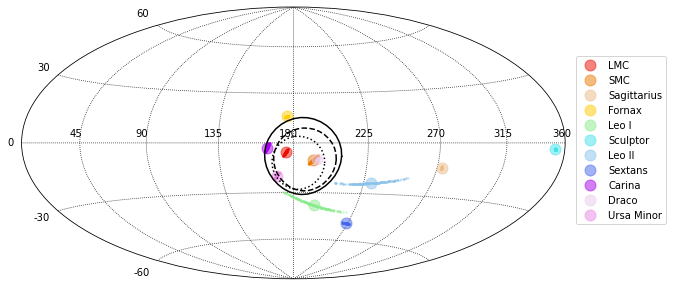

In [15]:
projection = 'hammer'

# offset the RA values to make the plot look nicer
ra_off = 180 * degToRad

fig1 = plt.figure( figsize=(15.,1*5) )
gs = GridSpec( 1, 1 )

# define the x,y,z directions w.r.t. to calculate the angular coordinates
dir_x, dir_y, dir_z = np.array( [1.,0.,0.] ), np.array( [0.,1.,0] ), np.array( [0.,0.,1] )

ax1 = plt.subplot( gs[0], projection = projection )
skyPlotAxes( ax1 )

ra_list = []
dec_list = []

for i in range(11):
    ra, dec = ra_dec( L_dir_ML[i], dir_x, dir_y, dir_z )
    ra = wrap_angle( ra + ra_off, 2*np.pi, -np.pi, np.pi ) 
    
    ra_list.append(ra)
    dec_list.append(dec)

    
    ax1.plot( ra, dec, 'o', ms=11, c=colors_11[i], mew=1, label = satellites_names[i], alpha = .5)

    for j in range (200):
        ra2, dec2 = ra_dec( L_dir[j,i], dir_x, dir_y, dir_z )
        ra2 = wrap_angle( ra2 + ra_off, 2*np.pi, -np.pi, np.pi ) 
        
        # find the MC samples within the 68% confidence region
        cosAng = (L_dir_ML[i] * L_dir[j,i]).sum()
        if (cosAng > cosAng_uncertainty[i,1]):
            ax1.plot( ra2, dec2, '.', ms=3, c=colors_11[i], alpha=0.3, lw=0)

# overplot the 23.2 degree circle - matplotlib's default circle results in a polygon with too few edges:
                
phi = np.linspace(0, 2.*np.pi, 36)  #36 points
    
selection_7_orig = np.array([0, 1, 3, 6, 8, 9, 10]).astype(int) 
selection_7_new = np.array([0, 1, 3, 4, 8, 9, 10]).astype(int) 

ra_list = np.array(ra_list)
dec_list = np.array(dec_list)
    
mean_ra = np.mean(ra_list[selection_7_orig])
mean_dec = np.mean(dec_list[selection_7_orig])

print ("mean ra:", mean_ra)
print ("mean dec:", mean_dec)

# original set of 7, 23.2 degrees

phi = np.linspace(0, 2.*np.pi, 36)  #36 points
r = np.radians(23.2)
x = mean_ra + r*np.cos(phi)
y = mean_dec + r*np.sin(phi)
ax1.plot(x, y, color='black', alpha= 1., ls = 'solid')#, fill=True)

# original set of 7, 16 degrees

phi = np.linspace(0, 2.*np.pi, 36)  #36 points
r = np.radians(16.0)
x = np.radians(3) + r*np.cos(phi)
y = np.radians(-12) + r*np.sin(phi)
ax1.plot(x, y, color='black', alpha= 1., ls = 'dotted')#, fill=True)

# new set of 7, 18.93 degrees

mean_ra = np.mean(ra_list[selection_7_new])
mean_dec = np.mean(dec_list[selection_7_new])

phi = np.linspace(0, 2.*np.pi, 36)  #36 points
r = np.radians(18.93)
x = np.radians(7) + r*np.cos(phi)
y = np.radians(-10) + r*np.sin(phi)
ax1.plot(x, y, color='black', alpha= 1.0, ls = 'dashed')#, fill=True)

ax1.set_xticks( np.linspace(-180*degToRad, 180*degToRad,9)[1:] -.05 )
ax1.set_xticklabels( np.linspace(0, 360,9).astype(int)[1:] )

plt.legend( loc=(1.02,0.2) )

plt.savefig('poles_'+projection+'_N'+str(max_N)+'.pdf', bbox_inches='tight', dpi=200)


## Show how the plane follows the positions of the most distant satellites (supplementary information)
### To show the evolution of the plane, we plot the plane and the positions and orbits at different times, in the edge-on projection defined by the major and minor eigenvectors at z=0.

time bin: 0
xprime: [ 0.85623365  0.41533198 -0.30718607]
yprime: [-0.26158698  0.86135854  0.43546953]
zprime: [ 0.44546176 -0.2925078   0.84616961]
time bin: 250
xprime: [ 0.85803903  0.41328602 -0.30489946]
yprime: [-0.26686428  0.86600978  0.42285993]
zprime: [ 0.43880801 -0.28146355  0.85336147]
time bin: 500
xprime: [ 0.8594272  -0.41287339 -0.30153017]
yprime: [-0.27440787 -0.87014319  0.40933012]
zprime: [0.43137594 0.26904719 0.86112044]
time bin: 750
xprime: [ 0.86091739 -0.4128338  -0.29730373]
yprime: [-0.28258702 -0.87399434  0.39532073]
zprime: [0.42304353 0.25632431 0.86909839]
time bin: 998
xprime: [ 0.86285893 -0.41218725 -0.292534  ]
yprime: [-0.29001378 -0.8777581   0.38135644]
zprime: [0.41396435 0.24421792 0.87692139]

done


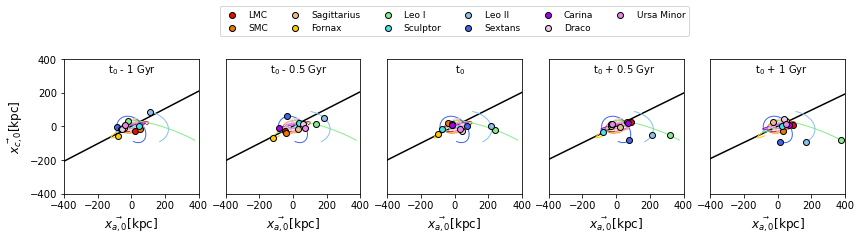

In [16]:
%matplotlib inline

# load the data
orbit_data = np.load("data/MC_orbits"+suffix+".npz", allow_pickle=True)
coords_MC_integrated = orbit_data['coords_MC_integrated']
coords_MC_integrated_future = orbit_data['coords_MC_integrated_future']

# start the plot
fig, ax = plt.subplots(1,5, figsize=(14,4))

ax[0].set_rasterization_zorder(1)
ax[1].set_rasterization_zorder(1)
ax[2].set_rasterization_zorder(1)
ax[3].set_rasterization_zorder(1)
ax[4].set_rasterization_zorder(1)

# Plot the orbits and positions of the satellites on all panels:

for i in range(0, 11):
    
    # combine the past and future without duplicating the t=0 entry
    x = np.concatenate([np.flip(coords_ML_integrated_1Gyr[i,0,0:-1:10]), coords_ML_integrated_1Gyr_future[i,0,1:-1:10] ])
    y = np.concatenate([np.flip(coords_ML_integrated_1Gyr[i,1,0:-1:10]), coords_ML_integrated_1Gyr_future[i,1,1:-1:10] ])
    z = np.concatenate([np.flip(coords_ML_integrated_1Gyr[i,2,0:-1:10]), coords_ML_integrated_1Gyr_future[i,2,1:-1:10] ])
    
    # rotate into the eigenvector frame:
    coords_prime =  np.dot(np.array([x,y,z]).T, eigenvectors_ML_z0).T
    xprime = coords_prime[0][:]
    yprime = coords_prime[1][:]
    zprime = coords_prime[2][:]

    first = 0 # this is the index for t=0
    second = int(np.floor(len(xprime)*1/4)) # this is the index for t=0
    middle = int(np.floor(len(xprime)/2)) # this is the index for t=0
    third = int(np.floor(len(xprime)*3/4)) # this is the index for t=0
    fourth = int(np.floor(len(xprime)))-1 # this is the index for t=0

        
    ax[0].plot(xprime, zprime, color = colors_11[i], zorder = 10, lw=1)
    ax[1].plot(xprime, zprime, color = colors_11[i], zorder = 10, lw=1)
    ax[2].plot(xprime, zprime, color = colors_11[i], zorder = 10, lw=1)
    ax[3].plot(xprime, zprime, color = colors_11[i], zorder = 10, lw=1)
    ax[4].plot(xprime, zprime, color = colors_11[i], zorder = 10, lw=1)

    ax[0].scatter(xprime[first], zprime[first], edgecolor='black', facecolor=colors_11[i],zorder=15, lw=1.)
    ax[1].scatter(xprime[second], zprime[second], edgecolor='black', facecolor=colors_11[i],zorder=15, lw=1.)
    ax[2].scatter(xprime[middle], zprime[middle], edgecolor='black', facecolor=colors_11[i],zorder=15, lw=1.)
    ax[3].scatter(xprime[third], zprime[third], edgecolor='black', facecolor=colors_11[i],zorder=15, lw=1.)
    ax[4].scatter(xprime[fourth], zprime[fourth], edgecolor='black', facecolor=colors_11[i],zorder=15, lw=1. ,  label = satellites_names[i])

# Now, compute the eigenvectors and plot the plane in the frame of the z=0 eigenvectors:

# combine the past and future without duplicating the t=0 entry
x_ML = np.concatenate([np.flip(coords_ML_integrated_1Gyr[:,0,0:-1]), coords_ML_integrated_1Gyr_future[:,0,1:-1] ], axis=1)
y_ML = np.concatenate([np.flip(coords_ML_integrated_1Gyr[:,1,0:-1]), coords_ML_integrated_1Gyr_future[:,1,1:-1] ], axis=1)
z_ML = np.concatenate([np.flip(coords_ML_integrated_1Gyr[:,2,0:-1]), coords_ML_integrated_1Gyr_future[:,2,1:-1] ], axis=1)


for i in range (5):
     
    timebin = i * 250 
    
    if timebin == 1000:
        timebin = 998
        
    x = x_ML[:,timebin]
    y = y_ML[:,timebin]
    z = z_ML[:,timebin]
    
    r_gal = np.sqrt(x*x + y*y + z*z)
    
    coords_ML_z = np.transpose([x, y, z])
    eigenvalues_ML, eigenvectors_ML = inertiatensor(coords_ML_z)
    
    coords_prime =  np.dot(eigenvectors_ML.T, eigenvectors_ML_z0).T
    xprime = coords_prime[0][:]
    yprime = coords_prime[1][:]
    zprime = coords_prime[2][:]

    print ("time bin:", timebin)
    print ("xprime:", xprime)
    print ("yprime:", yprime)
    print ("zprime:", zprime)
    
    ax[i].plot([xprime[0]*-1000,xprime[0]*1000], [zprime[0]*-1000, zprime[0]*1000], color = 'black')

# legend and limits to the plot
fig.legend(loc='lower left', fontsize=9, ncol=6, bbox_to_anchor=(.275, .8), facecolor='white')

ax[0].set_xlabel(r'$\vec{x_{a,0}}$[kpc]', fontsize=12)
ax[1].set_xlabel(r'$\vec{x_{a,0}}$[kpc]', fontsize=12)
ax[2].set_xlabel(r'$\vec{x_{a,0}}$[kpc]', fontsize=12)
ax[3].set_xlabel(r'$\vec{x_{a,0}}$[kpc]', fontsize=12)
ax[4].set_xlabel(r'$\vec{x_{a,0}}$[kpc]', fontsize=12)

ax[0].set_ylabel(r'$\vec{x_{c,0}}$[kpc]', fontsize=12)

ax[1].set_yticks([])
ax[2].set_yticks([])
ax[3].set_yticks([])
ax[4].set_yticks([])

ax[0].set_xlim(-400, 400)
ax[0].set_ylim(-400, 400)
ax[1].set_xlim(-400, 400)
ax[1].set_ylim(-400, 400)
ax[2].set_xlim(-400, 400)
ax[2].set_ylim(-400, 400)
ax[3].set_xlim(-400, 400)
ax[3].set_ylim(-400, 400)
ax[4].set_xlim(-400, 400)
ax[4].set_ylim(-400, 400)

ax[0].text(0.33, 0.9, r't$_0$ - 1 Gyr', transform=ax[0].transAxes  )
ax[1].text(0.33, 0.9, r't$_0$ - 0.5 Gyr', transform=ax[1].transAxes  )
ax[2].text(0.5, 0.9, r't$_0$', transform=ax[2].transAxes  )
ax[3].text(0.33, 0.9, r't$_0$ + 0.5 Gyr', transform=ax[3].transAxes  )
ax[4].text(0.33, 0.9, r't$_0$ + 1 Gyr', transform=ax[4].transAxes  )


ax[0].set_aspect('equal', adjustable='box')
ax[1].set_aspect('equal', adjustable='box')
ax[2].set_aspect('equal', adjustable='box')
ax[3].set_aspect('equal', adjustable='box')
ax[4].set_aspect('equal', adjustable='box')

if PMDATA == "DR2-Riley":
    ax[0].text(0.1, 1.05, r'DR2 (Riley et al. 2019)', transform=ax[0].transAxes  )

if PMDATA == "EDR3-Battaglia":
    ax[0].text(0.1, 1.05, r'EDR3 (Battaglia et al. 2022)', transform=ax[0].transAxes  )


plt.savefig('plots/orbits_gala_plane_evolution'+suffix+'.pdf',  bbox_inches='tight', dpi=200)

print ("\ndone")

## Plot the evolution of $c/a$, $(c/a)_\mathrm{red}$, $\delta(\vec{x_c})$ and $\delta(\vec{x_{c,\mathrm{red}}})$ in different halo mass potentials. (supplementary information)

## Plot the evolution of $c/a$, $(c/a)_\mathrm{red}$, $\delta(\vec{x_c})$ and $\delta(\vec{x_{c,\mathrm{red}}})$ in the default potential, Monte-Carlo sampling the orbits.

## Plot the evolution of $c/a$, $(c/a)_\mathrm{red}$, $\delta(\vec{x_c})$ and $\delta(\vec{x_{c,\mathrm{red}}})$ in the default potential, Monte-Carlo sampling the orbits, and overplot the simulation median and range (_Figure 4_).

beginning to add the simulation data
min and max time: 0.0 1.3357658308174987

done


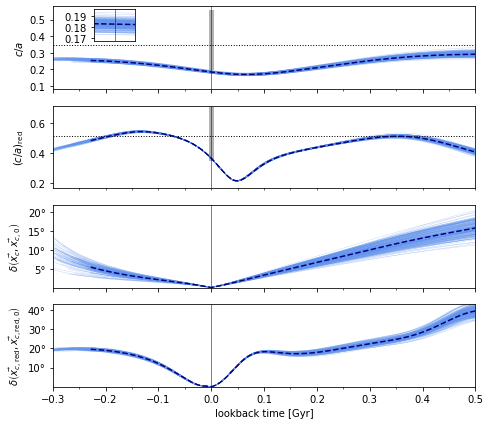

In [17]:
fig = plt.figure(figsize=(10, 7))
gs = GridSpec(nrows=4, ncols=2, width_ratios=[25,5], height_ratios=[1,1,1,1])

ax0 = fig.add_subplot(gs[0, 0]) # c/a
ax1 = fig.add_subplot(gs[1, 0]) # c/a reduced
ax2 = fig.add_subplot(gs[2, 0]) # orientation
ax3 = fig.add_subplot(gs[3, 0]) # orientation (reduced)

ax0_inset =  fig.add_subplot(gs[0, 1]) # c/a, inset

orbit_data = np.load("data/MC_orbits"+suffix+".npz", allow_pickle=True)
coords_MC_integrated = orbit_data['coords_MC_integrated']
coords_MC_integrated_future = orbit_data['coords_MC_integrated_future']

use_MC_samples = min ([200, N_MC_samples])

for MC_sample in range (use_MC_samples): 
    
    print('MC_sample', MC_sample, ' of ', use_MC_samples, end='\r')

    ca_list = []
    ca_reduced_list = []
    angle_list = []
    angle_reduced_list = []
    escaped = []
    
    # combine the past and future without duplicating the t=0 entry
    x_sample = np.concatenate([np.flip(coords_MC_integrated[MC_sample,:,0,0:-1]), coords_MC_integrated_future[MC_sample,:,0,1:-1] ], axis=1)
    y_sample = np.concatenate([np.flip(coords_MC_integrated[MC_sample,:,1,0:-1]), coords_MC_integrated_future[MC_sample,:,1,1:-1] ], axis=1)
    z_sample = np.concatenate([np.flip(coords_MC_integrated[MC_sample,:,2,0:-1]), coords_MC_integrated_future[MC_sample,:,2,1:-1] ], axis=1)
   
    N_points = x_sample.shape[1]
    middle = int(np.floor(N_points/2)) # this is the index for t=0
    
    # get the z=0 values
    x_z0 = x_sample[:,middle]
    y_z0 = y_sample[:,middle]
    z_z0 = z_sample[:,middle]
    
    # compute the eigenvectors at z=0 for reference for the rotation 
    coords_sample_z0 = np.transpose([x_z0, y_z0, z_z0])
    eigenvalues_sample_z0, eigenvectors_sample_z0 = inertiatensor(coords_sample_z0)
    eigenvalues_reduced_sample_z0, eigenvectors_reduced_sample_z0 = inertiatensor_reduced(coords_sample_z0)
    
    for timebin in range (N_points-1,-1,-1):   # we want the past on the right
        x = x_sample[:,timebin]
        y = y_sample[:,timebin]
        z = z_sample[:,timebin]
 
        r_gal = np.sqrt(x*x+ y*y+ z*z)

        coords_sample = np.transpose([x,y,z])
        eigenvalues_sample, eigenvectors_sample = inertiatensor(coords_sample)
        eigenvalues_reduced_sample, eigenvectors_reduced_sample = inertiatensor_reduced(coords_sample)

        dot_product = np.dot(eigenvectors_sample[:,2], eigenvectors_sample_z0[:,2]) - 1.e-10
        angle_list.append(min (np.arccos(dot_product), np.pi - np.arccos(dot_product))*180. / np.pi )

        dot_product = np.dot(eigenvectors_reduced_sample[:,2], eigenvectors_reduced_sample_z0[:,2]) - 1.e-10
        angle_reduced_list.append(min (np.arccos(dot_product), np.pi - np.arccos(dot_product))*180. / np.pi )
        
        ca_list.append(eigenvalues_sample[2]/eigenvalues_sample[0])
        ca_reduced_list.append(eigenvalues_reduced_sample[2]/eigenvalues_reduced_sample[0])
    
        if max(r_gal) > 300. : # at least one satellite has escaped
            escaped.append(1)
        else:
            escaped.append(0)
        
    ca_list = np.array(ca_list)
    ca_reduced_list = np.array(ca_reduced_list)
    angle_list = np.array(angle_list)
    angle_reduced_list = np.array(angle_reduced_list)
    
    escaped = np.array(escaped)
    selection = np.where(escaped == 0)
    
    ax0.plot(times_MC[selection], ca_list[selection], color = 'cornflowerblue', lw = .4, alpha = .4, zorder = 2)
    ax0_inset.plot(times_MC[selection], ca_list[selection], color = 'cornflowerblue', lw = .4, alpha = .4, zorder = 2)

    ax1.plot(times_MC[selection], ca_reduced_list[selection], color = 'cornflowerblue', lw = .4, alpha = .4, zorder = 2)
   
    ax2.plot(times_MC[selection], angle_list[selection], color = 'cornflowerblue', lw = .4, alpha = .4, zorder = 2)
    ax3.plot(times_MC[selection], angle_reduced_list[selection], color = 'cornflowerblue', lw = .4, alpha = .4, zorder = 2)
    
# overplot the default

# combine the past and future without duplicating the t=0 entry
x_ML = np.concatenate([np.flip(coords_ML_integrated_1Gyr[:,0,0:-1]), coords_ML_integrated_1Gyr_future[:,0,1:-1] ], axis=1)
y_ML = np.concatenate([np.flip(coords_ML_integrated_1Gyr[:,1,0:-1]), coords_ML_integrated_1Gyr_future[:,1,1:-1] ], axis=1)
z_ML = np.concatenate([np.flip(coords_ML_integrated_1Gyr[:,2,0:-1]), coords_ML_integrated_1Gyr_future[:,2,1:-1] ], axis=1)

ca_list = []
ca_reduced_list = []
angle_list = []
angle_reduced_list = []
escaped = []

N_points = x_ML.shape[1]
middle = int(np.floor(N_points/2)) # this is the index for t=0

# get the z=0 values
x_z0 = x_ML[:,middle]
y_z0 = y_ML[:,middle]
z_z0 = z_ML[:,middle]
    
# compute the eigenvectors at z=0 for reference for the rotation 
coords_ML_z0 = np.transpose([x_z0, y_z0, z_z0])
eigenvalues_ML_z0, eigenvectors_ML_z0 = inertiatensor(coords_ML_z0)
eigenvalues_reduced_ML_z0, eigenvectors_reduced_ML_z0 = inertiatensor_reduced(coords_ML_z0)

for timebin in range (N_points-1,-1,-1):   # we want the future on the right
     
    x = x_ML[:,timebin]
    y = y_ML[:,timebin]
    z = z_ML[:,timebin]
    
    r_gal = np.sqrt(x*x + y*y + z*z)
    
    coords_ML_z = np.transpose([x, y, z])
    eigenvalues_ML, eigenvectors_ML = inertiatensor(coords_ML_z)
    
    eigenvalues_reduced_ML, eigenvectors_reduced_ML = inertiatensor_reduced(coords_ML_z)

    # angle between the vector normal to the plane at z=0 and at this time
    dot_product = np.dot(eigenvectors_ML[:,2], eigenvectors_ML_z0[:,2]) - 1.e-10
    angle_list.append(min (np.arccos(dot_product), np.pi - np.arccos(dot_product))*180. / np.pi )

    dot_product = np.dot(eigenvectors_reduced_ML[:,2], eigenvectors_reduced_ML_z0[:,2]) - 1.e-10
    angle_reduced_list.append(min (np.arccos(dot_product), np.pi - np.arccos(dot_product))*180. / np.pi )
        
    ca_list.append(eigenvalues_ML[2]/eigenvalues_ML[0])
    ca_reduced_list.append(eigenvalues_reduced_ML[2]/eigenvalues_reduced_ML[0])
    
    if max(r_gal) > 300. : # at least one satellite has escaped
        escaped.append(1)
    else:
        escaped.append(0)

escaped = np.array(escaped)
selection = np.where(escaped == 0)
    
ca_list = np.array(ca_list)
ca_reduced_list = np.array(ca_reduced_list)
angle_list = np.array(angle_list)
angle_reduced_list = np.array(angle_reduced_list)

ax0.plot(times[selection], ca_list[selection], color = 'navy', lw = 1.5, alpha = 1, ls = 'dashed', zorder = 200)
ax0_inset.plot(times[selection], ca_list[selection], color = 'navy', lw = 1.5, alpha = 1, ls = 'dashed', zorder = 200)

ax1.plot(times[selection], ca_reduced_list[selection], color = 'navy', lw = 1.5, alpha = 1, ls = 'dashed', zorder = 200)

ax2.plot(times[selection], angle_list[selection], color = 'navy', lw = 1.5, alpha = 1, ls = 'dashed', zorder = 200)
ax3.plot(times[selection], angle_reduced_list[selection], color = 'navy', lw = 1.5, alpha = 1, ls = 'dashed', zorder = 200)

# Overplot the simulation data:

print ("beginning to add the simulation data")

# we need to interpolate the orbits of the systems we want to plot
time_fine = np.linspace(0., 1., num = N_interpolation_points, endpoint=True)

ca_z0 = []                # we use these to overplot the 1 sigma and 2 sigma bands
ca_reduced_z0 = []

# time range for interpolation
time = cosmo.lookback_time(z=Redshifts).value
if Verbatim: print ("min and max time:", min(time), max(time))

for i, this_num in enumerate(sim_num):

    # allocate arrays that will hold the quantities we follow
    c_over_a = np.zeros(N_interpolation_points)
    c_over_a_reduced = np.zeros(N_interpolation_points)
    angle = np.zeros(N_interpolation_points)
    angle_reduced = np.zeros(N_interpolation_points)

    # z=0:
    x = satellite_coordinates[i][0,:, 0] - MW_coordinates[i][0,0]
    y = satellite_coordinates[i][0,:, 1] - MW_coordinates[i][1,0]
    z = satellite_coordinates[i][0,:, 2] - MW_coordinates[i][2,0]

    coords = np.transpose(np.array([x, y, z]))
    eigenvalues_z0, eigenvectors_z0 = inertiatensor(coords)
    eigenvalues_reduced_z0, eigenvectors_reduced_z0 = inertiatensor_reduced(coords)

    ca_z0.append(eigenvalues_z0[2] / eigenvalues_z0[0])
    ca_reduced_z0.append(eigenvalues_reduced_z0[2] / eigenvalues_reduced_z0[0])

# mark out z=0                                                         
ax0.axvline(x=0, ls = 'solid', lw = .5, color = 'black')
ax1.axvline(x=0, ls = 'solid', lw = .5, color = 'black')
ax2.axvline(x=0, ls = 'solid', lw = .5, color = 'black')
ax3.axvline(x=0, ls = 'solid', lw = .5, color = 'black')
ax0_inset.axvline(x=0, ls = 'solid', lw = .5, color = 'black')

# overplot the 10th and 90th percentile and label them.
ca_z0 = np.array(ca_z0)
ca_reduced_z0 =	np.array(ca_reduced_z0)

percentile10 = np.percentile(ca_z0, 10)
percentile50 = np.percentile(ca_z0, 50)
percentile90 = np.percentile(ca_z0, 90)

ax0.plot([0,0],[percentile10,percentile90], ls = 'solid', lw = 5, alpha=.3, color='black')
ax0.axhline(y=percentile50, ls = 'dotted', lw = 1, alpha=1., color='black')

percentile10 = np.percentile(ca_reduced_z0, 10)
percentile50 = np.percentile(ca_reduced_z0, 50)
percentile90 = np.percentile(ca_reduced_z0, 90)

ax1.axhline(y=percentile50, ls = 'dotted', lw = 1, alpha=1., color='black')
ax1.plot([0,0],[percentile10,percentile90], ls = 'solid', lw = 5, alpha=.3, color='black')

# labels and limits for the axes
ax0.set_xlim([-.3,.5])
ax1.set_xlim([-.3,.5])
ax2.set_xlim([-.3,.5])
ax3.set_xlim([-.3,.5])

ax0.set_yticks([0.1, 0.2, 0.3, 0.4, 0.5])

ax2.set_ylabel(r'$\delta\left(\vec{x_c}, \vec{x_c}_{,0}\right)$')
ax2.set_ylim([0, 22])
ax2.set_yticks([5, 10, 15, 20])
ax2.set_yticklabels(['5°', '10°', '15°', '20°'])
    
ax3.set_ylabel(r'$\delta\left(\vec{x_c}_{,\mathrm{red}}, \vec{x_c}_{,\mathrm{red},0}\right)$')
ax3.set_ylim([0, 43])
ax3.set_yticks([10, 20, 30, 40])
ax3.set_yticklabels(['10°', '20°', '30°', '40°'])
 
ax0.set_xticklabels([])
ax1.set_xticklabels([])
ax2.set_xticklabels([])

minor_locator = mpl.ticker.AutoMinorLocator(2)
ax0.xaxis.set_minor_locator(minor_locator)
ax1.xaxis.set_minor_locator(minor_locator)
ax2.xaxis.set_minor_locator(minor_locator)
ax3.xaxis.set_minor_locator(minor_locator)


ax0.set_ylabel(r'$c/a$')
ax0.set_ylim([0.08, .58])
ax1.set_xlabel('')
ax1.set_xticks([])
ax1.set_ylabel(r'$(c/a)_\mathrm{red}$')
    
ax3.set_xlabel('lookback time [Gyr]')

# labels and limits for the axes
ax0_inset.set_xlim([-0.001, 0.001])    
ax0_inset.set_ylim([0.167, 0.197])
ax0_inset.set_xticks([])

# move the inset on top of the plot
xoffset = - 0.6
yoffset = + 0.095
yshrink = 0.1
xshrink = 0.06
bbox=ax0_inset.get_position()
ax0_inset.set_position([bbox.x0 + xoffset , bbox.y0 + yoffset, bbox.x1 - bbox.x0 - xshrink, bbox.y1 - bbox.y0 - yshrink])


if PMDATA == "DR2-Riley":
    ax0.text(0.5, 0.8, r'DR2 (Riley et al. 2019)', transform=ax0.transAxes  )

if PMDATA == "EDR3-Battaglia":
    ax0.text(0.5, 0.8, r'EDR3 (Battaglia et al. 2022)', transform=ax0.transAxes  )

plt.savefig('plots/evolution_MC_N'+str(max_N)+suffix+'.pdf', bbox_inches='tight', dpi=200)

print ('\ndone')


## Plot just the evolution of c/a and c/a reduced, for comparison of DR2, EDR3-McConnachie and EDR3-Battaglia (supplementary information)

MC_sample 49  of  50
done


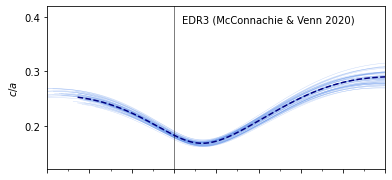

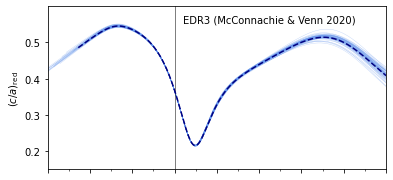

In [18]:
fig = plt.figure(figsize=(8, 3))
gs = GridSpec(nrows=1, ncols=2, width_ratios=[25,5], height_ratios=[1])

ax0 = fig.add_subplot(gs[0]) # c/a

orbit_data = np.load("data/MC_orbits"+suffix+".npz", allow_pickle=True)
coords_MC_integrated = orbit_data['coords_MC_integrated']
coords_MC_integrated_future = orbit_data['coords_MC_integrated_future']

use_MC_samples = min ([50, N_MC_samples])

for MC_sample in range (use_MC_samples): 
    
    print('MC_sample', MC_sample, ' of ', use_MC_samples, end='\r')

    ca_list = []
    escaped = []
    
    # combine the past and future without duplicating the t=0 entry
    x_sample = np.concatenate([np.flip(coords_MC_integrated[MC_sample,:,0,0:-1]), coords_MC_integrated_future[MC_sample,:,0,1:-1] ], axis=1)
    y_sample = np.concatenate([np.flip(coords_MC_integrated[MC_sample,:,1,0:-1]), coords_MC_integrated_future[MC_sample,:,1,1:-1] ], axis=1)
    z_sample = np.concatenate([np.flip(coords_MC_integrated[MC_sample,:,2,0:-1]), coords_MC_integrated_future[MC_sample,:,2,1:-1] ], axis=1)
   
    N_points = x_sample.shape[1]
    middle = int(np.floor(N_points/2)) # this is the index for t=0
    
    # get the z=0 values
    x_z0 = x_sample[:,middle]
    y_z0 = y_sample[:,middle]
    z_z0 = z_sample[:,middle]
    
    # compute the eigenvectors at z=0 for reference for the rotation 
    coords_sample_z0 = np.transpose([x_z0, y_z0, z_z0])
    eigenvalues_sample_z0, eigenvectors_sample_z0 = inertiatensor(coords_sample_z0)
    
    for timebin in range (N_points-1,-1,-1):   # we want the past on the right
        x = x_sample[:,timebin]
        y = y_sample[:,timebin]
        z = z_sample[:,timebin]
 
        r_gal = np.sqrt(x*x+ y*y+ z*z)

        coords_sample = np.transpose([x,y,z])
        eigenvalues_sample, eigenvectors_sample = inertiatensor(coords_sample)
        
        ca_list.append(eigenvalues_sample[2]/eigenvalues_sample[0])
    
        if max(r_gal) > 300. : # at least one satellite has escaped
            escaped.append(1)
        else:
            escaped.append(0)
        
    ca_list = np.array(ca_list)
    
    escaped = np.array(escaped)
    selection = np.where(escaped == 0)
    
    ax0.plot(times_MC[selection], ca_list[selection], color = lightcolor, lw = .4, alpha = .4, zorder = 2)
    ax0_inset.plot(times_MC[selection], ca_list[selection], color = lightcolor, lw = .4, alpha = .4, zorder = 2)
   
# overplot the default

# combine the past and future without duplicating the t=0 entry
x_ML = np.concatenate([np.flip(coords_ML_integrated_1Gyr[:,0,0:-1]), coords_ML_integrated_1Gyr_future[:,0,1:-1] ], axis=1)
y_ML = np.concatenate([np.flip(coords_ML_integrated_1Gyr[:,1,0:-1]), coords_ML_integrated_1Gyr_future[:,1,1:-1] ], axis=1)
z_ML = np.concatenate([np.flip(coords_ML_integrated_1Gyr[:,2,0:-1]), coords_ML_integrated_1Gyr_future[:,2,1:-1] ], axis=1)

ca_list = []
escaped = []

N_points = x_ML.shape[1]
middle = int(np.floor(N_points/2)) # this is the index for t=0

# get the z=0 values
x_z0 = x_ML[:,middle]
y_z0 = y_ML[:,middle]
z_z0 = z_ML[:,middle]
    
# compute the eigenvectors at z=0 for reference for the rotation 
coords_ML_z0 = np.transpose([x_z0, y_z0, z_z0])
eigenvalues_ML_z0, eigenvectors_ML_z0 = inertiatensor(coords_ML_z0)

for timebin in range (N_points-1,-1,-1):   # we want the future on the right
     
    x = x_ML[:,timebin]
    y = y_ML[:,timebin]
    z = z_ML[:,timebin]
    
    r_gal = np.sqrt(x*x + y*y + z*z)
    
    coords_ML_z = np.transpose([x, y, z])
    eigenvalues_ML, eigenvectors_ML = inertiatensor(coords_ML_z)
        
    ca_list.append(eigenvalues_ML[2]/eigenvalues_ML[0])
    
    if max(r_gal) > 300. : # at least one satellite has escaped
        escaped.append(1)
    else:
        escaped.append(0)

ca_list = np.array(ca_list)

escaped = np.array(escaped)
selection = np.where(escaped == 0)

ax0.plot(times[selection], ca_list[selection], color = darkcolor, lw = 1.5, alpha = 1, ls = 'dashed', zorder = 200)

# mark out z=0                                                         
ax0.axvline(x=0, ls = 'solid', lw = .5, color = 'black')
ax0_inset.axvline(x=0, ls = 'solid', lw = .5, color = 'black')


# labels and limits for the axes
ax0.set_xlim([-.3,.5])

ax0.set_yticks([0.1, 0.2, 0.3, 0.4, 0.5])

minor_locator = mpl.ticker.AutoMinorLocator(2)
ax0.xaxis.set_minor_locator(minor_locator)
ax0.set_ylabel(r'$c/a$')
ax0.set_ylim([0.12, .42])

if PMDATA == "EDR3-McConnachie":
    ax0.text(0.4, 0.9, r'EDR3 (McConnachie & Venn 2020)', transform=ax0.transAxes  )
    ax0.set_xticklabels([])
    ax0.set_xlabel('') 
    
if PMDATA == "EDR3-Battaglia":
    ax0.text(0.4, 0.9, r'EDR3 (Battaglia et al. 2022)', transform=ax0.transAxes  )
    ax0.set_xticklabels([])
    ax0.set_xlabel('')
    
if PMDATA == "DR2-Riley":
    ax0.text(0.4, 0.9, r'DR2 (Riley et al. 2019)', transform=ax0.transAxes  )
    ax0.set_xlabel('lookback time [Gyr]')
    
plt.savefig('plots/evolution_MC_ca_N'+str(max_N)+suffix+'.pdf', bbox_inches='tight', dpi=200)


# c/a reduced

fig = plt.figure(figsize=(8, 3))
gs = GridSpec(nrows=1, ncols=2, width_ratios=[25,5], height_ratios=[1])

ax0 = fig.add_subplot(gs[0, 0]) # c/a

orbit_data = np.load("data/MC_orbits"+suffix+".npz", allow_pickle=True)
coords_MC_integrated = orbit_data['coords_MC_integrated']
coords_MC_integrated_future = orbit_data['coords_MC_integrated_future']

use_MC_samples = min ([50, N_MC_samples])

for MC_sample in range (use_MC_samples): 
    
    print('MC_sample', MC_sample, ' of ', use_MC_samples, end='\r')

    ca_reduced_list = []
    escaped = []
    
    # combine the past and future without duplicating the t=0 entry
    x_sample = np.concatenate([np.flip(coords_MC_integrated[MC_sample,:,0,0:-1]), coords_MC_integrated_future[MC_sample,:,0,1:-1] ], axis=1)
    y_sample = np.concatenate([np.flip(coords_MC_integrated[MC_sample,:,1,0:-1]), coords_MC_integrated_future[MC_sample,:,1,1:-1] ], axis=1)
    z_sample = np.concatenate([np.flip(coords_MC_integrated[MC_sample,:,2,0:-1]), coords_MC_integrated_future[MC_sample,:,2,1:-1] ], axis=1)
   
    N_points = x_sample.shape[1]
    middle = int(np.floor(N_points/2)) # this is the index for t=0
    
    # get the z=0 values
    x_z0 = x_sample[:,middle]
    y_z0 = y_sample[:,middle]
    z_z0 = z_sample[:,middle]
    
    # compute the eigenvectors at z=0 for reference for the rotation 
    coords_sample_z0 = np.transpose([x_z0, y_z0, z_z0])
    eigenvalues_reduced_sample_z0, eigenvectors_reduced_sample_z0 = inertiatensor_reduced(coords_sample_z0)
    
    for timebin in range (N_points-1,-1,-1):   # we want the past on the right
        x = x_sample[:,timebin]
        y = y_sample[:,timebin]
        z = z_sample[:,timebin]
 
        r_gal = np.sqrt(x*x+ y*y+ z*z)

        coords_sample = np.transpose([x,y,z])
        eigenvalues_reduced_sample, eigenvectors_reduced_sample = inertiatensor_reduced(coords_sample)
        
        ca_reduced_list.append(eigenvalues_reduced_sample[2]/eigenvalues_reduced_sample[0])
    
        if max(r_gal) > 300. : # at least one satellite has escaped
            escaped.append(1)
        else:
            escaped.append(0)
        
    ca_reduced_list = np.array(ca_reduced_list)
    
    escaped = np.array(escaped)
    selection = np.where(escaped == 0)
    
    ax0.plot(times_MC[selection], ca_reduced_list[selection], color = lightcolor, lw = .4, alpha = .4, zorder = 2)
   
# overplot the default

# combine the past and future without duplicating the t=0 entry
x_ML = np.concatenate([np.flip(coords_ML_integrated_1Gyr[:,0,0:-1]), coords_ML_integrated_1Gyr_future[:,0,1:-1] ], axis=1)
y_ML = np.concatenate([np.flip(coords_ML_integrated_1Gyr[:,1,0:-1]), coords_ML_integrated_1Gyr_future[:,1,1:-1] ], axis=1)
z_ML = np.concatenate([np.flip(coords_ML_integrated_1Gyr[:,2,0:-1]), coords_ML_integrated_1Gyr_future[:,2,1:-1] ], axis=1)

ca_list = []
ca_reduced_list = []
escaped = []

N_points = x_ML.shape[1]
middle = int(np.floor(N_points/2)) # this is the index for t=0

# get the z=0 values
x_z0 = x_ML[:,middle]
y_z0 = y_ML[:,middle]
z_z0 = z_ML[:,middle]
    
# compute the eigenvectors at z=0 for reference for the rotation 
coords_ML_z0 = np.transpose([x_z0, y_z0, z_z0])
eigenvalues_ML_z0, eigenvectors_ML_z0 = inertiatensor(coords_ML_z0)
eigenvalues_reduced_ML_z0, eigenvectors_reduced_ML_z0 = inertiatensor_reduced(coords_ML_z0)

for timebin in range (N_points-1,-1,-1):   # we want the future on the right
     
    x = x_ML[:,timebin]
    y = y_ML[:,timebin]
    z = z_ML[:,timebin]
    
    r_gal = np.sqrt(x*x + y*y + z*z)
    
    coords_ML_z = np.transpose([x, y, z])
    eigenvalues_ML, eigenvectors_ML = inertiatensor(coords_ML_z)
    
    eigenvalues_reduced_ML, eigenvectors_reduced_ML = inertiatensor_reduced(coords_ML_z)
        
    ca_reduced_list.append(eigenvalues_reduced_ML[2]/eigenvalues_reduced_ML[0])
    
    if max(r_gal) > 300. : # at least one satellite has escaped
        escaped.append(1)
    else:
        escaped.append(0)

escaped = np.array(escaped)
selection = np.where(escaped == 0)
    
ca_reduced_list = np.array(ca_reduced_list)
ax0.plot(times[selection], ca_reduced_list[selection], color = darkcolor, lw = 1.5, alpha = 1, ls = 'dashed', zorder = 200)

# mark out z=0                                                         
ax0.axvline(x=0, ls = 'solid', lw = .5, color = 'black')
ax0_inset.axvline(x=0, ls = 'solid', lw = .5, color = 'black')

# labels and limits for the axes
ax0.set_xlim([-.3,.5])

ax0.set_yticks([0.1, 0.2, 0.3, 0.4, 0.5])

minor_locator = mpl.ticker.AutoMinorLocator(2)
ax0.xaxis.set_minor_locator(minor_locator)

ax0.set_ylabel(r'$(c/a)_\mathrm{red}$')
ax0.set_ylim([0.15,.6])

if PMDATA == "EDR3-McConnachie":
    ax0.text(0.4, 0.9, r'EDR3 (McConnachie & Venn 2020)', transform=ax0.transAxes  )
    ax0.set_xlabel('')
    ax0.set_xticklabels([])
    
if PMDATA == "EDR3-Battaglia":
    ax0.text(0.4, 0.9, r'EDR3 (Battaglia et al. 2022)', transform=ax0.transAxes  )
    ax0.set_xlabel('')
    ax0.set_xticklabels([])
    
if PMDATA == "DR2-Riley":
    ax0.text(0.4, 0.9, r'DR2 (Riley et al. 2019)', transform=ax0.transAxes  )
    ax0.set_xlabel('lookback time [Gyr]')
    
plt.savefig('plots/evolution_MC_ca_red_N'+str(max_N)+suffix+'.pdf', bbox_inches='tight', dpi=200)

print ('\ndone')


## Vary the disk, bulge and nucleus masses (not shown in the paper, these have very little impact)

## Plot the evolution of $c/a$, $(c/a)_\mathrm{red}$, $\delta(\vec{x_c})$ and $\delta(\vec{x_{c,\mathrm{red}}})$ in different halo mass potentials. (supplementary information)

finnished plotting c/a evolution


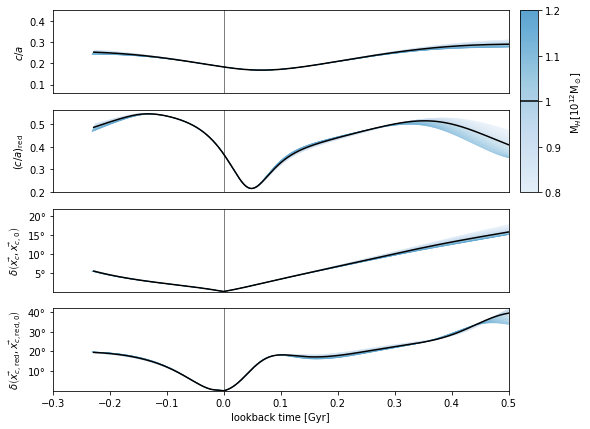

In [19]:
# get the z=0 eigenvalues & eigenvectors
eigenvalues_z0, eigenvectors_z0 = inertiatensor(coords_ML)

# initialise the plot
fig = plt.figure(figsize=(10, 7))
gs = GridSpec(nrows=4, ncols=3, width_ratios=[25, 1, 1], height_ratios=[1, 1, 1, 1])

ax0 = fig.add_subplot(gs[0, 0]) # c/a
ax1 = fig.add_subplot(gs[1, 0]) # c/a reduced
ax2 = fig.add_subplot(gs[2, 0]) # orientation
ax3 = fig.add_subplot(gs[3, 0]) # orientation (reduced)
ax_cb1 = fig.add_subplot(gs[0:2, 1]) # color bar (11)

colors = colors_blues

for mass_index in range (len(halo_masses)):
        
    print('halo mass index', mass_index, ' of ', len(halo_masses), end='\r')

    ca_list = []
    ca_reduced_list = []
    angle_list = []
    angle_reduced_list = []
    escaped = []

    # select the subhaloes and combine the past and future orbits without duplicating the t=0 entry
    x_mass = np.concatenate([np.flip(coords_ML_integrated_masses[mass_index,:,0,0:-1]), coords_ML_integrated_masses_future[mass_index,:,0,1:-1] ], axis=1)
    y_mass = np.concatenate([np.flip(coords_ML_integrated_masses[mass_index,:,1,0:-1]), coords_ML_integrated_masses_future[mass_index,:,1,1:-1] ], axis=1)
    z_mass = np.concatenate([np.flip(coords_ML_integrated_masses[mass_index,:,2,0:-1]), coords_ML_integrated_masses_future[mass_index,:,2,1:-1] ], axis=1)

    N_points = x_mass.shape[1]
    middle = int(np.floor(N_points/2)) # this is the index for t=0

    # z=0 values
    x_z0 = x_mass[:,middle]
    y_z0 = y_mass[:,middle]
    z_z0 = z_mass[:,middle]

    # compute the eigenvectors at z=0 for reference for the rotation 
    coords_mass_z0 = np.transpose([x_z0, y_z0, z_z0])
    eigenvalues_mass_z0, eigenvectors_mass_z0 = inertiatensor(coords_mass_z0)
    eigenvalues_reduced_mass_z0, eigenvectors_reduced_mass_z0 = inertiatensor_reduced(coords_mass_z0)

    for timebin in range (N_points-1,-1,-1):   # Future towards the left of the plot
        x = x_mass[:,timebin]
        y = y_mass[:,timebin]
        z = z_mass[:,timebin]

        r_gal = np.sqrt(x*x+ y*y+ z*z)

        coords_mass = np.transpose([x,y,z])
        eigenvalues_mass, eigenvectors_mass = inertiatensor(coords_mass)
        eigenvalues_reduced_mass, eigenvectors_reduced_mass = inertiatensor_reduced(coords_mass)

        dot_product = np.dot(eigenvectors_mass[:,2], eigenvectors_mass_z0[:,2]) - 1.e-10
        angle_list.append(min (np.arccos(dot_product), np.pi - np.arccos(dot_product))*180. / np.pi )

        dot_product = np.dot(eigenvectors_reduced_mass[:,2], eigenvectors_reduced_mass_z0[:,2]) - 1.e-10
        angle_reduced_list.append(min (np.arccos(dot_product), np.pi - np.arccos(dot_product))*180. / np.pi )

        ca_list.append(eigenvalues_mass[2]/eigenvalues_mass[0])
        ca_reduced_list.append(eigenvalues_reduced_mass[2]/eigenvalues_reduced_mass[0])

        if max(r_gal) > 300. : # at least one satellite has escaped
            escaped.append(1)
        else:
            escaped.append(0)

    ca_list = np.array(ca_list)
    ca_reduced_list = np.array(ca_reduced_list)
    angle_list = np.array(angle_list)
    angle_reduced_list = np.array(angle_reduced_list)

    escaped = np.array(escaped)
    selection_no_escape = np.where(escaped == 0)

    ax0.plot(times[selection_no_escape], ca_list[selection_no_escape], color = colors[mass_index], lw = .5, alpha = 1)
    ax1.plot(times[selection_no_escape], ca_reduced_list[selection_no_escape], color = colors[mass_index], lw = .5, alpha = 1)
    ax2.plot(times[selection_no_escape], angle_list[selection_no_escape], color = colors[mass_index], lw = .5, alpha = 1)
    ax3.plot(times[selection_no_escape], angle_reduced_list[selection_no_escape], color = colors[mass_index], lw = .5, alpha = 1)

    #overplot the default potential in black

    if halo_masses[mass_index] == 1.e12 : # now, the default halo mass - black lines
        ax0.plot(times[selection_no_escape], ca_list[selection_no_escape], color = 'black', ls='solid', lw = 1.5, alpha = 1, zorder = 10)
        ax1.plot(times[selection_no_escape], ca_reduced_list[selection_no_escape], color = 'black', ls='solid', lw = 1.5, alpha = 1, zorder=10)
        ax2.plot(times[selection_no_escape], angle_list[selection_no_escape], color = 'black', ls='solid', lw = 1.5, alpha = 1, zorder=10)
        ax3.plot(times[selection_no_escape], angle_reduced_list[selection_no_escape], color = 'black', ls='solid', lw = 1.5, alpha = 1, zorder=10)

# mark out z=0                                                         
ax0.axvline(x=0, ls = 'solid', lw = .5, color = 'black')
ax1.axvline(x=0, ls = 'solid', lw = .5, color = 'black')
ax2.axvline(x=0, ls = 'solid', lw = .5, color = 'black')
ax3.axvline(x=0, ls = 'solid', lw = .5, color = 'black')

# labels and limits for the axes
ax0.set_xlabel('')
ax0.set_xticks([])
ax0.set_ylabel(r'$c/a$')
ax0.set_ylim([0.06, .45])

ax0.set_xlim([-.3,.5])
ax1.set_xlim([-.3,.5])
ax1.set_xlabel('')
ax1.set_xticks([])
ax1.set_ylabel(r'$(c/a)_\mathrm{red}$')

ax2.set_xlim([-.3,.5])
ax2.set_ylabel(r'$\delta\left(\vec{x_c}, \vec{x_c}_{,0}\right)$')
ax2.set_ylim([0, 22])
ax2.set_yticks([5, 10, 15, 20])
ax2.set_yticklabels(['5°', '10°', '15°', '20°'])
ax2.set_xlabel('')
ax2.set_xticks([])

ax3.set_xlim([-.3,.5])
ax3.set_ylabel(r'$\delta\left(\vec{x_c}_{,\mathrm{red}}, \vec{x_c}_{,\mathrm{red},0}\right)$')
ax3.set_ylim([0, 42])
ax3.set_xlabel('lookback time [Gyr]')
ax3.set_yticks([10, 20, 30, 40])
ax3.set_yticklabels(['10°', '20°', '30°', '40°'])

# add the color bar
cb1 = mpl.colorbar.ColorbarBase(ax_cb1,
                               cmap=new_Blues,
                               orientation='vertical')

ax_cb1.axhline(y=2./4., xmin=0, xmax=1, color='black', ls = 'solid', zorder = 20)
cb1.set_ticks([0, 1/4., 2/4., 3/4., 4/4.])
cb1.set_ticklabels(['0.8 ', '0.9', '1', '1.1', '1.2'])
ax_cb1.set_ylabel(r'M$_H$'+r'$[10^{12}$M$_\odot$]')

# move the color bar                                                                                                                                                                                                 
offset=-0.03
bbox=ax_cb1.get_position()
ax_cb1.set_position([bbox.x0 + offset, bbox.y0, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])

plt.savefig('plots/c_over_a_evolution_gala_halo_N'+str(max_N)+suffix+'.pdf', bbox_inches='tight', dpi=200)

if PMDATA == "DR2-Riley":
    ax0.text(0.05, 0.8, r'DR2 (Riley et al. 2019)', transform=ax0.transAxes  )

if PMDATA == "EDR3-Battaglia":
    ax0.text(0.05, 0.8, r'EDR3 (Battaglia et al. 2022)', transform=ax0.transAxes  )

print ("finnished plotting c/a evolution")


finnished plotting c/a evolution


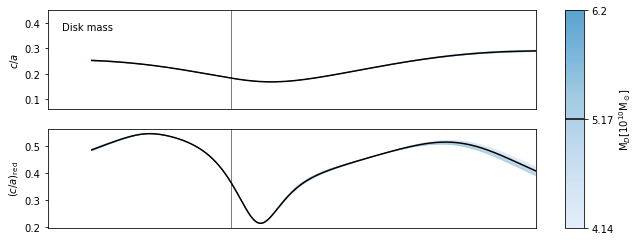

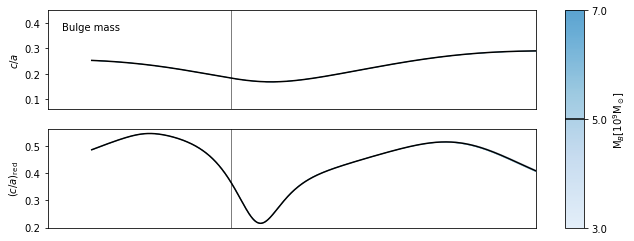

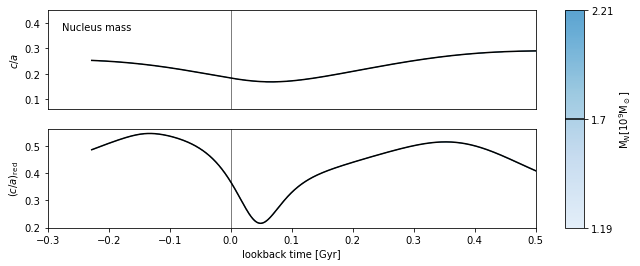

In [20]:
# get the z=0 eigenvalues & eigenvectors
eigenvalues_z0, eigenvectors_z0 = inertiatensor(coords_ML)

# initialise the plot
fig = plt.figure(figsize=(10, 4))
gs = GridSpec(nrows=2, ncols=2, width_ratios=[25, 1], height_ratios=[1, 1])

ax0 = fig.add_subplot(gs[0, 0]) # c/a
ax1 = fig.add_subplot(gs[1, 0]) # c/a reduced
ax_cb1 = fig.add_subplot(gs[0:2, 1]) # color bar (11)

#disk
for mass_index, disk_mass in enumerate(disk_masses):
    
    print('mass index', mass_index, ' of ', len(disk_masses), end='\r')
    ca_list = []
    ca_reduced_list = []
    escaped = []
            
    # select the subhaloes and combine the past and future orbits without duplicating the t=0 entry
    x_mass = np.concatenate([np.flip(coords_ML_integrated_disk_masses[mass_index,:,0,0:-1]), coords_ML_integrated_disk_masses_future[mass_index,:,0,1:-1] ], axis=1)
    y_mass = np.concatenate([np.flip(coords_ML_integrated_disk_masses[mass_index,:,1,0:-1]), coords_ML_integrated_disk_masses_future[mass_index,:,1,1:-1] ], axis=1)
    z_mass = np.concatenate([np.flip(coords_ML_integrated_disk_masses[mass_index,:,2,0:-1]), coords_ML_integrated_disk_masses_future[mass_index,:,2,1:-1] ], axis=1)
   
    N_points = x_mass.shape[1]
    middle = int(np.floor(N_points/2)) # this is the index for t=0
    
    # z=0 values
    x_z0 = x_mass[:,middle]
    y_z0 = y_mass[:,middle]
    z_z0 = z_mass[:,middle]
    
    # compute the eigenvectors at z=0 for reference for the rotation 
    coords_mass_z0 = np.transpose([x_z0, y_z0, z_z0])
    eigenvalues_mass_z0, eigenvectors_mass_z0 = inertiatensor(coords_mass_z0)
    eigenvalues_reduced_mass_z0, eigenvectors_reduced_mass_z0 = inertiatensor_reduced(coords_mass_z0)
    
    for timebin in range (N_points-1,-1,-1):   # Future towards the left of the plot
        x = x_mass[:,timebin]
        y = y_mass[:,timebin]
        z = z_mass[:,timebin]
 
        r_gal = np.sqrt(x*x+ y*y+ z*z)

        coords_mass = np.transpose([x,y,z])
        eigenvalues_mass, eigenvectors_mass = inertiatensor(coords_mass)
        eigenvalues_reduced_mass, eigenvectors_reduced_mass = inertiatensor_reduced(coords_mass)

        ca_list.append(eigenvalues_mass[2]/eigenvalues_mass[0])
        ca_reduced_list.append(eigenvalues_reduced_mass[2]/eigenvalues_reduced_mass[0])
    
        if max(r_gal) > 300. : # at least one satellite has escaped
            escaped.append(1)
        else:
            escaped.append(0)
        
    ca_list = np.array(ca_list)
    ca_reduced_list = np.array(ca_reduced_list)
    
    escaped = np.array(escaped)
    selection_no_escape = np.where(escaped == 0)

    ax0.plot(times[selection_no_escape], ca_list[selection_no_escape], color = colors[mass_index], lw = .5, alpha = 1)
    ax1.plot(times[selection_no_escape], ca_reduced_list[selection_no_escape], color = colors[mass_index], lw = .5, alpha = 1)
    
    #overplot the default potential in black
    if disk_mass == default_disk_mass.value :
        ax0.plot(times[selection_no_escape], ca_list[selection_no_escape], color = 'black', ls='solid', lw = 1.5, alpha = 1, zorder = 10)
        ax1.plot(times[selection_no_escape], ca_reduced_list[selection_no_escape], color = 'black', ls='solid', lw = 1.5, alpha = 1, zorder=10)
        
# mark out z=0                                                         
ax0.axvline(x=0, ls = 'solid', lw = .5, color = 'black')
ax1.axvline(x=0, ls = 'solid', lw = .5, color = 'black')

# labels and limits for the axes
ax0.set_xlabel('')
ax0.set_xticks([])
ax0.set_ylabel(r'$c/a$')
ax0.set_ylim([0.06, .45])
ax0.set_xlim([-.3,0.5])

ax1.set_xlim([-.3,0.5])
ax1.set_ylabel(r'$(c/a)_\mathrm{red}$')
ax1.set_xlabel('')
ax1.set_xticks([])

ax0.text(0.03, 0.8, r'Disk mass', transform=ax0.transAxes  )
    
# add the color bar
cb1 = mpl.colorbar.ColorbarBase(ax_cb1,
                               cmap=new_Blues,
                               orientation='vertical')


ax_cb1.axhline(y=1./2., xmin=0, xmax=1, color='black', ls = 'solid', zorder = 20)
cb1.set_ticks([0, 1/2, 1])
cb1.set_ticklabels([str(np.round(min(disk_masses/1.e10),2)), str(np.round(0.5*min(disk_masses/1.e10)+0.5*max(disk_masses/1.e10),2)), str(np.round(max(disk_masses/1.e10),2))])
ax_cb1.set_ylabel(r'M$_D$'+r'$[10^{10}$M$_\odot$]')

# move the color bar                                                                                                                                                                                                 
offset=-0.03
bbox=ax_cb1.get_position()
ax_cb1.set_position([bbox.x0 + offset, bbox.y0, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])

plt.savefig('plots/c_over_a_evolution_gala_disk_N'+str(max_N)+suffix+'.pdf', bbox_inches='tight', dpi=200)


#bulge

# initialise the plot
fig = plt.figure(figsize=(10, 4))
gs = GridSpec(nrows=2, ncols=2, width_ratios=[25, 1], height_ratios=[1, 1])

ax0 = fig.add_subplot(gs[0, 0]) # c/a
ax1 = fig.add_subplot(gs[1, 0]) # c/a reduced
ax_cb1 = fig.add_subplot(gs[0:2, 1]) # color bar (11)

for mass_index, bulge_mass in enumerate(bulge_masses):

    ca_list = []
    ca_reduced_list = []
    escaped = []
            
    # select the subhaloes and combine the past and future orbits without duplicating the t=0 entry
    x_mass = np.concatenate([np.flip(coords_ML_integrated_bulge_masses[mass_index,:,0,0:-1]), coords_ML_integrated_bulge_masses_future[mass_index,:,0,1:-1] ], axis=1)
    y_mass = np.concatenate([np.flip(coords_ML_integrated_bulge_masses[mass_index,:,1,0:-1]), coords_ML_integrated_bulge_masses_future[mass_index,:,1,1:-1] ], axis=1)
    z_mass = np.concatenate([np.flip(coords_ML_integrated_bulge_masses[mass_index,:,2,0:-1]), coords_ML_integrated_bulge_masses_future[mass_index,:,2,1:-1] ], axis=1)
   
    N_points = x_mass.shape[1]
    middle = int(np.floor(N_points/2)) # this is the index for t=0
    
    # z=0 values
    x_z0 = x_mass[:,middle]
    y_z0 = y_mass[:,middle]
    z_z0 = z_mass[:,middle]
    
    # compute the eigenvectors at z=0 for reference for the rotation 
    coords_mass_z0 = np.transpose([x_z0, y_z0, z_z0])
    eigenvalues_mass_z0, eigenvectors_mass_z0 = inertiatensor(coords_mass_z0)
    eigenvalues_reduced_mass_z0, eigenvectors_reduced_mass_z0 = inertiatensor_reduced(coords_mass_z0)
    
    for timebin in range (N_points-1,-1,-1):   # Future towards the left of the plot
        x = x_mass[:,timebin]
        y = y_mass[:,timebin]
        z = z_mass[:,timebin]
 
        r_gal = np.sqrt(x*x+ y*y+ z*z)

        coords_mass = np.transpose([x,y,z])
        eigenvalues_mass, eigenvectors_mass = inertiatensor(coords_mass)
        eigenvalues_reduced_mass, eigenvectors_reduced_mass = inertiatensor_reduced(coords_mass)

        ca_list.append(eigenvalues_mass[2]/eigenvalues_mass[0])
        ca_reduced_list.append(eigenvalues_reduced_mass[2]/eigenvalues_reduced_mass[0])
    
        if max(r_gal) > 300. : # at least one satellite has escaped
            escaped.append(1)
        else:
            escaped.append(0)
        
    ca_list = np.array(ca_list)
    ca_reduced_list = np.array(ca_reduced_list)
    
    escaped = np.array(escaped)
    selection_no_escape = np.where(escaped == 0)

    ax0.plot(times[selection_no_escape], ca_list[selection_no_escape], color = colors[mass_index], lw = .5, alpha = 1)
    ax1.plot(times[selection_no_escape], ca_reduced_list[selection_no_escape], color = colors[mass_index], lw = .5, alpha = 1)
    
    #overplot the default potential in black
    if bulge_mass == default_bulge_mass.value :
        ax0.plot(times[selection_no_escape], ca_list[selection_no_escape], color = 'black', ls='solid', lw = 1.5, alpha = 1, zorder = 10)
        ax1.plot(times[selection_no_escape], ca_reduced_list[selection_no_escape], color = 'black', ls='solid', lw = 1.5, alpha = 1, zorder=10)
        
# mark out z=0                                                         
ax0.axvline(x=0, ls = 'solid', lw = .5, color = 'black')
ax1.axvline(x=0, ls = 'solid', lw = .5, color = 'black')

# labels and limits for the axes
ax0.set_xlabel('')
ax0.set_xticks([])
ax0.set_ylabel(r'$c/a$')
ax0.set_ylim([0.06, .45])
ax0.set_xlim([-.3,0.5])

ax1.set_xlim([-.3,0.5])
ax1.set_ylabel(r'$(c/a)_\mathrm{red}$')
ax1.set_xlabel('')
ax1.set_xticks([])

ax0.text(0.03, 0.8, r'Bulge mass', transform=ax0.transAxes  )
    
# add the color bar
cb1 = mpl.colorbar.ColorbarBase(ax_cb1,
                               cmap=new_Blues,
                               orientation='vertical')

ax_cb1.axhline(y=1./2., xmin=0, xmax=1, color='black', ls = 'solid', zorder = 20)
cb1.set_ticks([0, 1/2, 1])
cb1.set_ticklabels([str(np.round(min(bulge_masses/1.e9),2)), str(np.round(0.5*min(bulge_masses/1.e9)+0.5*max(bulge_masses/1.e9),2)), str(np.round(max(bulge_masses/1.e9),2))])
ax_cb1.set_ylabel(r'M$_B$'+r'$[10^{9}$M$_\odot$]')

# move the color bar                                                                                                                                                                                                 
offset=-0.03
bbox=ax_cb1.get_position()
ax_cb1.set_position([bbox.x0 + offset, bbox.y0, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])

plt.savefig('plots/c_over_a_evolution_gala_bulge_N'+str(max_N)+suffix+'.pdf', bbox_inches='tight', dpi=200)



#nucleus


# initialise the plot
fig = plt.figure(figsize=(10, 4))
gs = GridSpec(nrows=2, ncols=2, width_ratios=[25, 1], height_ratios=[1, 1])

ax0 = fig.add_subplot(gs[0, 0]) # c/a
ax1 = fig.add_subplot(gs[1, 0]) # c/a reduced
ax_cb1 = fig.add_subplot(gs[0:2, 1]) # color bar (11)

for mass_index, nucleus_mass in enumerate(nucleus_masses):
    
    ca_list = []
    ca_reduced_list = []
    escaped = []
            
    # select the subhaloes and combine the past and future orbits without duplicating the t=0 entry
    x_mass = np.concatenate([np.flip(coords_ML_integrated_nucleus_masses[mass_index,:,0,0:-1]), coords_ML_integrated_nucleus_masses_future[mass_index,:,0,1:-1] ], axis=1)
    y_mass = np.concatenate([np.flip(coords_ML_integrated_nucleus_masses[mass_index,:,1,0:-1]), coords_ML_integrated_nucleus_masses_future[mass_index,:,1,1:-1] ], axis=1)
    z_mass = np.concatenate([np.flip(coords_ML_integrated_nucleus_masses[mass_index,:,2,0:-1]), coords_ML_integrated_nucleus_masses_future[mass_index,:,2,1:-1] ], axis=1)
   
    N_points = x_mass.shape[1]
    middle = int(np.floor(N_points/2)) # this is the index for t=0
    
    # z=0 values
    x_z0 = x_mass[:,middle]
    y_z0 = y_mass[:,middle]
    z_z0 = z_mass[:,middle]
    
    # compute the eigenvectors at z=0 for reference for the rotation 
    coords_mass_z0 = np.transpose([x_z0, y_z0, z_z0])
    eigenvalues_mass_z0, eigenvectors_mass_z0 = inertiatensor(coords_mass_z0)
    eigenvalues_reduced_mass_z0, eigenvectors_reduced_mass_z0 = inertiatensor_reduced(coords_mass_z0)
    
    for timebin in range (N_points-1,-1,-1):   # Future towards the left of the plot
        x = x_mass[:,timebin]
        y = y_mass[:,timebin]
        z = z_mass[:,timebin]
 
        r_gal = np.sqrt(x*x+ y*y+ z*z)

        coords_mass = np.transpose([x,y,z])
        eigenvalues_mass, eigenvectors_mass = inertiatensor(coords_mass)
        eigenvalues_reduced_mass, eigenvectors_reduced_mass = inertiatensor_reduced(coords_mass)

        ca_list.append(eigenvalues_mass[2]/eigenvalues_mass[0])
        ca_reduced_list.append(eigenvalues_reduced_mass[2]/eigenvalues_reduced_mass[0])
    
        if max(r_gal) > 300. : # at least one satellite has escaped
            escaped.append(1)
        else:
            escaped.append(0)
        
    ca_list = np.array(ca_list)
    ca_reduced_list = np.array(ca_reduced_list)
    
    escaped = np.array(escaped)
    selection_no_escape = np.where(escaped == 0)

    ax0.plot(times[selection_no_escape], ca_list[selection_no_escape], color = colors[mass_index], lw = .5, alpha = 1)
    ax1.plot(times[selection_no_escape], ca_reduced_list[selection_no_escape], color = colors[mass_index], lw = .5, alpha = 1)
    
    #overplot the default potential in black
    if nucleus_mass == default_nucleus_mass.value :
        ax0.plot(times[selection_no_escape], ca_list[selection_no_escape], color = 'black', ls='solid', lw = 1.5, alpha = 1, zorder = 10)
        ax1.plot(times[selection_no_escape], ca_reduced_list[selection_no_escape], color = 'black', ls='solid', lw = 1.5, alpha = 1, zorder=10)
        
# mark out z=0                                                         
ax0.axvline(x=0, ls = 'solid', lw = .5, color = 'black')
ax1.axvline(x=0, ls = 'solid', lw = .5, color = 'black')

# labels and limits for the axes
ax0.set_xlabel('')
ax0.set_xticks([])
ax0.set_ylabel(r'$c/a$')
ax0.set_ylim([0.06, .45])
ax0.set_xlim([-.3,0.5])

ax1.set_xlim([-.3,0.5])
ax1.set_ylabel(r'$(c/a)_\mathrm{red}$')
ax1.set_xlabel('lookback time [Gyr]')
     
ax0.text(0.03, 0.8, r'Nucleus mass', transform=ax0.transAxes  )
    
# add the color bar
cb1 = mpl.colorbar.ColorbarBase(ax_cb1,
                               cmap=new_Blues,
                               orientation='vertical')

ax_cb1.axhline(y=1./2., xmin=0, xmax=1, color='black', ls = 'solid', zorder = 20)
cb1.set_ticks([0, 1/2, 1])#
cb1.set_ticklabels([str(np.round(min(nucleus_masses/1.e9),2)), str(np.round(0.5*min(nucleus_masses/1.e9)+0.5*max(nucleus_masses/1.e9),2)), str(np.round(max(nucleus_masses/1.e9),2))])
ax_cb1.set_ylabel(r'M$_N$'+r'$[10^{9}$M$_\odot$]')

# move the color bar                                                                                                                                                                                                 
offset=-0.03
bbox=ax_cb1.get_position()
ax_cb1.set_position([bbox.x0 + offset, bbox.y0, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])

plt.savefig('plots/c_over_a_evolution_gala_nucleus_N'+str(max_N)+suffix+'.pdf', bbox_inches='tight', dpi=200)


print ("finnished plotting c/a evolution")


## Plot the radial distribution and the Gini coefficients (_Figure 2_ of the paper)

### Instantiate the model for Tensor Flow. https://scikit-learn.org/dev/auto_examples/linear_model/plot_quantile_regression.html+

In [21]:
# Initialize session
sess = tf.Session()

# Create network
class q_model:
    def __init__(self, 
                 sess, 
                 quantiles, 
                 in_shape=1, 
                 out_shape=1, 
                 batch_size=32):
        
        self.sess = sess
        
        self.quantiles = quantiles
        self.num_quantiles = len(quantiles)
        
        self.in_shape = in_shape
        self.out_shape = out_shape
        self.batch_size = batch_size
        
        self.outputs = []
        self.losses = []
        self.loss_history = []
        
        self.build_model()
        
    def build_model(self, scope='q_model', reuse=tf.AUTO_REUSE): 
        with tf.variable_scope(scope, reuse=reuse) as scope:
            self.x = tf.placeholder(tf.float32, shape=(None, self.in_shape))
            self.y = tf.placeholder(tf.float32, shape=(None, self.out_shape))

            self.layer0 = tf.layers.dense(self.x, 
                                    units=32, 
                                    activation=tf.nn.relu)
            self.layer1 = tf.layers.dense(self.layer0, 
                                    units=32, 
                                    activation=tf.nn.relu)

            # Create outputs and losses for all quantiles
            for i in range(self.num_quantiles):
                q = self.quantiles[i]
                
                # Get output layers 
                output = tf.layers.dense(self.layer1, 1, name="{}_q{}".format(i, int(q*100)))
                self.outputs.append(output)
                
                # Create losses
                
                error = tf.subtract(self.y, output)
                loss = tf.reduce_mean(tf.maximum(q*error, (q-1)*error), axis=-1)

                self.losses.append(loss)

            # Create combined loss
            self.combined_loss = tf.reduce_mean(tf.add_n(self.losses))
            self.train_step = tf.train.AdamOptimizer().minimize(self.combined_loss)

    def fit(self, x, y, epochs=100):  
        for epoch in range(epochs):
            epoch_losses = []
            for idx in range(0, x.shape[0], self.batch_size):
                batch_x = x[idx : min(idx + self.batch_size, x.shape[0]),:]
                batch_y = y[idx : min(idx + self.batch_size, y.shape[0]),:]

                feed_dict = {self.x: batch_x,
                             self.y: batch_y}

                _, c_loss = self.sess.run([self.train_step, self.combined_loss], feed_dict)
                epoch_losses.append(c_loss)
                
            epoch_loss =  np.mean(epoch_losses)
            self.loss_history.append(epoch_loss)
            if epoch % 20 == 0:
                print("Epoch {}: {}".format(epoch, epoch_loss))
            
    def predict(self, x):   
        # Run model to get outputs
        feed_dict = {self.x: x}
        predictions = sess.run(self.outputs, feed_dict)
        
        return predictions

2022-05-04 11:21:07.291210: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-04 11:21:07.291235: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p17): /proc/driver/nvidia/version does not exist
2022-05-04 11:21:07.291747: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load the data, fit and plot.

Complete set:
Percentile for MW c/a: 5.445544554455446
Percentile for MW G: 58.415841584158414
Percentile for MW c/a = 0.23: 12.871287128712872
Percentile for MW c/a = 0.27: 23.26732673267327
Percentile for MW c/a = 0.28: 26.237623762376238
Remnant set:
Percentile for MW c/a: 0.9900990099009901
1st percentile 0.1932004328119997
0.3 percentile 0.14332332631090944
Percentile for MW G: 100.0
gini_mw 0.6567870828368101
max gini 0.8581858644898694
Epoch 0: 0.6730439066886902
Epoch 20: 0.10744497925043106
Epoch 40: 0.09460535645484924
Epoch 60: 0.09286031872034073
Epoch 80: 0.09252800792455673


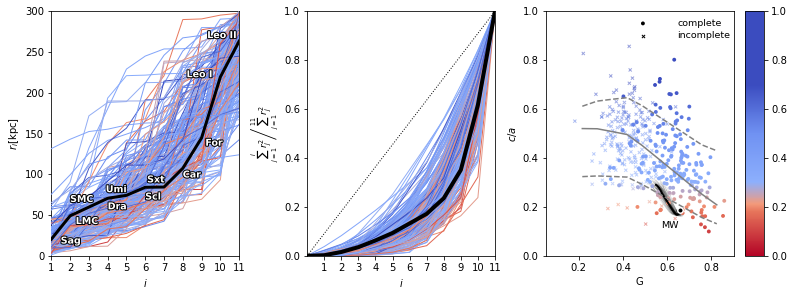

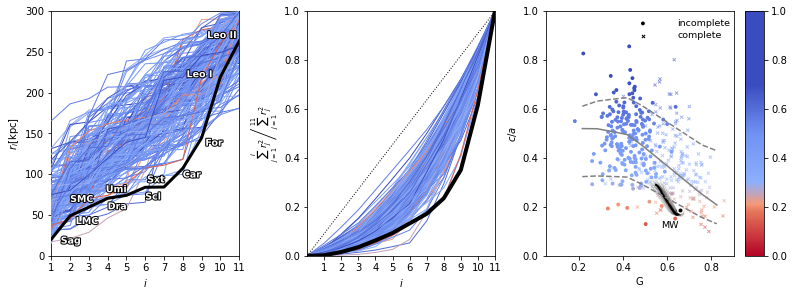

In [22]:
gs = GridSpec(nrows=1, ncols=4, width_ratios=[10, 10, 10, 1.], height_ratios=[1])

# start the plots:                                                                                                                                                                                                           
fig = plt.figure(figsize=(12, 4.5))
ax0 = fig.add_subplot(gs[0]) # radial distribution                                                                                                                                                                          
ax1 = fig.add_subplot(gs[1]) # weights of the inertia tensor                                                                                                                                                                
ax2 = fig.add_subplot(gs[2]) # c/a as a function of G                                                                                                              
ax_cb = fig.add_subplot(gs[3]) # color bar                                                                                                                                                                                  

fig_a = plt.figure(figsize=(12, 4.5))
ax0_a = fig_a.add_subplot(gs[0]) # radial distribution                                                                                                                                                                          
ax1_a = fig_a.add_subplot(gs[1]) # weights of the inertia tensor                                                                                                                                                                
ax2_a = fig_a.add_subplot(gs[2]) # c/a as a function of G                                                                                     
ax_cb_a = fig_a.add_subplot(gs[3]) # color bar                                                                                                                                                                                  

# plot the simulation data 
# First the "complete" data

c_over_a = []
c_over_a_red = []

gini = []

for i, this_num in enumerate(sim_num):

    x = satellite_coordinates[i][0,:, 0] - MW_coordinates[i][0,0]
    y = satellite_coordinates[i][0,:, 1] - MW_coordinates[i][1,0]
    z = satellite_coordinates[i][0,:, 2] - MW_coordinates[i][2,0]
    
    coords = np.transpose(np.array([x, y, z]))
    eigenvalues, eigenvectors = inertiatensor(coords)
    eigenvalues_reduced, eigenvectors_reduced = inertiatensor_reduced(coords)

    radii = np.sqrt( (x**2 + y**2 + z**2) ) * 1000. # in kpc                                                                                                                                                            
    sorted = np.argsort(radii)
    radii = radii[sorted]

    ax0.plot(np.linspace(1,11,11), radii, color = cmap(eigenvalues[2]/eigenvalues[0]), lw = 1., alpha = 1., zorder = 10)

    cumulative = np.cumsum(radii**2)
    cumulative = np.insert(cumulative, 0, 0.) # for the Gini plot, it is customary to start at i=0.                                                                                                                     

    ax1.plot(np.linspace(0,11,12), cumulative / cumulative[-1], color = cmap(eigenvalues[2]/eigenvalues[0]), lw = 1., alpha = 1., zorder = 10)

    # append the values                                                                                                                                                                                                 
    c_over_a.append(eigenvalues[2] / eigenvalues[0])
    c_over_a_red.append(eigenvalues_reduced[2] / eigenvalues_reduced[0])

    gini.append( gini_coefficient(radii**2) ) 

c_over_a = np.array(c_over_a)
c_over_a_red = np.array(c_over_a_red)

gini = np.array(gini)

c_over_a_LCDM = np.copy(c_over_a) # we use this in the next plot
c_over_a_red_LCDM = np.copy(c_over_a_red) # we use this in the next plot

# Now, the "remnant" ("incomplete") data

c_over_a_remnants = []
gini_remnants = []


for i, this_num in enumerate(sim_num):

    x = satellite_coordinates_remnants[i][0,:, 0] - MW_coordinates[i][0,0]
    y = satellite_coordinates_remnants[i][0,:, 1] - MW_coordinates[i][1,0]
    z = satellite_coordinates_remnants[i][0,:, 2] - MW_coordinates[i][2,0]
    
    coords = np.transpose(np.array([x, y, z]))
    eigenvalues, eigenvectors = inertiatensor(coords)

    radii = np.sqrt( (x**2 + y**2 + z**2) ) * 1000. # in kpc                                                                                                                                                            
    sorted = np.argsort(radii)
    radii = radii[sorted]

    ax0_a.plot(np.linspace(1,11,11), radii, color = cmap(eigenvalues[2]/eigenvalues[0]), lw = 1., alpha = 1., zorder = 10)
      
    cumulative = np.cumsum(radii**2)
    cumulative = np.insert(cumulative, 0, 0.) # for the Gini plot, it is customary to start at i=0.

    ax1_a.plot(np.linspace(0,11,12), cumulative / cumulative[-1], color = cmap(eigenvalues[2]/eigenvalues[0]), lw = 1., alpha = 1., zorder = 10)

    # append the values                                                                                                                                                                                                 
    c_over_a_remnants.append(eigenvalues[2] / eigenvalues[0])
    gini_remnants.append( gini_coefficient (radii**2))

c_over_a_remnants = np.array(c_over_a_remnants)
gini_remnants = np.array(gini_remnants)


# plot the scatter of G vs c/a for the paper (complete is default):
ax2.scatter(gini, c_over_a, facecolor = cmap(c_over_a), edgecolor='none', s=15, alpha = 1., zorder = 10., marker='o')
ax2.scatter(gini_remnants, c_over_a_remnants, color=cmap(c_over_a_remnants), s=10, lw=1, alpha = .5, zorder = 8., marker='x')

# plot the scatter of G vs c/a for the appendix (remnants is default):
ax2_a.scatter(gini, c_over_a, facecolor = cmap(c_over_a), s=10, lw=1, alpha = .5, zorder = 8., marker='x') 
ax2_a.scatter(gini_remnants, c_over_a_remnants, color=cmap(c_over_a_remnants), edgecolor='none', s=15, alpha = 1., zorder = 10., marker='o')

# overplot the MW data      

x = coords_ML[:,0]
y = coords_ML[:,1]
z = coords_ML[:,2]

radii = np.sqrt(x**2 + y**2 + z**2)
sorted = np.argsort(radii)
radii = radii[sorted]

cumulative = np.cumsum(radii**2)
cumulative = np.insert(cumulative, 0, 0.)
gini_mw = gini_coefficient(radii**2)


if Verbatim:
    print ("Complete set:")
    print ("Percentile for MW c/a:",  stats.percentileofscore(c_over_a, 0.183) )
    print ("Percentile for MW G:",  stats.percentileofscore(gini, gini_mw) )
    print ("Percentile for MW c/a = 0.23:",  stats.percentileofscore(c_over_a, 0.23) )
    print ("Percentile for MW c/a = 0.27:",  stats.percentileofscore(c_over_a, 0.27) )
    print ("Percentile for MW c/a = 0.28:",  stats.percentileofscore(c_over_a, 0.28) )
    
    print ("Remnant set:")
    print ("Percentile for MW c/a:",  stats.percentileofscore(c_over_a_remnants, 0.183) )
    print ("1st percentile", np.percentile(c_over_a_remnants, 1.0))
    print ("0.3 percentile", np.percentile(c_over_a_remnants, 0.3))
    print ("Percentile for MW G:",  stats.percentileofscore(gini_remnants, gini_mw) )


print ("gini_mw", gini_mw)
                                                                                                                                                                                                    
ax2.scatter([gini_mw], [0.1852], edgecolor='white', facecolor='black', alpha = 1., s=30, lw=1.5, marker = 'o', zorder = 20000.)
ax2_a.scatter([gini_mw], [0.1852], edgecolor='white', facecolor='black', alpha = 1., s=30, lw=1.5, marker = 'o', zorder = 20000.)

ax0.plot(np.linspace(1,11,11), radii, lw = 3, ls = 'solid', alpha = 1., color = 'black', zorder = 10000.)
ax0_a.plot(np.linspace(1,11,11), radii, lw = 3, ls = 'solid', alpha = 1., color = 'black', zorder = 10000.)

x = np.linspace(0,11,12)
y = cumulative / cumulative[-1]

ax1.plot(x, y,  lw = 4, ls = 'solid', alpha = 1., color = 'black', zorder = 10000.)
ax1_a.plot(x, y,  lw = 4, ls = 'solid', alpha = 1., color = 'black', zorder = 10000.)

# Trace the trajectory of the MW's c/a and Gini for 1 Gyr

# First, plot the most likely orbit

x = coords_ML_integrated_1Gyr[:,0,0:-1:5]
y = coords_ML_integrated_1Gyr[:,1,0:-1:5]
z = coords_ML_integrated_1Gyr[:,2,0:-1:5]
     
coords = np.transpose(np.array([x, y, z]))

gini_mw = []
ca_mw = []

for i in range (0, int(x.shape[1]/2)): # past 0.5 Gyr
    radii = np.sqrt(x[:,i]**2 + y[:,i]**2 + z[:,i]**2)
     
    if max(radii) < 300. :
        sorted = np.argsort(radii)
        radii = radii[sorted]
        cumulative = np.cumsum(radii**2)
        cumulative = np.insert(cumulative, 0, 0.)
        gini_mw.append( gini_coefficient (radii**2) )

        eigenvalues, eigenvectors = inertiatensor(coords[i])
        ca_mw.append(eigenvalues[2]/eigenvalues[0])


ax2.plot(gini_mw, ca_mw, lw=2, color='black', alpha = 1., zorder = 1000.)
ax2_a.plot(gini_mw, ca_mw, lw=2, color='black', alpha = 1., zorder = 1000.)

# Repeat for the MC samples
    
use_MC_samples = min ([100, N_MC_samples])
    
for sample in range (use_MC_samples):
        
    x = coords_MC_integrated[sample,:,0,0:-1:5]
    y = coords_MC_integrated[sample,:,1,0:-1:5]
    z = coords_MC_integrated[sample,:,2,0:-1:5]

    coords = np.transpose(np.array([x, y, z]))

    gini_mw = []
    ca_mw = []

    for i in range (0, int(x.shape[1]/2)):         # past 0.5 Gyr
        radii = np.sqrt(x[:,i]**2 + y[:,i]**2 + z[:,i]**2)
        
        if max(radii) < 300. :
            sorted = np.argsort(radii)
            radii = radii[sorted]
            cumulative = np.cumsum(radii**2)
            cumulative = np.insert(cumulative, 0, 0.)
            gini_mw.append( gini_coefficient (radii**2))
    
            eigenvalues, eigenvectors = inertiatensor(coords[i])
            ca_mw.append(eigenvalues[2]/eigenvalues[0])

    ax2.plot(gini_mw, ca_mw, lw=0.5, color='black', alpha = .1, zorder = 1.)
    ax2_a.plot(gini_mw, ca_mw, lw=0.5, color='black', alpha = .1, zorder = 1.)

# Now the fitting - we use both the "complete" and "incomplete" sets combined:
gini = np.concatenate([gini, gini_remnants])
c_over_a = np.concatenate([c_over_a, c_over_a_remnants])

selection = np.where(gini > 0.1)

gini = gini[selection]
c_over_a = c_over_a[selection]

print ("max gini", max(gini))

# Reshape to input format for network
gini_reshaped = np.expand_dims(gini, 1)
ca_reshaped = np.expand_dims(c_over_a, 1)

# Instantiate model
quantiles = [.1, .5, .9]
model = q_model(sess, quantiles, batch_size=25)

# Initialize all variables
init_op = tf.global_variables_initializer()
sess.run(init_op)

epochs = N_epochs_data
# Run training
model.fit(gini_reshaped, ca_reshaped, epochs)

# Generate the range of data we'd like to predict
edges = np.histogram_bin_edges(gini_reshaped, bins=10, range=None, weights=None)
centers = (edges[1:] + edges[:-1])/2

test_gini = np.expand_dims(centers, 1)
predictions = model.predict(test_gini)

# plot the percentiles
ax2.plot(test_gini, predictions[0], linestyle='--', lw=1.5, color = 'grey', zorder = 10000) 
ax2.plot(test_gini, predictions[1], linestyle='solid', lw=1.5, color = 'grey', zorder = 10000) 
ax2.plot(test_gini, predictions[2], linestyle='--', lw=1.5, color = 'grey', zorder = 10000) 

ax2_a.plot(test_gini, predictions[0], linestyle='--', lw=1.5, color = 'grey', zorder = 10000) 
ax2_a.plot(test_gini, predictions[1], linestyle='solid', lw=1.5, color = 'grey', zorder = 10000) 
ax2_a.plot(test_gini, predictions[2], linestyle='--', lw=1.5, color = 'grey', zorder = 10000) 

# axis limits and labels                                                                                                                                                                                                    
ax0.set_xlim(1,11)
ax0.set_ylim(0,300)
ax0.set_xticks(np.arange(1,12))
ax0.set_ylabel(r'$r_i$[kpc]', fontsize=10)
ax0.set_xlabel('$i$', fontsize=10)

ax1.set_ylim(0,1)
ax1.set_xlim(0,11)
ax1.set_xticks(np.arange(1,12))
ax1.set_ylabel(r'$\sum_{j=1}^{i}{r_j^2} \left/ \sum_{j=1}^{11}{r_j^2} \right.$', fontsize=9)
ax1.set_xlabel('$i$', fontsize=10)
ax1.plot([0,11], [0,1], color = 'black', ls = 'dotted', lw = 1, zorder = 10000.)

ax2.set_ylim(0.0,1.0)
ax2.set_xlim(0.05, 0.9)
ax2.set_ylabel('$c/a$', fontsize=10)
ax2.set_xlabel('G', fontsize=10)

ax0_a.set_xlim(1,11)
ax0_a.set_ylim(0,300)
ax0_a.set_xticks(np.arange(1,12))
ax0_a.set_ylabel(r'$r_i$[kpc]', fontsize=10)
ax0_a.set_xlabel('$i$', fontsize=10)

ax1_a.set_ylim(0,1)
ax1_a.set_xlim(0,11)
ax1_a.set_xticks(np.arange(1,12))
ax1_a.set_ylabel(r'$\sum_{j=1}^{i}{r_j^2} \left/ \sum_{j=1}^{11}{r_j^2} \right.$', fontsize=9)
ax1_a.set_xlabel('$i$', fontsize=10)
ax1_a.plot([0,11], [0,1], color = 'black', ls = 'dotted', lw = 1, zorder = 10000.)

ax2_a.set_ylim(0.0,1.0)
ax2_a.set_xlim(0.05, 0.9)
ax2_a.set_ylabel('$c/a$', fontsize=10)
ax2_a.set_xlabel('G', fontsize=10)

# color bar:                                                                                                                                                                                                                
cb = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap),
             cax=ax_cb, orientation='vertical', label='')
cb.set_ticks([0., 0.2, 0.4, 0.6, 0.8, 1.0])
ax_cb.yaxis.set_ticks_position('right')

# color bar:                                                                                                                                                                                                                
cb_a = fig_a.colorbar(mpl.cm.ScalarMappable(cmap=cmap),
             cax=ax_cb_a, orientation='vertical', label='')
cb_a.set_ticks([0., 0.2, 0.4, 0.6, 0.8, 1.0])
ax_cb_a.yaxis.set_ticks_position('right')

# overplot the labels
ax2.text(0.7, 0.89, 'incomplete', transform=ax2.transAxes, fontsize=9.5 )
ax2.text(0.7, 0.94, 'complete', transform=ax2.transAxes, fontsize=9.5 )
ax2.scatter([0.49], [0.95], facecolor = 'black', edgecolor = 'none', s=15, alpha = 1., zorder = 10.)
ax2.scatter([0.49], [0.90], color = 'black',  marker='x', s=10, lw=1, alpha = 1., zorder = 8.)

ax2_a.text(0.7, 0.89, 'complete', transform=ax2_a.transAxes, fontsize=9.5 )
ax2_a.text(0.7, 0.94, 'incomplete', transform=ax2_a.transAxes, fontsize=9.5 )
ax2_a.scatter([0.49], [0.95], facecolor = 'black', edgecolor = 'none', s=15, alpha = 1., zorder = 10.)
ax2_a.scatter([0.49], [0.90], color = 'black',  marker='x', s=10, lw=1, alpha = 1., zorder = 8.)


texts=[]

texts.append(ax0.text(0.05, 0.05, 'Sag', transform=ax0.transAxes, fontsize=9.5, color='white', zorder = 100000, weight='bold' ))
texts.append(ax0.text(0.13, 0.13, 'LMC', transform=ax0.transAxes, fontsize=9.5, color='white', zorder = 100000, weight='bold' ))
texts.append(ax0.text(0.10, 0.22, 'SMC', transform=ax0.transAxes, fontsize=9.5, color='white', zorder = 100000, weight='bold' ))
texts.append(ax0.text(0.30, 0.19, 'Dra', transform=ax0.transAxes, fontsize=9.5, color='white', zorder = 100000, weight='bold' ))
texts.append(ax0.text(0.29, 0.26, 'Umi', transform=ax0.transAxes, fontsize=9.5, color='white', zorder = 100000, weight='bold' ))
texts.append(ax0.text(0.50, 0.23, 'Scl', transform=ax0.transAxes, fontsize=9.5, color='white', zorder = 100000, weight='bold' ))
texts.append(ax0.text(0.51, 0.3, 'Sxt', transform=ax0.transAxes, fontsize=9.5, color='white', zorder = 100000, weight='bold' ))
texts.append(ax0.text(0.70, 0.32, 'Car', transform=ax0.transAxes, fontsize=9.5, color='white', zorder = 100000, weight='bold' ))
texts.append(ax0.text(0.82, 0.45, 'For', transform=ax0.transAxes, fontsize=9.5, color='white', zorder = 100000, weight='bold' ))
texts.append(ax0.text(0.72, 0.73, 'Leo I', transform=ax0.transAxes, fontsize=9.5, color='white', zorder = 100000, weight='bold' ))
texts.append(ax0.text(0.83, 0.89, 'Leo II', transform=ax0.transAxes, fontsize=9.5, color='white', zorder = 100000, weight='bold' ))

texts.append(ax0_a.text(0.05, 0.05, 'Sag', transform=ax0_a.transAxes, fontsize=9.5, color='white', zorder = 100000, weight='bold' ))
texts.append(ax0_a.text(0.13, 0.13, 'LMC', transform=ax0_a.transAxes, fontsize=9.5, color='white', zorder = 100000, weight='bold' ))
texts.append(ax0_a.text(0.10, 0.22, 'SMC', transform=ax0_a.transAxes, fontsize=9.5, color='white', zorder = 100000, weight='bold' ))
texts.append(ax0_a.text(0.30, 0.19, 'Dra', transform=ax0_a.transAxes, fontsize=9.5, color='white', zorder = 100000, weight='bold' ))
texts.append(ax0_a.text(0.29, 0.26, 'Umi', transform=ax0_a.transAxes, fontsize=9.5, color='white', zorder = 100000, weight='bold' ))
texts.append(ax0_a.text(0.50, 0.23, 'Scl', transform=ax0_a.transAxes, fontsize=9.5, color='white', zorder = 100000, weight='bold' ))
texts.append(ax0_a.text(0.51, 0.3, 'Sxt', transform=ax0_a.transAxes, fontsize=9.5, color='white', zorder = 100000, weight='bold' ))
texts.append(ax0_a.text(0.70, 0.32, 'Car', transform=ax0_a.transAxes, fontsize=9.5, color='white', zorder = 100000, weight='bold' ))
texts.append(ax0_a.text(0.82, 0.45, 'For', transform=ax0_a.transAxes, fontsize=9.5, color='white', zorder = 100000, weight='bold' ))
texts.append(ax0_a.text(0.72, 0.73, 'Leo I', transform=ax0_a.transAxes, fontsize=9.5, color='white', zorder = 100000, weight='bold' ))
texts.append(ax0_a.text(0.83, 0.89, 'Leo II', transform=ax0_a.transAxes, fontsize=9.5, color='white', zorder = 100000, weight='bold' ))

for text in texts:
    text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'), path_effects.Normal()])
    
ax2.text(0.615, 0.115, 'MW', transform=ax2.transAxes, fontsize=9.5, color='black', zorder = 100000)
ax2_a.text(0.615, 0.115, 'MW', transform=ax2_a.transAxes, fontsize=9.5, color='black', zorder = 100000)


# move the middle panel further to the right  and up                                                                                                                                                                                     
offset=.045
yoffset=0.1
bbox=ax1.get_position()
ax1.set_position([bbox.x0 + offset, bbox.y0 - yoffset+yoffset, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])
bbox=ax1_a.get_position()
ax1_a.set_position([bbox.x0 + offset, bbox.y0 - yoffset+yoffset, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])

# move the right panel further to the right                                                                                                                                                                                       
offset=.07
bbox=ax2.get_position()
ax2.set_position([bbox.x0 + offset, bbox.y0, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])
bbox=ax2_a.get_position()
ax2_a.set_position([bbox.x0 + offset, bbox.y0, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])

# move the color bar                                                                                                                                                                                                 
offset=0.05
bbox=ax_cb.get_position()
ax_cb.set_position([bbox.x0 + offset, bbox.y0, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])
bbox=ax_cb_a.get_position()
ax_cb_a.set_position([bbox.x0 + offset, bbox.y0, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])

# save                                                                                                                                                                                                                      
fig.savefig('plots/radial_distribution_complete'+suffix+'.pdf', dpi=200, bbox_inches='tight')
fig_a.savefig('plots/radial_distribution_remnants'+suffix+'.pdf', dpi=200, bbox_inches='tight')



## Plot the radial distribution (like _Figure 2_ of the paper) but show the evolution of the simulations (supplementary information)

time: 0.4999974381104251 Gyrs
average gradient -0.420953166945918
average delta g 0.05712553018911076


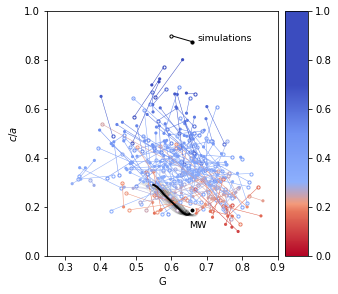

In [23]:
# start the plots:            
gs = GridSpec(nrows=1, ncols=2, width_ratios=[10, 1.], height_ratios=[1])

# start the plots:                                                                                                                                                                                                           
fig = plt.figure(figsize=(5, 4.5))
ax0 = fig.add_subplot(gs[0]) # radial distribution                                                                                                                                                                          
ax_cb = fig.add_subplot(gs[1]) # weights of the inertia tensor    

c_over_a = []
c_over_a_red = []

gini = []

for i, this_num in enumerate(sim_num):

    x = satellite_coordinates[i][0,:, 0] - MW_coordinates[i][0,0]
    y = satellite_coordinates[i][0,:, 1] - MW_coordinates[i][1,0]
    z = satellite_coordinates[i][0,:, 2] - MW_coordinates[i][2,0]
    
    coords = np.transpose(np.array([x, y, z]))
    eigenvalues, eigenvectors = inertiatensor(coords)
    eigenvalues_reduced, eigenvectors_reduced = inertiatensor_reduced(coords)

    radii = np.sqrt( (x**2 + y**2 + z**2) ) * 1000. # in kpc                                                                                                                                                            
    sorted = np.argsort(radii)
    radii = radii[sorted]

    # append the values                                                                                                                                                                                                 
    c_over_a.append(eigenvalues[2] / eigenvalues[0])
    c_over_a_red.append(eigenvalues_reduced[2] / eigenvalues_reduced[0])
    gini.append( gini_coefficient (radii**2))
    
c_over_a = np.array(c_over_a)
c_over_a_red = np.array(c_over_a_red)

gini = np.array(gini)

c_over_a_LCDM = np.copy(c_over_a) # we use this in the next plot
c_over_a_red_LCDM = np.copy(c_over_a_red) # we use this in the next plot

# plot the scatter of G vs c/a
#ax0.scatter(gini, c_over_a, facecolor = cmap(c_over_a), edgecolor='none', s=10, alpha = 1., zorder = 10., marker='o')

# Now, for every system, plot the previous 500 Myrs

time = cosmo.lookback_time(z=Redshifts).value

# we plot for 0.5 Gyrs
print ("time:", time[20], "Gyrs")

gradient = []
delta_g = []


for i, this_num in enumerate(sim_num):
    c_over_a = []
    gini = []
    for j in range (0, 21):
        x = satellite_coordinates[i][j,:, 0] - MW_coordinates[i][0,j]
        y = satellite_coordinates[i][j,:, 1] - MW_coordinates[i][1,j]
        z = satellite_coordinates[i][j,:, 2] - MW_coordinates[i][2,j]

        coords = np.transpose(np.array([x, y, z]))
        eigenvalues, eigenvectors = inertiatensor(coords)
        c_over_a.append(eigenvalues[2] / eigenvalues[0])
        
        
        radii = np.sqrt( (x**2 + y**2 + z**2) ) * 1000. # in kpc                                                                                                                                                            
        sorted = np.argsort(radii)
        radii = radii[sorted]
        gini.append( gini_coefficient (radii**2))

  
    ax0.plot([gini[0],gini[20]], [c_over_a[0],c_over_a[20]], color = cmap(c_over_a[0]), lw=.5, alpha = 1., zorder = 12)
    ax0.scatter(gini[0], c_over_a[0], facecolor = cmap(c_over_a[0]), edgecolor='none', s=10, alpha = 1., zorder = 10., marker='o')
    ax0.scatter(gini[20], c_over_a[20], facecolor = 'white' , edgecolor=cmap(c_over_a[0]), s=10, alpha = 1., zorder = 10., marker='o')
    
    gradient.append( (c_over_a[0]-c_over_a[20]) / (gini[0] - gini[20]) )
    delta_g.append (np.abs( (gini[0] - gini[20])) )
    
print ("average gradient", np.median(gradient) )
print ("average delta g", np.median(delta_g) )

ax0.plot ([0.6, 0.6+np.median(delta_g)], [0.9, 0.9 + np.median(gradient)  * np.median(delta_g)], color = 'black', lw =1)
ax0.scatter ([0.6+np.median(delta_g)], [0.9 + np.median(gradient)  * np.median(delta_g)], color = 'black', s=10, alpha = 1., zorder = 10., marker='o')
ax0.scatter ([0.6], [0.9], facecolor = 'white', edgecolor = 'black', s=10, alpha = 1., zorder = 10., marker='o')


# overplot the MW data      

x = coords_ML[:,0]
y = coords_ML[:,1]
z = coords_ML[:,2]

radii = np.sqrt(x**2 + y**2 + z**2)
sorted = np.argsort(radii)
radii = radii[sorted]

gini_mw =  gini_coefficient (radii**2)

#cumulative = np.cumsum(radii**2)
#cumulative = np.insert(cumulative, 0, 0.)
#gini_mw = (1./2. - np.sum(cumulative / cumulative[-1]) / 11.)*2.
                                                                                                                                                                                                    
ax0.scatter([gini_mw], [0.1852], edgecolor='white', facecolor='black', alpha = 1., s=30, lw=1.5, marker = 'o', zorder = 20000.)

ax0.plot(np.linspace(1,11,11), radii, lw = 3, ls = 'solid', alpha = 1., color = 'black', zorder = 10000.)

x = np.linspace(0,11,12)
y = cumulative / cumulative[-1]

ax1.plot(x, y,  lw = 4, ls = 'solid', alpha = 1., color = 'black', zorder = 10000.)

# Trace the trajectory of the MW's c/a and Gini for 1 Gyr

# First, plot the most likely orbit

x = coords_ML_integrated_1Gyr[:,0,0:-1:5]
y = coords_ML_integrated_1Gyr[:,1,0:-1:5]
z = coords_ML_integrated_1Gyr[:,2,0:-1:5]
     
coords = np.transpose(np.array([x, y, z]))

gini_mw = []
ca_mw = []

for i in range (0, int(x.shape[1]/2)): # past 0.5 Gyr
    radii = np.sqrt(x[:,i]**2 + y[:,i]**2 + z[:,i]**2)
     
    if max(radii) < 300. :
        sorted = np.argsort(radii)
        radii = radii[sorted]
        
        gini_mw.append( gini_coefficient (radii**2))

        
#        cumulative = np.cumsum(radii**2)
#        cumulative = np.insert(cumulative, 0, 0.)
#        gini_mw.append( (1./2. - np.sum(cumulative / cumulative[-1]) / 11.)*2.)

        eigenvalues, eigenvectors = inertiatensor(coords[i])
        ca_mw.append(eigenvalues[2]/eigenvalues[0])

ax0.plot(gini_mw, ca_mw, lw=2, color='black', alpha = 1., zorder = 1000.)

# Repeat for the MC samples
    
use_MC_samples = min ([100, N_MC_samples])
    
for sample in range (use_MC_samples):
        
    x = coords_MC_integrated[sample,:,0,0:-1:5]
    y = coords_MC_integrated[sample,:,1,0:-1:5]
    z = coords_MC_integrated[sample,:,2,0:-1:5]

    coords = np.transpose(np.array([x, y, z]))

    gini_mw = []
    ca_mw = []

    for i in range (0, int(x.shape[1]/2)):         # past 0.5 Gyr
        radii = np.sqrt(x[:,i]**2 + y[:,i]**2 + z[:,i]**2)
        
        if max(radii) < 300. :
            sorted = np.argsort(radii)
            radii = radii[sorted]
            gini_mw.append( gini_coefficient (radii**2))
    
            eigenvalues, eigenvectors = inertiatensor(coords[i])
            ca_mw.append(eigenvalues[2]/eigenvalues[0])

    ax0.plot(gini_mw, ca_mw, lw=0.5, color='black', alpha = .1, zorder = 1.)
    
gini = np.concatenate([gini, gini_remnants])
c_over_a = np.concatenate([c_over_a, c_over_a_remnants])

selection = np.where(gini > 0.1)

gini = gini[selection]
c_over_a = c_over_a[selection]

# axis limits and labels                                                                                                                                                                                                    
ax0.set_ylim(0.0,1.0)
ax0.set_xlim(0.25, 0.9)
ax0.set_ylabel('$c/a$', fontsize=10)
ax0.set_xlabel('G', fontsize=10)

# color bar:                                                                                                                                                                                                                
cb = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap),
             cax=ax_cb, orientation='vertical', label='')
cb.set_ticks([0., 0.2, 0.4, 0.6, 0.8, 1.0])
ax_cb.yaxis.set_ticks_position('right')

# overplot the labels
ax0.text(0.615, 0.115, 'MW', transform=ax0.transAxes, fontsize=9.5, color='black', zorder = 100000)
ax0.text(0.65, 0.88, 'simulations', transform=ax0.transAxes, fontsize=9.5, color='black', zorder = 100000)


# move the color bar                                                                                                                                                                                                 
offset=-0.05
bbox=ax_cb.get_position()
ax_cb.set_position([bbox.x0 + offset, bbox.y0, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])

# save                                                                                                                                                                                                                      
fig.savefig('plots/radial_distribution_complete_evolution'+suffix+'.pdf', dpi=200, bbox_inches='tight')


## Randomise the position of the satellites *along their orbit*, and plot the resulting distributions of $c/a$ (_Figure 3_).

satellites_names: ['LMC' 'SMC' 'Sagittarius' 'Fornax' 'Leo I' 'Sculptor' 'Leo II' 'Sextans'
 'Carina' 'Draco' 'Ursa Minor']
i= 0  of  11 satellite: LMC
number of elements in x: 81290
i= 1  of  11 satellite: SMC
number of elements in x: 67113
i= 2  of  11 satellite: Sagittarius
number of elements in x: 30577
i= 3  of  11 satellite: Fornax
number of elements in x: 117690
i= 4  of  11 satellite: Leo I
number of elements in x: 124531
i= 5  of  11 satellite: Sculptor
number of elements in x: 75318
i= 6  of  11 satellite: Leo II
number of elements in x: 186852
i= 7  of  11 satellite: Sextans
number of elements in x: 96593
i= 8  of  11 satellite: Carina
number of elements in x: 104988
i= 9  of  11 satellite: Draco
number of elements in x: 55650
i= 10  of  11 satellite: Ursa Minor
number of elements in x: 61582
shape before (11, 10000)
last: 5000
shape now (11, 5000)
 0.5 Gyr ca N_bins: 100
 0.5 Gyr ca reduced N_bins: 100
 1 Gyr ca N_bins: 100
 1 Gyr ca reduced N_bins: 100
 2 Gyr ca N_bins: 10

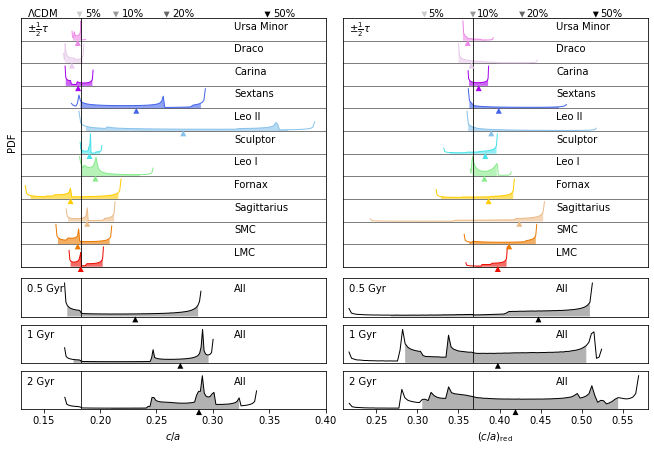

In [24]:
# start the plots:
fig = plt.figure(figsize=(12, 8))

gs = GridSpec(nrows=5, ncols=2, width_ratios=[1,1], height_ratios=[0.3, 6.5,1, 1, 1])

axtop_l = fig.add_subplot(gs[0,0]) 
axtop_r = fig.add_subplot(gs[0,1]) 

ax0 = fig.add_subplot(gs[1,0]) 
ax1 = fig.add_subplot(gs[1,1]) 

ax2 = fig.add_subplot(gs[2,0]) 
ax3 = fig.add_subplot(gs[2,1])

ax4 = fig.add_subplot(gs[3,0]) 
ax5 = fig.add_subplot(gs[3,1])

ax6 = fig.add_subplot(gs[4,0]) 
ax7 = fig.add_subplot(gs[4,1])

# The coordinates and inertia tensor of the full set of 11 satellites
x_11 = coords_ML[:,0]
y_11 = coords_ML[:,1]
z_11 = coords_ML[:,2]

eigenvalues_11 = eigenvalues_ML_z0
eigenvalues_reduced_11 = eigenvalues_ML_reduced_z0

# we sort by radii from largest to smallest top to bottom
sorted = [0,1,2,3,4,5,6,7,8,9,10]

x_11 = x_11[sorted]
y_11 = y_11[sorted]
z_11 = z_11[sorted]
satellites_names_r = satellites_names[sorted]

print("satellites_names:", satellites_names)

for i in range (0,11):
    
    print('i=', i, ' of ', 11, 'satellite:', satellites_names_r[i]) #end='\r' )
    
    indices = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
    indices.remove(i)      # We remove in turn the ith satellite from the list of indices
    x_10 = x_11[indices]   # The coordinates with the ith satellite removed
    y_10 = y_11[indices]
    z_10 = z_11[indices]

    ca_10 = []            # these will hold the values of c/a and
    ca_reduced_10 = []    # c/a reduced for each set

    # combine the +1/2 -1/2 period orbits for this satellite:
    x_1 = np.concatenate([np.array(coords_ML_integrated_half_period[sorted[i],0]),np.array(coords_ML_integrated_half_period_future[sorted[i],0])])
    y_1 = np.concatenate([np.array(coords_ML_integrated_half_period[sorted[i],1]),np.array(coords_ML_integrated_half_period_future[sorted[i],1])])
    z_1 = np.concatenate([np.array(coords_ML_integrated_half_period[sorted[i],2]),np.array(coords_ML_integrated_half_period_future[sorted[i],2])])
    
    # remove section of the orbit where a satellite is outside r=300 kpc - this only affects Leo I.
    radius =  np.sqrt(x_1**2 + y_1**2 + z_1**2)
    selection_within = np.where (radius < 300)[0]
    x_1 = x_1[selection_within]
    y_1 = y_1[selection_within]
    z_1 = z_1[selection_within]
    
    print ("number of elements in x:", len(x_1))
    
    number_elements = len(x_1)
    
    for j in range(len(x_1)):
                
        # Insert the random coordinate, with the radius of the ith satellite
        x = np.insert(x_10, 0, x_1[j])
        y = np.insert(y_10, 0, y_1[j])
        z = np.insert(z_10, 0, z_1[j])
        
        coords = np.transpose([x, y, z])
        eigenvalues, eigenvectors = inertiatensor(coords)
        eigenvalues_reduced, eigenvectors_reduced = inertiatensor_reduced(coords)

        ca_10.append(eigenvalues[2] / eigenvalues[0])
        ca_reduced_10.append(eigenvalues_reduced[2] / eigenvalues_reduced[0])

    ca_reduced_10 = np.array(ca_reduced_10)    
    ca_10 = np.array(ca_10)

    # plot the distributions with a vertical offset
    y_offset = i*40
    ax0.plot([0,1], [y_offset, y_offset], lw=0.5, color ="black") # plot a zero line for this offset
    ax1.plot([0,1], [y_offset, y_offset], lw=0.5, color ="black") 

    #first, c/a on axis0
    median = np.median(ca_10)
    percentile90 = np.percentile(ca_10, 90)
    percentile10 = np.percentile(ca_10, 10)

    N_bins = int ( (max(ca_10) - min(ca_10))*500) + 30
    hist, bin_edges = np.histogram(ca_10, N_bins)
    bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
    hist = hist / max(hist)
        
    selection = np.where(np.logical_and(bin_centers >= min(ca_10) , bin_centers <= max(ca_10)))[0]
    ax0.plot(bin_centers[selection], hist[selection]*35+y_offset, color = colors_11[sorted[i]], lw=1)
    selection = np.where(np.logical_and(bin_centers >= percentile10 , bin_centers <= percentile90))[0]
    ax0.fill_between(bin_centers[selection], hist[selection]*35 + y_offset, bin_centers[selection]*0.+y_offset, facecolor = colors_11[sorted[i]], edgecolor='none', alpha =.6)
    
    ax0.text(0.7, 0.045+0.091*i, satellites_names_r[i], transform = ax0.transAxes)
    
    ax0.scatter(median, y_offset-4, marker='^', facecolor = colors_11[sorted[i]], edgecolor='none', alpha =1., clip_on=False, zorder = 10)

    #repeat for c/a reduced on axis 1
    median = np.median(ca_reduced_10)
    percentile90 = np.percentile(ca_reduced_10, 90)
    percentile10 = np.percentile(ca_reduced_10, 10)

    N_bins = int ( (max(ca_reduced_10) - min(ca_reduced_10))*500) + 30
    hist, bin_edges = np.histogram(ca_reduced_10, N_bins)
    bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
    hist = hist / max(hist)

    selection = np.where(np.logical_and(bin_centers >= min(ca_reduced_10) , bin_centers <= max(ca_reduced_10)))[0]
    ax1.plot(bin_centers[selection], hist[selection]*35+y_offset, color = colors_11[sorted[i]], lw=1)
    selection = np.where(np.logical_and(bin_centers >= percentile10 , bin_centers <= percentile90))[0]
    ax1.fill_between(bin_centers[selection], hist[selection]*35 + y_offset, bin_centers[selection]*0.+y_offset, facecolor = colors_11[sorted[i]], edgecolor='none', alpha =.6)
    
    ax1.text(0.7, 0.045+0.091*i, satellites_names_r[i], transform = ax1.transAxes)
    
    ax1.scatter(median, y_offset-4, marker='^', facecolor = colors_11[sorted[i]], edgecolor='none', alpha =1., clip_on=False, zorder = 10)

    
# Compute time averaged distributions - for 0.5, 1 Gyr and 2 Gyr.

# 0.5 Gyrs.
ca_random = []
ca_reduced_random = []

x = coords_ML_integrated_1Gyr[:,0,0:-1]
y = coords_ML_integrated_1Gyr[:,1,0:-1]
z = coords_ML_integrated_1Gyr[:,2,0:-1]

print ("shape before", x.shape)
last= int(np.floor(x.shape[1]/2))  # only use 1/2 of the interval to 1 Gyr.

print ("last:", last)

x = x[:,0:last]
y = y[:,0:last]
z = z[:,0:last]


print ("shape now", x.shape)

coords = np.transpose([x, y, z])

for i in range (x.shape[1]):
    eigenvalues, eigenvectors = inertiatensor(coords[i])
    eigenvalues_reduced, eigenvectors_reduced = inertiatensor_reduced(coords[i])
    ca_random.append(eigenvalues[2] / eigenvalues[0])
    ca_reduced_random.append(eigenvalues_reduced[2] / eigenvalues_reduced[0])

ca_random = np.array(ca_random)
ca_reduced_random = np.array(ca_reduced_random)

median = np.median(ca_random)              # median value
percentile10 = np.percentile(ca_random, 10) 
percentile90 = np.percentile(ca_random, 90)  
N_bins = 100

print (" 0.5 Gyr ca N_bins:", N_bins)

hist, bin_edges = np.histogram(ca_random, N_bins)
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
hist = hist / max(hist)

ax2.plot(bin_centers, hist*35, color = 'black', lw=1)

selection = np.where(np.logical_and(bin_centers >= percentile10 , bin_centers <= percentile90))[0]
ax2.fill_between(bin_centers[selection], hist[selection]*35, bin_centers[selection]*0., facecolor = 'black', edgecolor='none', alpha =.3)

ax2.scatter(median, -3, marker='^', facecolor = 'black', edgecolor='none', alpha =1., clip_on=False, zorder = 10)

median = np.median(ca_reduced_random)              # median value
percentile10 = np.percentile(ca_reduced_random, 10)
percentile90 = np.percentile(ca_reduced_random, 90)

N_bins = 100
print (" 0.5 Gyr ca reduced N_bins:", N_bins)

hist, bin_edges = np.histogram(ca_reduced_random, N_bins)
bin_centers = bin_edges[:-1] + 0.5 * (max(ca_reduced_random) - min(ca_reduced_random)) / N_bins
hist = hist / max(hist)

ax3.plot(bin_centers, hist*35, color = 'black', lw=1)

selection = np.where(np.logical_and(bin_centers >= percentile10 , bin_centers <= percentile90))[0]
ax3.fill_between(bin_centers[selection], hist[selection]*35 , bin_centers[selection]*0., facecolor = 'black', edgecolor='none', alpha =.3)

ax3.scatter(median, -3, marker='^', facecolor = 'black', edgecolor='none', alpha =1., clip_on=False, zorder = 10)



# 1 Gyrs.
ca_random = []
ca_reduced_random = []

x = coords_ML_integrated_1Gyr[:,0,0:-1]
y = coords_ML_integrated_1Gyr[:,1,0:-1]
z = coords_ML_integrated_1Gyr[:,2,0:-1]

coords = np.transpose([x, y, z])

for i in range (x.shape[1]):
    eigenvalues, eigenvectors = inertiatensor(coords[i])
    eigenvalues_reduced, eigenvectors_reduced = inertiatensor_reduced(coords[i])
    ca_random.append(eigenvalues[2] / eigenvalues[0])
    ca_reduced_random.append(eigenvalues_reduced[2] / eigenvalues_reduced[0])

ca_random = np.array(ca_random)
ca_reduced_random = np.array(ca_reduced_random)

median = np.median(ca_random)              # median value
percentile10 = np.percentile(ca_random, 10) 
percentile90 = np.percentile(ca_random, 90)  
N_bins = 100

print (" 1 Gyr ca N_bins:", N_bins)

hist, bin_edges = np.histogram(ca_random, N_bins)
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
hist = hist / max(hist)

ax4.plot(bin_centers, hist*35, color = 'black', lw=1)

selection = np.where(np.logical_and(bin_centers >= percentile10 , bin_centers <= percentile90))[0]
ax4.fill_between(bin_centers[selection], hist[selection]*35, bin_centers[selection]*0., facecolor = 'black', edgecolor='none', alpha =.3)

ax4.scatter(median, -3, marker='^', facecolor = 'black', edgecolor='none', alpha =1., clip_on=False, zorder = 10)

median = np.median(ca_reduced_random)              # median value
percentile10 = np.percentile(ca_reduced_random, 10)
percentile90 = np.percentile(ca_reduced_random, 90)

N_bins = 100
print (" 1 Gyr ca reduced N_bins:", N_bins)

hist, bin_edges = np.histogram(ca_reduced_random, N_bins)
bin_centers = bin_edges[:-1] + 0.5 * (max(ca_reduced_random) - min(ca_reduced_random)) / N_bins
hist = hist / max(hist)

ax5.plot(bin_centers, hist*35, color = 'black', lw=1)

selection = np.where(np.logical_and(bin_centers >= percentile10 , bin_centers <= percentile90))[0]
ax5.fill_between(bin_centers[selection], hist[selection]*35 , bin_centers[selection]*0., facecolor = 'black', edgecolor='none', alpha =.3)

ax5.scatter(median, -3, marker='^', facecolor = 'black', edgecolor='none', alpha =1., clip_on=False, zorder = 10)

# 2 Gyrs
ca_random = []
ca_reduced_random = []

x = coords_ML_integrated_2Gyr[:,0,0:-1]
y = coords_ML_integrated_2Gyr[:,1,0:-1]
z = coords_ML_integrated_2Gyr[:,2,0:-1]

coords = np.transpose([x, y, z])

for i in range (x.shape[1]):
    eigenvalues, eigenvectors = inertiatensor(coords[i])
    eigenvalues_reduced, eigenvectors_reduced = inertiatensor_reduced(coords[i])

    ca_random.append(eigenvalues[2] / eigenvalues[0])
    ca_reduced_random.append(eigenvalues_reduced[2] / eigenvalues_reduced[0])

ca_random = np.array(ca_random)
ca_reduced_random = np.array(ca_reduced_random)

median = np.median(ca_random)              # median value
percentile10 = np.percentile(ca_random, 10)
percentile90 = np.percentile(ca_random, 90)

N_bins = 100
print (" 2 Gyr ca N_bins:", N_bins)
    
hist, bin_edges = np.histogram(ca_random, N_bins)
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
hist = hist / max(hist)

ax6.plot(bin_centers, hist*35, color = 'black', lw=1)

selection = np.where(np.logical_and(bin_centers >= percentile10 , bin_centers <= percentile90))[0]
ax6.fill_between(bin_centers[selection], hist[selection]*35, bin_centers[selection]*0., facecolor = 'black', edgecolor='none', alpha =.3)

ax6.scatter(median, -3, marker='^', facecolor = 'black', edgecolor='none', alpha =1., clip_on=False, zorder = 10)

median = np.median(ca_reduced_random)              # median value
percentile10 = np.percentile(ca_reduced_random, 10)
percentile90 = np.percentile(ca_reduced_random, 90)

N_bins = 100
print ("ca reduced N_bins:", N_bins)

hist, bin_edges = np.histogram(ca_reduced_random, N_bins)
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
hist = hist / max(hist)

#selection = np.where(np.logical_and(bin_centers >= min(ca_reduced_random) , bin_centers <= max(ca_reduced_random)))[0]
ax7.plot(bin_centers, hist*35, color = 'black', lw=1)

selection = np.where(np.logical_and(bin_centers >= percentile10 , bin_centers <= percentile90))[0]
ax7.fill_between(bin_centers[selection], hist[selection]*35 , bin_centers[selection]*0., facecolor = 'black', edgecolor='none', alpha =.3)

ax7.scatter(median, -3, marker='^', facecolor = 'black', edgecolor='none', alpha =1., clip_on=False, zorder = 10)
    
# overplot the MW values as vertical lines
ax0.axvline(x=eigenvalues_11[2]/eigenvalues_11[0], ls = 'solid', lw = .8, color = 'black')
ax1.axvline(x=eigenvalues_reduced_11[2]/eigenvalues_reduced_11[0], ls = 'solid', lw = .8, color = 'black')

ax2.axvline(x=eigenvalues_11[2]/eigenvalues_11[0], ls = 'solid', lw = .8, color = 'black')
ax3.axvline(x=eigenvalues_reduced_11[2]/eigenvalues_reduced_11[0], ls = 'solid', lw = .8, color = 'black')

ax4.axvline(x=eigenvalues_11[2]/eigenvalues_11[0], ls = 'solid', lw = .8, color = 'black')
ax5.axvline(x=eigenvalues_reduced_11[2]/eigenvalues_reduced_11[0], ls = 'solid', lw = .8, color = 'black')

ax6.axvline(x=eigenvalues_11[2]/eigenvalues_11[0], ls = 'solid', lw = .8, color = 'black')
ax7.axvline(x=eigenvalues_reduced_11[2]/eigenvalues_reduced_11[0], ls = 'solid', lw = .8, color = 'black')

ax0.set_xlim(0.13,0.40)
ax0.set_ylim(0,440)
ax0.set_yticks([])
ax0.set_xticks([])
ax0.set_ylabel(r'PDF')

ax1.set_xlim(0.21,0.58)
ax1.set_ylim(0,440)
ax1.set_yticks([])
ax1.set_xticks([])

ax2.set_xlim(0.13,0.40)
ax2.set_ylim(0.,40.)
ax2.set_yticks([])
ax2.set_xticks([])

ax3.set_xlim(0.21,0.58)
ax3.set_ylim(0.,40.)
ax3.set_yticks([])
ax3.set_xticks([])

ax4.set_xlim(0.13,0.40)
ax4.set_ylim(0.,40.)
ax4.set_yticks([])
ax4.set_xticks([])

ax5.set_xlim(0.21,0.58)
ax5.set_ylim(0.,40.)
ax5.set_yticks([])
ax5.set_xticks([])

ax6.set_xlim(0.13,0.40)
ax6.set_ylim(0.,40.)
ax6.set_xlabel(r'$c/a$')
ax6.set_yticks([])

ax7.set_xlim(0.21,0.58)
ax7.set_ylim(0.,40.)
ax7.set_yticks([])
ax7.set_xlabel(r'$(c/a)_\mathrm{red}$')


ax0.text(0.018, 0.94, r'$\pm \frac{1}{2} \tau$', transform = ax0.transAxes)
ax1.text(0.018, 0.94, r'$\pm \frac{1}{2} \tau$', transform = ax1.transAxes)
ax2.text(0.018, 0.65, '0.5 Gyr', transform = ax2.transAxes)
ax3.text(0.018, 0.65, '0.5 Gyr', transform = ax3.transAxes)
ax4.text(0.018, 0.65, '1 Gyr', transform = ax4.transAxes)
ax5.text(0.018, 0.65, '1 Gyr', transform = ax5.transAxes)
ax6.text(0.018, 0.65, '2 Gyr', transform = ax6.transAxes)
ax7.text(0.018, 0.65, '2 Gyr', transform = ax7.transAxes)

ax2.text(0.7, 0.65, 'All', transform = ax2.transAxes)
ax3.text(0.7, 0.65, 'All', transform = ax3.transAxes)
ax4.text(0.7, 0.65, 'All', transform = ax4.transAxes)
ax5.text(0.7, 0.65, 'All', transform = ax5.transAxes)
ax6.text(0.7, 0.65, 'All', transform = ax6.transAxes)
ax7.text(0.7, 0.65, 'All', transform = ax7.transAxes)


#reduce space between panels
yoffset= + 0.03
bbox=ax0.get_position()
ax0.set_position([bbox.x0 , bbox.y0 + yoffset, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])
bbox=ax1.get_position()
ax1.set_position([bbox.x0 , bbox.y0 + yoffset, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])

yoffset= + 0.036
bbox=ax2.get_position()
ax2.set_position([bbox.x0 , bbox.y0 + yoffset, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])
bbox=ax3.get_position()
ax3.set_position([bbox.x0 , bbox.y0 + yoffset, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])

yoffset= + 0.048
bbox=ax4.get_position()
ax4.set_position([bbox.x0 , bbox.y0 + yoffset, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])
bbox=ax5.get_position()
ax5.set_position([bbox.x0 , bbox.y0 + yoffset, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])

yoffset= + 0.03
bbox=ax6.get_position()
ax6.set_position([bbox.x0 , bbox.y0 + yoffset + yoffset, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])
bbox=ax7.get_position()
ax7.set_position([bbox.x0 , bbox.y0 + yoffset + yoffset, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])

xoffset= - 0.05
bbox=ax1.get_position()
ax1.set_position([bbox.x0 + xoffset , bbox.y0, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])
bbox=ax3.get_position()
ax3.set_position([bbox.x0 + xoffset , bbox.y0, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])
bbox=ax5.get_position()
ax5.set_position([bbox.x0 + xoffset, bbox.y0, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])
bbox=ax7.get_position()
ax7.set_position([bbox.x0 + xoffset, bbox.y0, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])
bbox=axtop_r.get_position()
axtop_r.set_position([bbox.x0 + xoffset , bbox.y0, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])


axtop_l.set_xlim(0.13,0.40)
axtop_l.set_ylim(0,1)
axtop_l.axis('off')

median = np.median(c_over_a_LCDM)
percentile_5 = np.percentile(c_over_a_LCDM,5)
percentile_10 = np.percentile(c_over_a_LCDM,10)
percentile_20 = np.percentile(c_over_a_LCDM,20)

#axtop_l.plot([percentile_10, percentile_90], [0.5,0.5], ls = 'solid', lw = 5, color = 'black', alpha = 0.3)

axtop_l.scatter(percentile_5, 0.5, marker='v', facecolor = 'black', edgecolor='none', alpha =.2, clip_on=False, zorder = 10)
axtop_l.scatter(percentile_10, 0.5, marker='v', facecolor = 'black', edgecolor='none', alpha =.4, clip_on=False, zorder = 10)
axtop_l.scatter(percentile_20, 0.5, marker='v', facecolor = 'black', edgecolor='none', alpha =.6, clip_on=False, zorder = 10)
axtop_l.scatter(median, 0.5, marker='v', facecolor = 'black', edgecolor='none', alpha =1., clip_on=False, zorder = 10)

axtop_l.text(percentile_5+0.005, 0.3, '5%')
axtop_l.text(percentile_10+0.005, 0.3, '10%')
axtop_l.text(percentile_20+0.005, 0.3, '20%')
axtop_l.text(median+0.005, 0.3, '50%')

axtop_r.set_xlim(0.21,0.58)
axtop_r.set_ylim(0,1)
axtop_r.axis('off')

median = np.median(c_over_a_red_LCDM)
percentile_5 = np.percentile(c_over_a_red_LCDM,5)
percentile_10 = np.percentile(c_over_a_red_LCDM,10)
percentile_20 = np.percentile(c_over_a_red_LCDM,20)

axtop_r.scatter(percentile_5, 0.5, marker='v', facecolor = 'black', edgecolor='none', alpha =.2, clip_on=False, zorder = 10)
axtop_r.scatter(percentile_10, 0.5, marker='v', facecolor = 'black', edgecolor='none', alpha =.4, clip_on=False, zorder = 10)
axtop_r.scatter(percentile_20, 0.5, marker='v', facecolor = 'black', edgecolor='none', alpha =.6, clip_on=False, zorder = 10)
axtop_r.scatter(median, 0.5, marker='v', facecolor = 'black', edgecolor='none', alpha =1., clip_on=False, zorder = 10)

axtop_r.text(percentile_5+0.005, 0.3, '5%')
axtop_r.text(percentile_10+0.005, 0.3, '10%')
axtop_r.text(percentile_20+0.005, 0.3, '20%')
axtop_r.text(median+0.005, 0.3, '50%')

axtop_l.text(0.02, 0.3, r'$\Lambda$CDM', transform = axtop_l.transAxes)


fig.savefig('plots/ca_distributions_phase'+suffix+'.pdf', bbox_inches='tight', dpi=200)
print ('done')

## Plot the radial distribution and the Gini coefficients with snythetic data (supplementary information)

max of gini: 0.9951452212974157
med of gini: 0.6932992861951756
Epoch 0: 0.10050184279680252
Epoch 20: 0.08912196010351181
Epoch 40: 0.08904644846916199
Epoch 60: 0.08903477340936661
Epoch 80: 0.08902174979448318
Epoch 0: 0.1125473603606224
Epoch 20: 0.09274724870920181
Epoch 40: 0.09268983453512192
Epoch 60: 0.09266381710767746
Epoch 80: 0.09263807535171509
done


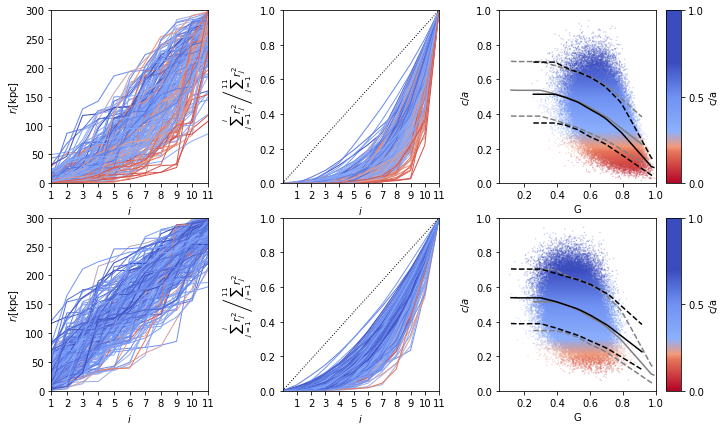

In [25]:
# these are computed for every set
c_over_a = []
gini = []
c_over_a_u = []
gini_u = []

# start the plot:                                                                                                                                                                                                           
fig = plt.figure(figsize=(10, 7))
gs = GridSpec(nrows=2, ncols=4, width_ratios=[10, 10, 10, 1.], height_ratios=[1,1])

ax0 = fig.add_subplot(gs[0,0]) # radial distribution                                                                                                                                                                          
ax1 = fig.add_subplot(gs[0,1]) # weights of the inertia tensor                                                        
ax2 = fig.add_subplot(gs[0,2]) # c/a as a function of G
ax_cb = fig.add_subplot(gs[0,3]) # color bar                                                                                                                                                                                  

ax0_u = fig.add_subplot(gs[1,0]) # radial distribution                                                                                                                                                                          
ax1_u = fig.add_subplot(gs[1,1]) # weights of the inertia tensor                                                                                                                                                                
ax2_u = fig.add_subplot(gs[1,2]) # c/a as a function of G     
ax_cb_u = fig.add_subplot(gs[1,3]) # color bar                                                                                                                                                                                  

# Create random samples

N_random_samples_Gini = 100000

# Uniform in r*0.5
for i in range (N_random_samples_Gini):

    coordinates = sample_reject(11)
  
    radiisquareroots = np.random.uniform(low=1e-3, high=17.3205, size=11)
    radii = radiisquareroots**2
    
    coordinates[0] = coordinates[0] * radii
    coordinates[1] = coordinates[1] * radii
    coordinates[2] = coordinates[2] * radii
    
    coords = np.transpose(coordinates)
    eigenvalues, eigenvectors = inertiatensor(coords)
    
    sorted = np.argsort(radii)
    radii = radii[sorted]
       
    cumulative = np.cumsum(radii**2) 
    cumulative = np.insert(cumulative, 0, 0.) # for the Gini plot, it is customary to start at i=0.

    # plot only the first 200 samples, otherwise the plot looks too messy

    if i < 200:    
        ax0.plot(np.linspace(1,11,11), radii, color = cmap(eigenvalues[2] / eigenvalues[0]), lw = 1., alpha = 1.)
        ax1.plot(np.linspace(0,11,12), cumulative / cumulative[-1], color = cmap(eigenvalues[2] / eigenvalues[0]), lw = 1., alpha = 1.)

    # append the values
    c_over_a.append(eigenvalues[2] / eigenvalues[0])
    
    gini.append( gini_coefficient (radii**2))

    if i % 500 == 0:
        print('i=', i, ' of ', N_random_samples_Gini, end='\r')
        
c_over_a = np.array(c_over_a)
gini = np.array(gini)

# uniform in r
for i in range (N_random_samples_Gini):

    coordinates = sample_reject(11)
  
    radii = np.random.uniform(low=1e-3, high=300, size=11)
    
    coordinates[0] = coordinates[0] * radii
    coordinates[1] = coordinates[1] * radii                                                                 
    coordinates[2] = coordinates[2] * radii
    
    coords = np.transpose(coordinates)
    eigenvalues, eigenvectors = inertiatensor(coords)
    
    sorted = np.argsort(radii)
    radii = radii[sorted]
       
    cumulative = np.cumsum(radii**2) 
    cumulative = np.insert(cumulative, 0, 0.) # for the Gini plot, it is customary to start at i=0.

    # plot only the first 200 samples, otherwise the plot looks too messy

    if i < 200:    
        ax0_u.plot(np.linspace(1,11,11), radii, color = cmap(eigenvalues[2] / eigenvalues[0]), lw = 1., alpha = 1.)
        ax1_u.plot(np.linspace(0,11,12), cumulative / cumulative[-1], color = cmap(eigenvalues[2] / eigenvalues[0]), lw = 1., alpha = 1.)

    # append the values
    c_over_a_u.append(eigenvalues[2] / eigenvalues[0])
    gini_u.append( gini_coefficient (radii**2))
    
    if i % 500 == 0:
        print('i=', i, ' of ', N_random_samples_Gini, end='\r')
        
c_over_a_u = np.array(c_over_a_u)
gini_u = np.array(gini_u)

ax2.scatter(gini, c_over_a, facecolor = cmap(c_over_a), edgecolor='none', s=dotsize, alpha = .3, zorder = 10., rasterized=True)
ax2_u.scatter(gini_u, c_over_a_u, facecolor = cmap(c_over_a_u), edgecolor='none', s=dotsize, alpha = .3, zorder = 10., rasterized=True)

# dotted line from 0,0 to 11,1
ax1.plot([0,11], [0,1], color = 'black', ls = 'dotted', lw = 1, zorder = 10000.)
ax1_u.plot([0,11], [0,1], color = 'black', ls = 'dotted', lw = 1, zorder = 10000.)

# move the panels further to the right
offset=.07
bbox=ax1.get_position()
ax1.set_position([bbox.x0 + offset, bbox.y0, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])
bbox=ax1_u.get_position()
ax1_u.set_position([bbox.x0 + offset, bbox.y0, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])

if Verbatim: print ("max of gini:", max(gini))
if Verbatim: print ("med of gini:", np.median(gini))

# Tensor flow fits:

# Reshape to input format for network
gini_reshaped = np.expand_dims(gini, 1)
ca_reshaped = np.expand_dims(c_over_a, 1)

# Instantiate model
quantiles = [.1, .5, .9]
model = q_model(sess, quantiles, batch_size=100)

# Initialize all variables
init_op = tf.global_variables_initializer()
sess.run(init_op)
# Run training
epochs = 100
model.fit(gini_reshaped, ca_reshaped, epochs)

# Generate the range of data we'd like to predict
edges = np.histogram_bin_edges(gini_reshaped, bins=50, range=None, weights=None)
centers = (edges[1:] + edges[:-1])/2

test_gini = np.expand_dims(centers, 1)
predictions = model.predict(test_gini)

ax2.plot(test_gini, predictions[0], linestyle='--', lw=1.5, color = 'black', zorder = 10000) 
ax2.plot(test_gini, predictions[1], linestyle='solid', lw=1.5, color = 'black', zorder = 10000) 
ax2.plot(test_gini, predictions[2], linestyle='--', lw=1.5, color = 'black', zorder = 10000) 

ax2_u.plot(test_gini, predictions[0], linestyle='--', lw=1.5, color = 'grey', zorder = 1000) 
ax2_u.plot(test_gini, predictions[1], linestyle='solid', lw=1.5, color = 'grey', zorder = 1000) 
ax2_u.plot(test_gini, predictions[2], linestyle='--', lw=1.5, color = 'grey', zorder = 1000) 

# Reshape to input format for network
gini_reshaped = np.expand_dims(gini_u, 1)
ca_reshaped = np.expand_dims(c_over_a_u, 1)

# Instantiate model
quantiles = [.1, .5, .9]
model = q_model(sess, quantiles, batch_size=100)

# Initialize all variables
init_op = tf.global_variables_initializer()
sess.run(init_op)
# Run training
epochs = 100
model.fit(gini_reshaped, ca_reshaped, epochs)

# Generate the range of data we'd like to predict
edges = np.histogram_bin_edges(gini_reshaped, bins=50, range=None, weights=None)
centers = (edges[1:] + edges[:-1])/2

test_gini = np.expand_dims(centers, 1)
predictions = model.predict(test_gini)

ax2_u.plot(test_gini, predictions[0], linestyle='--', lw=1.5, color = 'black', zorder = 10000) 
ax2_u.plot(test_gini, predictions[1], linestyle='solid', lw=1.5, color = 'black', zorder = 10000) 
ax2_u.plot(test_gini, predictions[2], linestyle='--', lw=1.5, color = 'black', zorder = 10000) 

ax2.plot(test_gini, predictions[0], linestyle='--', lw=1.5, color = 'grey', zorder = 1000) 
ax2.plot(test_gini, predictions[1], linestyle='solid', lw=1.5, color = 'grey', zorder = 1000) 
ax2.plot(test_gini, predictions[2], linestyle='--', lw=1.5, color = 'grey', zorder = 1000) 

# move the panel further to the right
offset=.12
bbox=ax2.get_position()
ax2.set_position([bbox.x0 + offset, bbox.y0, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])
bbox=ax2_u.get_position()
ax2_u.set_position([bbox.x0 + offset, bbox.y0, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])

# axis limits and labels
ax0_u.set_ylim(0,300)
ax0_u.set_xlim(1,11)
ax0_u.set_xticks(np.arange(1,12))
ax0_u.set_ylabel(r'$r_i$[kpc]', fontsize=10)
ax0_u.set_xlabel('$i$', fontsize=10)

ax1_u.set_ylim(0,1)
ax1_u.set_xlim(0,11)
ax1_u.set_xticks(np.arange(1,12))
ax1_u.set_ylabel(r'$\sum_{j=1}^{i}{r_j^2} \left/ \sum_{j=1}^{11}{r_j^2} \right.$', fontsize=10)
ax1_u.set_xlabel('$i$', fontsize=10)

ax2_u.set_ylim(0.0, 1.0)
ax2_u.set_xlim(0.05, 1.0)
ax2_u.set_ylabel('$c/a$', fontsize=10)
ax2_u.set_xlabel('G', fontsize=10)

ax0.set_ylim(0,300)
ax0.set_xlim(1,11)
ax0.set_xticks(np.arange(1,12))
ax0.set_ylabel(r'$r_i$[kpc]', fontsize=10)
ax0.set_xlabel('$i$', fontsize=10)

ax1.set_ylim(0,1)
ax1.set_xlim(0,11)
ax1.set_xticks(np.arange(1,12))
ax1.set_ylabel(r'$\sum_{j=1}^{i}{r_j^2} \left/ \sum_{j=1}^{11}{r_j^2} \right.$', fontsize=10)
ax1.set_xlabel('$i$', fontsize=10)

ax2.set_ylim(0.0, 1.0)
ax2.set_xlim(0.05, 1.0)
ax2.set_ylabel('$c/a$', fontsize=10)
ax2.set_xlabel('G', fontsize=10)

# color bars:
cb = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap),
             cax=ax_cb, orientation='vertical', label='c/a')
cb.set_ticks([0., 0.5, 1.])
cb.set_ticklabels(['0.0', '0.5', '1.0'])
ax_cb.yaxis.set_ticks_position('right')

cb_u = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap),
             cax=ax_cb_u, orientation='vertical', label='c/a')
cb_u.set_ticks([0., 0.5, 1.])
cb_u.set_ticklabels(['0.0', '0.5', '1.0'])
ax_cb_u.yaxis.set_ticks_position('right')

# move the color bars
offset=0.1
bbox=ax_cb.get_position()
ax_cb.set_position([bbox.x0 + offset, bbox.y0, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])
bbox=ax_cb_u.get_position()
ax_cb_u.set_position([bbox.x0 + offset, bbox.y0, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])

# save
plt.savefig('plots/radial_distribution_isotropic'+suffix+'.pdf', bbox_inches='tight', dpi=200)

print ('done')


## Randomise the positions of each satellite on the sky (supplementary information)

i= 0  of  11 satellite: Sagittarius
i= 1  of  11 satellite: LMC
i= 2  of  11 satellite: SMC
i= 3  of  11 satellite: Draco
i= 4  of  11 satellite: Ursa Minor
i= 5  of  11 satellite: Sculptor
i= 6  of  11 satellite: Sextans
i= 7  of  11 satellite: Carina
i= 8  of  11 satellite: Fornax
i= 9  of  11 satellite: Leo II
i= 10  of  11 satellite: Leo I
done


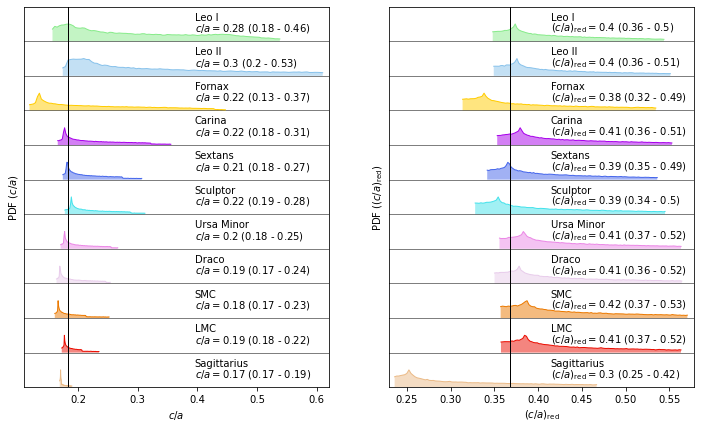

In [26]:
# start the plots:
fig0 = plt.figure(figsize=(12, 7))

gs = GridSpec(nrows=1, ncols=2, width_ratios=[1,1], height_ratios=[1])
ax0 = fig0.add_subplot(gs[0]) # radial distribution
ax1 = fig0.add_subplot(gs[1]) # radial distribution

# The coordinates and inertia tensor of the full set of 11 satellites
x_11 = coords_ML[:,0]
y_11 = coords_ML[:,1]
z_11 = coords_ML[:,2]

eigenvalues_11 = eigenvalues_ML_z0
eigenvalues_reduced_11 = eigenvalues_ML_reduced_z0

# we will add the random point at the radius of the satellite it replaces
radii_11 = np.sqrt( (x_11**2 + y_11**2 + z_11**2) )

# we sort by radii from largest to smallest top to bottom
sorted = np.argsort(radii_11)
radii_11 = radii_11[sorted]
x_11 = x_11[sorted]
y_11 = y_11[sorted]
z_11 = z_11[sorted]
satellites_names_r = satellites_names[sorted]

for i in range (0,11):
    
    print('i=', i, ' of ', 11, 'satellite:', satellites_names_r[i]) #end='\r' )
    
    indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    indices.remove(i)      # Remove the ith satellite from the list of indices
    x_10 = x_11[indices]   # The coordinates with the ith satellite removed
    y_10 = y_11[indices]
    z_10 = z_11[indices]

    ca_10 = []            # these will hold the values of c/a and
    ca_reduced_10 = []    # c/a reduced for each set

    # draw N_random_sky_coordinates random coordinates on the unit sphere (we can use the same in each set)
    random_coordinates = sample_reject(N_random_sky_coordinates)
    
    for j in range(N_random_sky_coordinates):

        # Insert the random coordinate, with the radius of the ith satellite
        x = np.insert(x_10, 0, random_coordinates[0,j]*radii_11[i])
        y = np.insert(y_10, 0, random_coordinates[1,j]*radii_11[i])
        z = np.insert(z_10, 0, random_coordinates[2,j]*radii_11[i])
        
        coords = np.transpose([x, y, z])
        eigenvalues, eigenvectors = inertiatensor(coords)
        eigenvalues_reduced, eigenvectors_reduced = inertiatensor_reduced(coords)

        ca_10.append(eigenvalues[2] / eigenvalues[0])
        ca_reduced_10.append(eigenvalues_reduced[2] / eigenvalues_reduced[0])

    ca_reduced_10 = np.array(ca_reduced_10)    
    ca_10 = np.array(ca_10)

    # plot the distributions with a vertical offset
    y_offset = i*40
    ax0.plot([0,1], [y_offset, y_offset], lw=0.5, color ="black") # plot a zero line for this offset
    ax1.plot([0,1], [y_offset, y_offset], lw=0.5, color ="black") 

    #first, c/a on axis0
    median = np.median(ca_10)              # median value
    percentile90 = np.percentile(ca_10, 90) 
    percentile10 = np.percentile(ca_10, 10)

    hist, bin_edges = np.histogram(ca_10, 100)
    bin_centers = bin_edges[:-1] + 0.5 * (max(ca_10) - min(ca_10)) / 100
    hist = hist / max(hist)
        
    selection = np.where(np.logical_and(bin_centers >= min(ca_10) , bin_centers <= max(ca_10)))[0]
    ax0.plot(bin_centers[selection], hist[selection]*20+y_offset, color = colors_11[sorted[i]], lw=1)
    ax0.fill_between(bin_centers[selection], hist[selection]*20 + y_offset, bin_centers[selection]*0.+y_offset, facecolor = colors_11[sorted[i]], edgecolor='none', alpha =.5)

    # write the name of the satellite, and the median and +/- 1 sigma ranges on the plot                                                                              
    ax0.text(0.56, 0.055+0.091*i, satellites_names_r[i], transform = ax0.transAxes)
    ax0.text(0.56, 0.026+0.091*i, r'$c/a=$'+str(np.round(median, 2))+' ('+str(np.round(percentile10, 2))+' - '+str(np.round(percentile90, 2))+')', transform=ax0.transAxes )

    #repeat for c/a reduced on axis 1
    median = np.median(ca_reduced_10)
    percentile90 = np.percentile(ca_reduced_10, 90)
    percentile10 = np.percentile(ca_reduced_10, 10)

    hist, bin_edges = np.histogram(ca_reduced_10, 100)
    bin_centers = bin_edges[:-1] + 0.5 * (max(ca_reduced_10) - min(ca_reduced_10)) / 100
    hist = hist / max(hist)

    selection = np.where(np.logical_and(bin_centers >= min(ca_reduced_10) , bin_centers <= max(ca_reduced_10)))[0]
    ax1.plot(bin_centers[selection], hist[selection]*20+y_offset, color = colors_11[sorted[i]], lw=1)
    ax1.fill_between(bin_centers[selection], hist[selection]*20 + y_offset, bin_centers[selection]*0.+y_offset, facecolor = colors_11[sorted[i]], edgecolor='none', alpha =.5)

    ax1.text(0.53, 0.055+0.091*i, satellites_names_r[i], transform = ax1.transAxes)
    ax1.text(0.53, 0.026+0.091*i, r'$(c/a)_\mathrm{red}=$'+str(np.round(median, 2))+' ('+str(np.round(percentile10, 2))+' - '+str(np.round(percentile90, 2))+')', transform=ax1.transAxes )

# overplot the MW values as vertical lines
ax0.axvline(x=eigenvalues_11[2]/eigenvalues_11[0], ls = 'solid', lw = 1., color = 'black')
ax1.axvline(x=eigenvalues_reduced_11[2]/eigenvalues_reduced_11[0], ls = 'solid', lw = 1., color = 'black')

ax0.set_xlim(0.11,0.62)
ax0.set_ylim(0,440)
ax0.set_yticks([])
ax0.set_xlabel(r'$c/a$')
ax0.set_ylabel(r'PDF $(c/a)$')

ax1.set_xlim(0.23,0.578)
ax1.set_ylim(0,440)
ax1.set_yticks([])
ax1.set_xlabel(r'$(c/a)_\mathrm{red}$')
ax1.set_ylabel(r'PDF $((c/a)_\mathrm{red})$')

fig0.savefig('plots/ca_distributions_randomised'+suffix+'.pdf', bbox_inches='tight', dpi=200)

print ('done')

## compute c/a for the 7 satellites with clustered orbital poles, and for random subsets of 7 out of 11 in the simulations.

In [27]:
# To get the satellites in the correct order (by luminosity)
indexes = np.array([1,  2,   0,   8,   10,  5,   9,  6, 7, 3, 4]).astype(int)

selection_7 = np.array([0, 1, 3, 6, 8, 9, 10]).astype(int)   # the indices for the seven with clustered poles

# draw 100 random samples of 7 for each of the simulations.

ca_7_z0 = []

for i, this_num in enumerate(sim_num):
    for j in range (100):
        selection = random.sample([0,1,2,3,4,5,6,7,8,9,10], 7)
    
        x = satellite_coordinates[i][0,selection, 0] - MW_coordinates[i][0,0]
        y = satellite_coordinates[i][0,selection, 1] - MW_coordinates[i][1,0]
        z = satellite_coordinates[i][0,selection, 2] - MW_coordinates[i][2,0]

        coords = np.transpose(np.array([x, y, z]))
        eigenvalues_z0, eigenvectors_z0 = inertiatensor(coords)

        ca_7_z0.append(eigenvalues_z0[2] / eigenvalues_z0[0])

print ("median c/a in sims:", np.median(ca_7_z0) )

# Now, compute c/a for the MW:
ca_z0_sample = []

for MC_sample in range (N_MC_samples): 
    
    x_sample = coords_MC[MC_sample,indexes[selection_7],0]
    y_sample = coords_MC[MC_sample,indexes[selection_7],1]
    z_sample = coords_MC[MC_sample,indexes[selection_7],2]
    
    # compute the eigenvectors at z=0 for reference for the rotation 
    coords_sample_z0 = np.transpose([x_sample, y_sample, z_sample])
    eigenvalues_sample_z0, eigenvectors_sample_z0 = inertiatensor(coords_sample_z0)
    
    ca_z0_sample.append(eigenvalues_sample_z0[2] / eigenvalues_sample_z0[0])
    
# median and error on the median of c/a at z=0 from the MC samples:
minus_sigma = np.percentile(ca_z0_sample, 15.8)
plus_sigma = np.percentile(ca_z0_sample, 84.2)
median = np.percentile(ca_z0_sample, 50)

print ("median c/a:", median)
print ("minus_sigma:", median - minus_sigma)
print ("plus_sigma:", plus_sigma - median)

percentile_in_sims = stats.percentileofscore(ca_7_z0, median)

print ("percentile in sims corresponding to median:", percentile_in_sims)

# select 10000 random samples of 7 in the MW, and compute the c/a value.

ca_z0_random_7 = []

for i in range (10000):
    selection = random.sample([0,1,2,3,4,5,6,7,8,9,10], 7)
    x_sample = coords_ML[indexes[selection],0]
    y_sample = coords_ML[indexes[selection],1]
    z_sample = coords_ML[indexes[selection],2]
   
    coords_sample_z0 = np.transpose([x_sample, y_sample, z_sample])
    eigenvalues_sample_z0, eigenvectors_sample_z0 = inertiatensor(coords_sample_z0)
    
    ca_z0_random_7.append(eigenvalues_sample_z0[2] / eigenvalues_sample_z0[0])

print ("median:", median)
print ("percentile of random 7:", stats.percentileofscore(ca_z0_random_7, median) )
    

median c/a in sims: 0.25122896622403923
median c/a: 0.19904441433086462
minus_sigma: 0.00556615781771283
plus_sigma: 0.005384322053502311
percentile in sims corresponding to median: 33.242574257425744
median: 0.19904441433086462
percentile of random 7: 79.19


## Print the data of the observations and the satellite kinematics into latex-formatted tables (supplementary information)

In [28]:

# For the observations (Table 1), we just print the inputs.

#              lmc    smc    sag     fnx    leo1  scl    leo2  sxt   car   dra   umi
magnitudes = [-18.1, -16.5, -13.5,  -13.4, -12., -11.1, -9.8, -9.3, -9.1, -8.8, -8.8]
names_satellites = names(11)

indexes_by_luminosity = [1,  2,   0,   8,   10,  5,   9,  6, 7, 3, 4]  

coords_ML = pos_GC_ML[indexes_by_luminosity]
vels_ML = vel_GC_ML[indexes_by_luminosity]

dmod = data['dmod'][sel_classical][reorder[indexes_by_luminosity]].data
dmod_plus = data['dmod+'][sel_classical][reorder[indexes_by_luminosity]].data
dmod_minus = data['dmod-'][sel_classical][reorder[indexes_by_luminosity]].data
dmod_err = (dmod_plus + dmod_minus) / 2.   # these errors are symmetric, this is just for consistency

c = coord.SkyCoord( ra=data['RA'][sel_classical][reorder[indexes_by_luminosity]], dec=data['Dec'][sel_classical][reorder[indexes_by_luminosity]], unit=(u.hourangle, u.deg), frame='icrs')

print ("dec in degrees:", c.dec.degree)
print ("ra in degrees:", c.ra.degree)

pmra = data['pmra'][sel_classical][reorder[indexes_by_luminosity]].data
pmra_plus = data['epmra+'][sel_classical][reorder[indexes_by_luminosity]].data
pmra_minus = data['epmra-'][sel_classical][reorder[indexes_by_luminosity]].data
pmra_err = (pmra_plus + pmra_minus) / 2.   # these errors are symmetric, this is just for consistency

pmdec = data['pmdec'][sel_classical][reorder[indexes_by_luminosity]].data
pmdec_plus = data['epmdec+'][sel_classical][reorder[indexes_by_luminosity]].data
pmdec_minus = data['epmdec-'][sel_classical][reorder[indexes_by_luminosity]].data
pmdec_err = (pmdec_plus + pmdec_minus) / 2.   # these errors are symmetric, this is just for consistency

print ("\nObservations (Table 1): \n")

# Observations: Name, Luminosity, distance modulus (with error), RA, Dec, proper motions (with errors)

for i in range(0,11):
    
    print (names_satellites[i] + ' & ' +              # name           
           str(magnitudes[i])  + ' & ' +             # luminosity
           ' $' + str(np.round(dmod[i], 3)) +   # dmod
           '\pm ' + str(np.round(dmod_err[i], 3)) + '$ ' +' & ' +   # dmod err
            str(np.round(c.ra.degree[i], 1)) + ' & ' +  # RA
            str(np.round(c.dec.degree[i], 1)) + ' & ' +  # Dec 
           ' $' + str(np.round(pmra[i], 3)) +   # pm ra
           '\pm ' + str(np.round(pmra_err[i], 3)) + '$ ' +' & ' +   # pm ra err
           ' $' + str(np.round(pmdec[i], 3)) +   # pm dec
           '\pm ' + str(np.round(pmdec_err[i], 3)) + '$ ' +' \\\\ ' )   # pm dec err
           
           
# For the kinematics, we need to iterate the MC samples.

print ("\nKinematics (Table 2): \n")

distances_MC = []
period_MC = []
eccentricity_MC = []
apocenter_MC = []
r_per_MC = []
r_par_MC = []
v_per_MC = []
v_par_MC = []
ca_MC = []
ca_red_MC = []

disp_v_per_MC = []
disp_v_par_MC = []

x_a_plane_MC = []
x_b_plane_MC = []
x_c_plane_MC = []
v_a_plane_MC = []
v_b_plane_MC = []
v_c_plane_MC = []

x_a_plane_GC_MC = []
x_b_plane_GC_MC = []
x_c_plane_GC_MC = []

v_a_plane_GC_MC = []
v_b_plane_GC_MC = []
v_c_plane_GC_MC = []

for MC_sample in range (N_MC_samples):
    
    # compute the per-sample quantities:
    x = coords_MC[MC_sample,:,0]
    y = coords_MC[MC_sample,:,1]
    z = coords_MC[MC_sample,:,2]

    # compute the eigenvectors at z=0 for reference for the rotation 
    coords_sample = np.transpose([x, y, z])
    eigenvalues_sample, eigenvectors_sample = inertiatensor(coords_sample)
    eigenvalues_reduced_sample, eigenvectors_reduced_sample = inertiatensor_reduced(coords_sample)
    
    ca_MC.append(eigenvalues_sample[2] / eigenvalues_sample[0])
    ca_red_MC.append(eigenvalues_reduced_sample[2] / eigenvalues_reduced_sample[0])
    
    # compute the per-satellite quantities:
    distance_sample = []
    period_sample = []
    eccentricity_sample = []
    apocenter_sample = []
    r_per_sample = []
    r_par_sample = []
    v_per_sample = []
    v_par_sample = []
    
    x_a_sample = []
    x_b_sample = []
    x_c_sample = []

    v_a_sample = []
    v_b_sample = []
    v_c_sample = []
    
    x_a_GC_sample = []
    x_b_GC_sample = []
    x_c_GC_sample = []

    v_a_GC_sample = []
    v_b_GC_sample = []
    v_c_GC_sample = []
    
    for i in range(0,11):
    
        x_i_GC = coords_MC[MC_sample,indexes[i],0]
        y_i_GC = coords_MC[MC_sample,indexes[i],1]
        z_i_GC = coords_MC[MC_sample,indexes[i],2]

        coords_i_GC = [x_i_GC, y_i_GC, z_i_GC]
        coords_prime_GC = np.dot(coords_i_GC, eigenvectors_sample).T
        
        x_a_GC_sample_i = coords_prime_GC[0]
        x_b_GC_sample_i = coords_prime_GC[1]
        x_c_GC_sample_i = coords_prime_GC[2]
        
        vx_i_GC = vels_MC[MC_sample,indexes[i],0]
        vy_i_GC = vels_MC[MC_sample,indexes[i],1]
        vz_i_GC = vels_MC[MC_sample,indexes[i],2]

        vels_i_GC = [vx_i_GC, vy_i_GC, vz_i_GC]
        vels_prime_GC = np.dot(vels_i_GC, eigenvectors_sample).T
        
        v_a_GC_sample_i = vels_prime_GC[0]
        v_b_GC_sample_i = vels_prime_GC[1]
        v_c_GC_sample_i = vels_prime_GC[2]
                
        x_i = coords_MC[MC_sample,indexes[i],0] - np.mean (coords_MC[MC_sample,:,0])
        y_i = coords_MC[MC_sample,indexes[i],1] - np.mean (coords_MC[MC_sample,:,1])
        z_i = coords_MC[MC_sample,indexes[i],2] - np.mean (coords_MC[MC_sample,:,2])

        vx_i = vels_MC[MC_sample,indexes[i],0] - np.mean (vels_MC[MC_sample,:,0])
        vy_i = vels_MC[MC_sample,indexes[i],1] - np.mean (vels_MC[MC_sample,:,1])
        vz_i = vels_MC[MC_sample,indexes[i],2] - np.mean (vels_MC[MC_sample,:,2])
        
        coords_i = [x_i, y_i, z_i]
        coords_prime = np.dot(coords_i, eigenvectors_sample).T
        
        r_per_sample_i = np.abs(coords_prime[2])
        r_per_sample.append(r_per_sample_i)
        
        r_par_sample_i = (coords_prime[0]**2 + coords_prime[1]**2)**.5
        r_par_sample.append(r_par_sample_i)
        
        vels_i = [vx_i, vy_i, vz_i]        
        vels_prime = np.dot(vels_i, eigenvectors_sample).T
        
        v_per_sample_i = np.abs(vels_prime[2])
        v_per_sample.append(v_per_sample_i)

        v_par_sample_i = (vels_prime[0]**2 + vels_prime[1]**2)**.5
        v_par_sample.append(v_par_sample_i)
        
        x_a_sample_i = coords_prime[0]
        x_b_sample_i = coords_prime[1]
        x_c_sample_i = coords_prime[2]

        v_a_sample_i = vels_prime[0]
        v_b_sample_i = vels_prime[1]
        v_c_sample_i = vels_prime[2]
        
        distance_sample_i = (coords_MC[MC_sample,indexes_by_luminosity[i],0]**2. + coords_MC[MC_sample,indexes_by_luminosity[i],1]**2. + coords_MC[MC_sample,indexes_by_luminosity[i],2]**2.)**.5    
        distance_sample.append(distance_sample_i)
    
        # integrate the orbit to get the period and apocenter
        coords = coord.SkyCoord(x=x_i_GC*u.kpc,
                                y=y_i_GC*u.kpc,
                                z=z_i_GC*u.kpc,
                                v_x=vx_i_GC*u.km/u.s,
                                v_y=vy_i_GC*u.km/u.s,
                                v_z=vz_i_GC*u.km/u.s,
                                frame=coord.Galactocentric)
        
        w0 = gd.PhaseSpacePosition(coords.data)
        orbit = potential_default.integrate_orbit(w0, dt=-dt*5, n_steps= N_timesteps*5) # the past evolution (dt is negative). 
        period_sample_i = orbit.estimate_period().value / -1000. # Gyr
        eccentricity_sample_i = orbit.eccentricity().value 
        apocenter_sample_i = orbit.apocenter().value 

        period_sample.append(period_sample_i)
        eccentricity_sample.append(eccentricity_sample_i)
        apocenter_sample.append(apocenter_sample_i)

        v_a_GC_sample.append(v_a_GC_sample_i)
        v_b_GC_sample.append(v_b_GC_sample_i)
        v_c_GC_sample.append(v_c_GC_sample_i)
        
        x_a_GC_sample.append(x_a_GC_sample_i)
        x_b_GC_sample.append(x_b_GC_sample_i)
        x_c_GC_sample.append(x_c_GC_sample_i)
        
        x_a_sample.append(x_a_sample_i)
        x_b_sample.append(x_b_sample_i)
        x_c_sample.append(x_c_sample_i)

        v_a_sample.append(v_a_sample_i)
        v_b_sample.append(v_b_sample_i)
        v_c_sample.append(v_c_sample_i)
        
    
    period_sample = np.array(period_sample)
    eccentricity_sample = np.array(eccentricity_sample)
    apocenter_sample = np.array(apocenter_sample)
    
    distance_sample = np.array(distance_sample)
    r_per_sample = np.array(r_per_sample)
    r_par_sample = np.array(r_par_sample)
    
    v_per_sample = np.array(v_per_sample)
    v_par_sample = np.array(v_par_sample)
    
    distances_MC.append(distance_sample)
    period_MC.append(period_sample)
    eccentricity_MC.append(eccentricity_sample)
    apocenter_MC.append(apocenter_sample)

    r_per_MC.append(r_per_sample)
    r_par_MC.append(r_par_sample)
    v_per_MC.append(v_per_sample)
    v_par_MC.append(v_par_sample)
    
    disp_v_per_MC.append( np.std(v_c_sample) )
    disp_v_par_MC.append( (np.std(v_a_sample)**2 + np.std(v_b_sample)**2)**.5 )
    
    x_a_plane_GC_MC.append(np.mean(x_a_GC_sample))
    x_b_plane_GC_MC.append(np.mean(x_b_GC_sample))
    x_c_plane_GC_MC.append(np.mean(x_c_GC_sample))
    
    v_a_plane_GC_MC.append(np.mean(v_a_GC_sample))
    v_b_plane_GC_MC.append(np.mean(v_b_GC_sample))
    v_c_plane_GC_MC.append(np.mean(v_c_GC_sample))
    
    x_a_plane_MC.append(np.mean(x_a_sample))
    x_b_plane_MC.append(np.mean(x_b_sample))
    x_c_plane_MC.append(np.mean(x_c_sample))

    v_a_plane_MC.append(np.mean(v_a_sample))
    v_b_plane_MC.append(np.mean(v_b_sample))
    v_c_plane_MC.append(np.mean(v_c_sample))

    
distances_MC = np.array(distances_MC)
period_MC = np.array(period_MC)
eccentricity_MC = np.array(eccentricity_MC)
apocenter_MC = np.array(apocenter_MC)


r_per_MC = np.array(r_per_MC)
r_par_MC = np.array(r_par_MC)

v_per_MC = np.array(v_per_MC)
v_par_MC = np.array(v_par_MC)

ca_MC = np.array(ca_MC)
ca_red_MC = np.array(ca_red_MC)

x_a_plane_MC = np.array(x_a_plane_MC)
x_b_plane_MC = np.array(x_b_plane_MC)
x_c_plane_MC = np.array(x_c_plane_MC)

v_a_plane_MC = np.array(v_a_plane_MC)
v_b_plane_MC = np.array(v_b_plane_MC)
v_c_plane_MC = np.array(v_c_plane_MC)

    
for i in range (11):
    print (names_satellites[i] + ' & ' +     # name      
           '$' + str(np.round(np.mean(distances_MC[:,i]), 1))  +           # GC distance
           ' \pm ' + str(np.round(np.std(distances_MC[:,i]), 1)) +  '$ ' +' & ' + # distance error
            '$' + str(np.round(np.mean(r_par_MC[:,i]), 1))  +           # parallel distance
           ' \pm ' + str(np.round(np.std(r_par_MC[:,i]), 1)) +  '$ ' +' & ' + # parallel distance error
             '$' + str(np.round(np.mean(r_per_MC[:,i]), 1)) +            # perpendicular distance
           ' \pm ' + str(np.round(np.std(r_per_MC[:,i]), 1)) +  '$ ' +' & ' + # perpendicular distance error
           
            '$' + str(np.round(np.mean(v_par_MC[:,i]), 1))  +           # parallel velocity
           ' \pm ' + str(np.round(np.std(v_par_MC[:,i]), 1)) +  '$ ' +' & ' + # parallel velocity error
             '$' + str(np.round(np.mean(v_per_MC[:,i]), 1)) +            # perpendicular velocity
           ' \pm ' + str(np.round(np.std(v_per_MC[:,i]), 1)) +  '$ ' +' & ' + # perpendicular velocity error
             '$' + str(np.round(np.mean(period_MC[:,i]), 2)) +           # period
           ' \pm ' + str(np.round(np.std(period_MC[:,i]), 2)) +  '$ ' +' & ' + # period error
            '$' + str(np.round(np.mean(apocenter_MC[:,i]), 1)) +           # apocenter
           ' \pm ' + str(np.round(np.std(apocenter_MC[:,i]), 1)) +  '$ ' + # apocenter error
           '\\\\ ' )   # pm dec err

# Ensemble quantities:
print ("c/a    :", np.round(np.mean(ca_MC),4), " err:", np.round(np.std(ca_MC),4))
print ("c/a red:", np.round(np.mean(ca_red_MC), 4), " err:", np.round(np.std(ca_red_MC), 4))

# The position and movement of the plane relative to the Galaxy                                                                                                                                                                                  

print ("Mean position of the plane (Galactocentric frame, plane eigenvectors)  " +
       str(np.round(np.mean(x_a_plane_GC_MC), 2) ) + "+/-" +  str(np.round(np.std(x_a_plane_GC_MC), 2) ) + " , " +
       str(np.round(np.mean(x_b_plane_GC_MC), 2) ) + "+/-" +  str(np.round(np.std(x_b_plane_GC_MC), 2) ) + " , " +
       str(np.round(np.mean(x_c_plane_GC_MC), 2) ) + "+/-" +  str(np.round(np.std(x_c_plane_GC_MC), 2) )  )

print ("Mean velocity of the plane (Galactocentric frame, plane eigenvectors)  " +
       str(np.round(np.mean(v_a_plane_GC_MC), 2) ) + "+/-" +  str(np.round(np.std(v_a_plane_GC_MC), 2) ) + " , " +
       str(np.round(np.mean(v_b_plane_GC_MC), 2) ) + "+/-" +  str(np.round(np.std(v_b_plane_GC_MC), 2) ) + " , " +
       str(np.round(np.mean(v_c_plane_GC_MC), 2) ) + "+/-" +  str(np.round(np.std(v_c_plane_GC_MC), 2) )  )

print ("Mean position of the plane (Plane frame, plane eigenvectors)  " +
       str(np.round(np.mean(x_a_plane_MC), 2) ) + "+/-" +  str(np.round(np.std(x_a_plane_MC), 2) ) + " , " +
       str(np.round(np.mean(x_b_plane_MC), 2) ) + "+/-" +  str(np.round(np.std(x_b_plane_MC), 2) ) + " , " +
       str(np.round(np.mean(x_c_plane_MC), 2) ) + "+/-" +  str(np.round(np.std(x_c_plane_MC), 2) )  )

print ("Mean velocity of the plane (plane eigenvectors)  " +
       str(np.round(np.mean(v_a_plane_MC), 2) ) + "+/-" +  str(np.round(np.std(v_a_plane_MC), 2) ) + " , " +
       str(np.round(np.mean(v_b_plane_MC), 2) ) + "+/-" +  str(np.round(np.std(v_b_plane_MC), 2) ) + " , " +
       str(np.round(np.mean(v_c_plane_MC), 2) ) + "+/-" +  str(np.round(np.std(v_c_plane_MC), 2) )  )

print ("Mean velocity dispersion parallel:" +
        str(np.round(np.mean(disp_v_par_MC), 2) ) + "+/-" +  str(np.round(np.std(disp_v_par_MC), 2) ) )

print ("Mean velocity dispersion perpendicular:" +
        str(np.round(np.mean(disp_v_per_MC), 2) ) + "+/-" +  str(np.round(np.std(disp_v_per_MC), 2) ) )


    
print ("Done.")


dec in degrees: [-69.75611111 -72.82861111 -30.54527778 -34.44916667  12.30638889
 -33.70916667  22.15166667  -1.61472222 -50.96611111  57.91527778
  67.2225    ]
ra in degrees: [ 80.89375     13.18666667 283.83125     39.99708333 152.11708333
  15.03916667 168.37       153.2625     100.40291667 260.05166667
 227.28541667]

Observations (Table 1): 

LMC & -18.1 &  $18.477\pm 0.026$  & 80.9 & -69.8 &  $1.85\pm 0.03$  &  $0.234\pm 0.03$  \\ 
SMC & -16.5 &  $18.977\pm 0.028$  & 13.2 & -72.8 &  $0.797\pm 0.03$  &  $-1.22\pm 0.03$  \\ 
Sagittarius & -13.5 &  $17.25\pm 0.008$  & 283.8 & -30.5 &  $-2.692\pm 0.001$  &  $-1.359\pm 0.001$  \\ 
Fornax & -13.4 &  $20.77\pm 0.03$  & 40.0 & -34.4 &  $0.382\pm 0.001$  &  $-0.359\pm 0.002$  \\ 
Leo I & -12.0 &  $22.07\pm 0.07$  & 152.1 & 12.3 &  $-0.05\pm 0.01$  &  $-0.11\pm 0.01$  \\ 
Sculptor & -11.1 &  $19.62\pm 0.04$  & 15.0 & -33.7 &  $0.099\pm 0.002$  &  $-0.16\pm 0.002$  \\ 
Leo II & -9.8 &  $21.68\pm 0.11$  & 168.4 & 22.2 &  $-0.14\pm 0.02$  &

## Congratulations, you have reached the end of this notebook!